## **Importing Libraries**

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree
import re

To implement object detection, an implementation of an object detection algorithm like Mask-RCNN or YOLO must be downloaded and set up. There are multiple ones out there. The ones used in this notebook uses tensorflow>2.0 and is compatible with GPU.

In [ ]:
#cloning GitHub repository for Mask-RCNN implementation in Keras
!git clone https://github.com/akTwelve/Mask_RCNN.git

In [ ]:
pwd

In [ ]:
cd ./Mask_RCNN

In [ ]:
#installing requirements from repository
!pip install -r requirements.txt

In [ ]:
#setting up mask-rcnn
!python setup.py install

In [ ]:
#confirming setup completion
!pip show mask-rcnn

In [ ]:
cd ../

This application requires GPU utilization for fast training. Having the 'use_multipreprocessing' parameter set to True in the Keras model seems to interfere with that. Thus, the script must be edited to remove the parameter or set it to false. In this case, it was removed along with the related 'workers' parameter.

In addition, one of the import statements - 'from mrcnn import utils' - will return an error if not modified to 'from ..mrcnn import utils'. This will be repeated later on for the visualize.py file.

To access and edit .py extension scripts in Kaggle, the magic command '%loadfile filepath' can be used. Once the changes are completed the changes can be saved by running the magic command %%writefile filepath

In [3]:
%%writefile ./Mask_RCNN/mrcnn/model.py
"""
Mask R-CNN
The main Mask R-CNN model implementation.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import datetime
import re
import math
from collections import OrderedDict
import multiprocessing
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import tensorflow.keras.utils as KU
from tensorflow.python.eager import context
import tensorflow.keras.models as KM

from ..mrcnn import utils

# Requires TensorFlow 2.0+
from distutils.version import LooseVersion
assert LooseVersion(tf.__version__) >= LooseVersion("2.0")

tf.compat.v1.disable_eager_execution()

############################################################
#  Utility Functions
############################################################


def log(text, array=None):
    """Prints a text message. And, optionally, if a Numpy array is provided it
    prints it's shape, min, and max values.
    """
    if array is not None:
        text = text.ljust(25)
        text += ("shape: {:20}  ".format(str(array.shape)))
        if array.size:
            text += ("min: {:10.5f}  max: {:10.5f}".format(array.min(),array.max()))
        else:
            text += ("min: {:10}  max: {:10}".format("",""))
        text += "  {}".format(array.dtype)
    print(text)


class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.

    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when making inferences
        """
        return super(self.__class__, self).call(inputs, training=training)


def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])


############################################################
#  Resnet Graph
############################################################

# Code adopted from:
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def resnet_graph(input_image, architecture, stage5=False, train_bn=True):
    """Build a ResNet graph.
        architecture: Can be resnet50 or resnet101
        stage5: Boolean. If False, stage5 of the network is not created
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
    C4 = x
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]


############################################################
#  Proposal Layer
############################################################

def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)] boxes to update
    deltas: [N, (dy, dx, log(dh), log(dw))] refinements to apply
    """
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    boxes: [N, (y1, x1, y2, x2)]
    window: [4] in the form y1, x1, y2, x2
    """
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped


class ProposalLayer(KL.Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.

    Inputs:
        rpn_probs: [batch, num_anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, num_anchors, (dy, dx, log(dh), log(dw))]
        anchors: [batch, num_anchors, (y1, x1, y2, x2)] anchors in normalized coordinates

    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, nms_threshold, config=None, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold

    def get_config(self):
        config = super(ProposalLayer, self).get_config()
        config["config"] = self.config.to_dict()
        config["proposal_count"] = self.proposal_count
        config["nms_threshold"] = self.nms_threshold
        return config

    def call(self, inputs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        # Anchors
        anchors = inputs[2]

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.
        pre_nms_limit = tf.minimum(self.config.PRE_NMS_LIMIT, tf.shape(input=anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,
                         name="top_anchors").indices
        scores = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        deltas = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        pre_nms_anchors = utils.batch_slice([anchors, ix], lambda a, x: tf.gather(a, x),
                                    self.config.IMAGES_PER_GPU,
                                    names=["pre_nms_anchors"])

        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]
        boxes = utils.batch_slice([pre_nms_anchors, deltas],
                                  lambda x, y: apply_box_deltas_graph(x, y),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors"])

        # Clip to image boundaries. Since we're in normalized coordinates,
        # clip to 0..1 range. [batch, N, (y1, x1, y2, x2)]
        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = utils.batch_slice(boxes,
                                  lambda x: clip_boxes_graph(x, window),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors_clipped"])

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Non-max suppression
        def nms(boxes, scores):
            indices = tf.image.non_max_suppression(
                boxes, scores, self.proposal_count,
                self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(input=proposals)[0], 0)
            proposals = tf.pad(tensor=proposals, paddings=[(0, padding), (0, 0)])
            return proposals
        proposals = utils.batch_slice([boxes, scores], nms,
                                      self.config.IMAGES_PER_GPU)

        if not context.executing_eagerly():
            # Infer the static output shape:
            out_shape = self.compute_output_shape(None)
            proposals.set_shape(out_shape)
        return proposals

    def compute_output_shape(self, input_shape):
        return None, self.proposal_count, 4


############################################################
#  ROIAlign Layer
############################################################

def log2_graph(x):
    """Implementation of Log2. TF doesn't have a native implementation."""
    return tf.math.log(x) / tf.math.log(2.0)


class PyramidROIAlign(KL.Layer):
    """Implements ROI Pooling on multiple levels of the feature pyramid.

    Params:
    - pool_shape: [pool_height, pool_width] of the output pooled regions. Usually [7, 7]

    Inputs:
    - boxes: [batch, num_boxes, (y1, x1, y2, x2)] in normalized
             coordinates. Possibly padded with zeros if not enough
             boxes to fill the array.
    - image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    - feature_maps: List of feature maps from different levels of the pyramid.
                    Each is [batch, height, width, channels]

    Output:
    Pooled regions in the shape: [batch, num_boxes, pool_height, pool_width, channels].
    The width and height are those specific in the pool_shape in the layer
    constructor.
    """

    def __init__(self, pool_shape, **kwargs):
        super(PyramidROIAlign, self).__init__(**kwargs)
        self.pool_shape = tuple(pool_shape)

    def get_config(self):
        config = super(PyramidROIAlign, self).get_config()
        config['pool_shape'] = self.pool_shape
        return config

    def call(self, inputs):
        # Crop boxes [batch, num_boxes, (y1, x1, y2, x2)] in normalized coords
        boxes = inputs[0]

        # Image meta
        # Holds details about the image. See compose_image_meta()
        image_meta = inputs[1]

        # Feature Maps. List of feature maps from different level of the
        # feature pyramid. Each is [batch, height, width, channels]
        feature_maps = inputs[2:]

        # Assign each ROI to a level in the pyramid based on the ROI area.
        y1, x1, y2, x2 = tf.split(boxes, 4, axis=2)
        h = y2 - y1
        w = x2 - x1
        # Use shape of first image. Images in a batch must have the same size.
        image_shape = parse_image_meta_graph(image_meta)['image_shape'][0]
        # Equation 1 in the Feature Pyramid Networks paper. Account for
        # the fact that our coordinates are normalized here.
        # e.g. a 224x224 ROI (in pixels) maps to P4
        image_area = tf.cast(image_shape[0] * image_shape[1], tf.float32)
        roi_level = log2_graph(tf.sqrt(h * w) / (224.0 / tf.sqrt(image_area)))
        roi_level = tf.minimum(5, tf.maximum(
            2, 4 + tf.cast(tf.round(roi_level), tf.int32)))
        roi_level = tf.squeeze(roi_level, 2)

        # Loop through levels and apply ROI pooling to each. P2 to P5.
        pooled = []
        box_to_level = []
        for i, level in enumerate(range(2, 6)):
            ix = tf.compat.v1.where(tf.equal(roi_level, level))
            level_boxes = tf.gather_nd(boxes, ix)

            # Box indices for crop_and_resize.
            box_indices = tf.cast(ix[:, 0], tf.int32)

            # Keep track of which box is mapped to which level
            box_to_level.append(ix)

            # Stop gradient propogation to ROI proposals
            level_boxes = tf.stop_gradient(level_boxes)
            box_indices = tf.stop_gradient(box_indices)

            # Crop and Resize
            # From Mask R-CNN paper: "We sample four regular locations, so
            # that we can evaluate either max or average pooling. In fact,
            # interpolating only a single value at each bin center (without
            # pooling) is nearly as effective."
            #
            # Here we use the simplified approach of a single value per bin,
            # which is how it's done in tf.crop_and_resize()
            # Result: [batch * num_boxes, pool_height, pool_width, channels]
            pooled.append(tf.image.crop_and_resize(
                feature_maps[i], level_boxes, box_indices, self.pool_shape,
                method="bilinear"))

        # Pack pooled features into one tensor
        pooled = tf.concat(pooled, axis=0)

        # Pack box_to_level mapping into one array and add another
        # column representing the order of pooled boxes
        box_to_level = tf.concat(box_to_level, axis=0)
        box_range = tf.expand_dims(tf.range(tf.shape(input=box_to_level)[0]), 1)
        box_to_level = tf.concat([tf.cast(box_to_level, tf.int32), box_range],
                                 axis=1)

        # Rearrange pooled features to match the order of the original boxes
        # Sort box_to_level by batch then box index
        # TF doesn't have a way to sort by two columns, so merge them and sort.
        sorting_tensor = box_to_level[:, 0] * 100000 + box_to_level[:, 1]
        ix = tf.nn.top_k(sorting_tensor, k=tf.shape(
            input=box_to_level)[0]).indices[::-1]
        ix = tf.gather(box_to_level[:, 2], ix)
        pooled = tf.gather(pooled, ix)

        # Re-add the batch dimension
        shape = tf.concat([tf.shape(input=boxes)[:2], tf.shape(input=pooled)[1:]], axis=0)
        pooled = tf.reshape(pooled, shape)
        return pooled

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + self.pool_shape + (input_shape[2][-1], )


############################################################
#  Detection Target Layer
############################################################

def overlaps_graph(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].
    """
    # 1. Tile boxes2 and repeat boxes1. This allows us to compare
    # every boxes1 against every boxes2 without loops.
    # TF doesn't have an equivalent to np.repeat() so simulate it
    # using tf.tile() and tf.reshape.
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1),
                            [1, 1, tf.shape(input=boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(input=boxes1)[0], 1])
    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)
    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(input=boxes1)[0], tf.shape(input=boxes2)[0]])
    return overlaps


def detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
    """Generates detection targets for one image. Subsamples proposals and
    generates target class IDs, bounding box deltas, and masks for each.

    Inputs:
    proposals: [POST_NMS_ROIS_TRAINING, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [MAX_GT_INSTANCES] int class IDs
    gt_boxes: [MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized coordinates.
    gt_masks: [height, width, MAX_GT_INSTANCES] of boolean type.

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
    deltas: [TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw))]
    masks: [TRAIN_ROIS_PER_IMAGE, height, width]. Masks cropped to bbox
           boundaries and resized to neural network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """
    # Assertions
    asserts = [
        tf.Assert(tf.greater(tf.shape(input=proposals)[0], 0), [proposals],
                  name="roi_assertion"),
    ]
    with tf.control_dependencies(asserts):
        proposals = tf.identity(proposals)

    # Remove zero padding
    proposals, _ = trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = trim_zeros_graph(gt_boxes, name="trim_gt_boxes")
    gt_class_ids = tf.boolean_mask(tensor=gt_class_ids, mask=non_zeros,
                                   name="trim_gt_class_ids")
    gt_masks = tf.gather(gt_masks, tf.compat.v1.where(non_zeros)[:, 0], axis=2,
                         name="trim_gt_masks")

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = tf.compat.v1.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix = tf.compat.v1.where(gt_class_ids > 0)[:, 0]
    crowd_boxes = tf.gather(gt_boxes, crowd_ix)
    gt_class_ids = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks = tf.gather(gt_masks, non_crowd_ix, axis=2)

    # Compute overlaps matrix [proposals, gt_boxes]
    overlaps = overlaps_graph(proposals, gt_boxes)

    # Compute overlaps with crowd boxes [proposals, crowd_boxes]
    crowd_overlaps = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max = tf.reduce_max(input_tensor=crowd_overlaps, axis=1)
    no_crowd_bool = (crowd_iou_max < 0.001)

    # Determine positive and negative ROIs
    roi_iou_max = tf.reduce_max(input_tensor=overlaps, axis=1)
    # 1. Positive ROIs are those with >= 0.5 IoU with a GT box
    positive_roi_bool = (roi_iou_max >= 0.5)
    positive_indices = tf.compat.v1.where(positive_roi_bool)[:, 0]
    # 2. Negative ROIs are those with < 0.5 with every GT box. Skip crowds.
    negative_indices = tf.compat.v1.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

    # Subsample ROIs. Aim for 33% positive
    # Positive ROIs
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE *
                         config.ROI_POSITIVE_RATIO)
    positive_indices = tf.random.shuffle(positive_indices)[:positive_count]
    positive_count = tf.shape(input=positive_indices)[0]
    # Negative ROIs. Add enough to maintain positive:negative ratio.
    r = 1.0 / config.ROI_POSITIVE_RATIO
    negative_count = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    negative_indices = tf.random.shuffle(negative_indices)[:negative_count]
    # Gather selected ROIs
    positive_rois = tf.gather(proposals, positive_indices)
    negative_rois = tf.gather(proposals, negative_indices)

    # Assign positive ROIs to GT boxes.
    positive_overlaps = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.cond(
        pred=tf.greater(tf.shape(input=positive_overlaps)[1], 0),
        true_fn=lambda: tf.argmax(input=positive_overlaps, axis=1),
        false_fn=lambda: tf.cast(tf.constant([]), tf.int64)
    )
    roi_gt_boxes = tf.gather(gt_boxes, roi_gt_box_assignment)
    roi_gt_class_ids = tf.gather(gt_class_ids, roi_gt_box_assignment)

    # Compute bbox refinement for positive ROIs
    deltas = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV

    # Assign positive ROIs to GT masks
    # Permute masks to [N, height, width, 1]
    transposed_masks = tf.expand_dims(tf.transpose(a=gt_masks, perm=[2, 0, 1]), -1)
    # Pick the right mask for each ROI
    roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

    # Compute mask targets
    boxes = positive_rois
    if config.USE_MINI_MASK:
        # Transform ROI coordinates from normalized image space
        # to normalized mini-mask space.
        y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
        gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
        gt_h = gt_y2 - gt_y1
        gt_w = gt_x2 - gt_x1
        y1 = (y1 - gt_y1) / gt_h
        x1 = (x1 - gt_x1) / gt_w
        y2 = (y2 - gt_y1) / gt_h
        x2 = (x2 - gt_x1) / gt_w
        boxes = tf.concat([y1, x1, y2, x2], 1)
    box_ids = tf.range(0, tf.shape(input=roi_masks)[0])
    masks = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), boxes,
                                     box_ids,
                                     config.MASK_SHAPE)
    # Remove the extra dimension from masks.
    masks = tf.squeeze(masks, axis=3)

    # Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
    # binary cross entropy loss.
    masks = tf.round(masks)

    # Append negative ROIs and pad bbox deltas and masks that
    # are not used for negative ROIs with zeros.
    rois = tf.concat([positive_rois, negative_rois], axis=0)
    N = tf.shape(input=negative_rois)[0]
    P = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(input=rois)[0], 0)
    rois = tf.pad(tensor=rois, paddings=[(0, P), (0, 0)])
    roi_gt_boxes = tf.pad(tensor=roi_gt_boxes, paddings=[(0, N + P), (0, 0)])
    roi_gt_class_ids = tf.pad(tensor=roi_gt_class_ids, paddings=[(0, N + P)])
    deltas = tf.pad(tensor=deltas, paddings=[(0, N + P), (0, 0)])
    masks = tf.pad(tensor=masks, paddings=[[0, N + P], (0, 0), (0, 0)])

    return rois, roi_gt_class_ids, deltas, masks


class DetectionTargetLayer(KL.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw)]
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width]
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

    def __init__(self, config, **kwargs):
        super(DetectionTargetLayer, self).__init__(**kwargs)
        self.config = config

    def get_config(self):
        config = super(DetectionTargetLayer, self).get_config()
        config["config"] = self.config.to_dict()
        return config

    def call(self, inputs):
        proposals = inputs[0]
        gt_class_ids = inputs[1]
        gt_boxes = inputs[2]
        gt_masks = inputs[3]

        # Slice the batch and run a graph for each slice
        # TODO: Rename target_bbox to target_deltas for clarity
        names = ["rois", "target_class_ids", "target_bbox", "target_mask"]
        outputs = utils.batch_slice(
            [proposals, gt_class_ids, gt_boxes, gt_masks],
            lambda w, x, y, z: detection_targets_graph(
                w, x, y, z, self.config),
            self.config.IMAGES_PER_GPU, names=names)
        return outputs

    def compute_output_shape(self, input_shape):
        return [
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # rois
            (None, self.config.TRAIN_ROIS_PER_IMAGE),  # class_ids
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # deltas
            (None, self.config.TRAIN_ROIS_PER_IMAGE, self.config.MASK_SHAPE[0],
             self.config.MASK_SHAPE[1])  # masks
        ]

    def compute_mask(self, inputs, mask=None):
        return [None, None, None, None]


############################################################
#  Detection Layer
############################################################

def refine_detections_graph(rois, probs, deltas, window, config):
    """Refine classified proposals and filter overlaps and return final
    detections.

    Inputs:
        rois: [N, (y1, x1, y2, x2)] in normalized coordinates
        probs: [N, num_classes]. Class probabilities.
        deltas: [N, num_classes, (dy, dx, log(dh), log(dw))]. Class-specific
                bounding box deltas.
        window: (y1, x1, y2, x2) in normalized coordinates. The part of the image
            that contains the image excluding the padding.

    Returns detections shaped: [num_detections, (y1, x1, y2, x2, class_id, score)] where
        coordinates are normalized.
    """
    # Class IDs per ROI
    class_ids = tf.argmax(input=probs, axis=1, output_type=tf.int32)
    # Class probability of the top class of each ROI
    indices = tf.stack([tf.range(probs.shape[0]), class_ids], axis=1)
    class_scores = tf.gather_nd(probs, indices)
    # Class-specific bounding box deltas
    deltas_specific = tf.gather_nd(deltas, indices)
    # Apply bounding box deltas
    # Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
    refined_rois = apply_box_deltas_graph(
        rois, deltas_specific * config.BBOX_STD_DEV)
    # Clip boxes to image window
    refined_rois = clip_boxes_graph(refined_rois, window)

    # TODO: Filter out boxes with zero area

    # Filter out background boxes
    keep = tf.compat.v1.where(class_ids > 0)[:, 0]
    # Filter out low confidence boxes
    if config.DETECTION_MIN_CONFIDENCE:
        conf_keep = tf.compat.v1.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[:, 0]
        keep = tf.sets.intersection(tf.expand_dims(keep, 0),
                                        tf.expand_dims(conf_keep, 0))
        keep = tf.sparse.to_dense(keep)[0]

    # Apply per-class NMS
    # 1. Prepare variables
    pre_nms_class_ids = tf.gather(class_ids, keep)
    pre_nms_scores = tf.gather(class_scores, keep)
    pre_nms_rois = tf.gather(refined_rois,   keep)
    unique_pre_nms_class_ids = tf.unique(pre_nms_class_ids)[0]

    def nms_keep_map(class_id):
        """Apply Non-Maximum Suppression on ROIs of the given class."""
        # Indices of ROIs of the given class
        ixs = tf.compat.v1.where(tf.equal(pre_nms_class_ids, class_id))[:, 0]
        # Apply NMS
        class_keep = tf.image.non_max_suppression(
                tf.gather(pre_nms_rois, ixs),
                tf.gather(pre_nms_scores, ixs),
                max_output_size=config.DETECTION_MAX_INSTANCES,
                iou_threshold=config.DETECTION_NMS_THRESHOLD)
        # Map indices
        class_keep = tf.gather(keep, tf.gather(ixs, class_keep))
        # Pad with -1 so returned tensors have the same shape
        gap = config.DETECTION_MAX_INSTANCES - tf.shape(input=class_keep)[0]
        class_keep = tf.pad(tensor=class_keep, paddings=[(0, gap)],
                            mode='CONSTANT', constant_values=-1)
        # Set shape so map_fn() can infer result shape
        class_keep.set_shape([config.DETECTION_MAX_INSTANCES])
        return class_keep

    # 2. Map over class IDs
    nms_keep = tf.map_fn(nms_keep_map, unique_pre_nms_class_ids,
                         dtype=tf.int64)
    # 3. Merge results into one list, and remove -1 padding
    nms_keep = tf.reshape(nms_keep, [-1])
    nms_keep = tf.gather(nms_keep, tf.compat.v1.where(nms_keep > -1)[:, 0])
    # 4. Compute intersection between keep and nms_keep
    keep = tf.sets.intersection(tf.expand_dims(keep, 0),
                                    tf.expand_dims(nms_keep, 0))
    keep = tf.sparse.to_dense(keep)[0]
    # Keep top detections
    roi_count = config.DETECTION_MAX_INSTANCES
    class_scores_keep = tf.gather(class_scores, keep)
    num_keep = tf.minimum(tf.shape(input=class_scores_keep)[0], roi_count)
    top_ids = tf.nn.top_k(class_scores_keep, k=num_keep, sorted=True)[1]
    keep = tf.gather(keep, top_ids)

    # Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
    # Coordinates are normalized.
    detections = tf.concat([
        tf.gather(refined_rois, keep),
        tf.dtypes.cast(tf.gather(class_ids, keep), tf.float32)[..., tf.newaxis],
        tf.gather(class_scores, keep)[..., tf.newaxis]
        ], axis=1)

    # Pad with zeros if detections < DETECTION_MAX_INSTANCES
    gap = config.DETECTION_MAX_INSTANCES - tf.shape(input=detections)[0]
    detections = tf.pad(tensor=detections, paddings=[(0, gap), (0, 0)], mode="CONSTANT")
    return detections


class DetectionLayer(KL.Layer):
    """Takes classified proposal boxes and their bounding box deltas and
    returns the final detection boxes.

    Returns:
    [batch, num_detections, (y1, x1, y2, x2, class_id, class_score)] where
    coordinates are normalized.
    """

    def __init__(self, config=None, **kwargs):
        super(DetectionLayer, self).__init__(**kwargs)
        self.config = config

    def get_config(self):
        config = super(DetectionLayer, self).get_config()
        config["config"] = self.config.to_dict()
        return config

    def call(self, inputs):
        rois = inputs[0]
        mrcnn_class = inputs[1]
        mrcnn_bbox = inputs[2]
        image_meta = inputs[3]

        # Get windows of images in normalized coordinates. Windows are the area
        # in the image that excludes the padding.
        # Use the shape of the first image in the batch to normalize the window
        # because we know that all images get resized to the same size.
        m = parse_image_meta_graph(image_meta)
        image_shape = m['image_shape'][0]
        window = norm_boxes_graph(m['window'], image_shape[:2])

        # Run detection refinement graph on each item in the batch
        detections_batch = utils.batch_slice(
            [rois, mrcnn_class, mrcnn_bbox, window],
            lambda x, y, w, z: refine_detections_graph(x, y, w, z, self.config),
            self.config.IMAGES_PER_GPU)

        # Reshape output
        # [batch, num_detections, (y1, x1, y2, x2, class_id, class_score)] in
        # normalized coordinates
        return tf.reshape(
            detections_batch,
            [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])

    def compute_output_shape(self, input_shape):
        return (None, self.config.DETECTION_MAX_INSTANCES, 6)


############################################################
#  Region Proposal Network (RPN)
############################################################

def rpn_graph(feature_map, anchors_per_location, anchor_stride):
    """Builds the computation graph of Region Proposal Network.

    feature_map: backbone features [batch, height, width, depth]
    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """
    # TODO: check if stride of 2 causes alignment issues if the feature map
    # is not even.
    # Shared convolutional base of the RPN
    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=anchor_stride,
                       name='rpn_conv_shared')(feature_map)

    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)

    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(
        lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 2]))(x)

    # Softmax on last dimension of BG/FG.
    rpn_probs = KL.Activation(
        "softmax", name="rpn_class_xxx")(rpn_class_logits)

    # Bounding box refinement. [batch, H, W, anchors per location * depth]
    # where depth is [x, y, log(w), log(h)]
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared)

    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 4]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]


def build_rpn_model(anchor_stride, anchors_per_location, depth):
    """Builds a Keras model of the Region Proposal Network.
    It wraps the RPN graph so it can be used multiple times with shared
    weights.

    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).
    depth: Depth of the backbone feature map.

    Returns a Keras Model object. The model outputs, when called, are:
    rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
    rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
    rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                applied to anchors.
    """
    input_feature_map = KL.Input(shape=[None, None, depth],
                                 name="input_rpn_feature_map")
    outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)
    return KM.Model([input_feature_map], outputs, name="rpn_model")


############################################################
#  Feature Pyramid Network Heads
############################################################

def fpn_classifier_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True,
                         fc_layers_size=1024):
    """Builds the computation graph of the feature pyramid network classifier
    and regressor heads.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from different layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
    train_bn: Boolean. Train or freeze Batch Norm layers
    fc_layers_size: Size of the 2 FC layers

    Returns:
        logits: [batch, num_rois, NUM_CLASSES] classifier logits (before softmax)
        probs: [batch, num_rois, NUM_CLASSES] classifier probabilities
        bbox_deltas: [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))] Deltas to apply to
                     proposal boxes
    """
    # ROI Pooling
    # Shape: [batch, num_rois, POOL_SIZE, POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_classifier")([rois, image_meta] + feature_maps)
    # Two 1024 FC layers (implemented with Conv2D for consistency)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (pool_size, pool_size), padding="valid"),
                           name="mrcnn_class_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (1, 1)),
                           name="mrcnn_class_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    shared = KL.Lambda(lambda x: K.squeeze(K.squeeze(x, 3), 2),
                       name="pool_squeeze")(x)

    # Classifier head
    mrcnn_class_logits = KL.TimeDistributed(KL.Dense(num_classes),
                                            name='mrcnn_class_logits')(shared)
    mrcnn_probs = KL.TimeDistributed(KL.Activation("softmax"),
                                     name="mrcnn_class")(mrcnn_class_logits)

    # BBox head
    # [batch, num_rois, NUM_CLASSES * (dy, dx, log(dh), log(dw))]
    x = KL.TimeDistributed(KL.Dense(num_classes * 4, activation='linear'),
                           name='mrcnn_bbox_fc')(shared)
    # Reshape to [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
    s = K.int_shape(x)
    if s[1] is None:
        mrcnn_bbox = KL.Reshape((-1, num_classes, 4), name="mrcnn_bbox")(x)
    else:
        mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name="mrcnn_bbox")(x)

    return mrcnn_class_logits, mrcnn_probs, mrcnn_bbox


def build_fpn_mask_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True):
    """Builds the computation graph of the mask head of Feature Pyramid Network.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from different layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
    train_bn: Boolean. Train or freeze Batch Norm layers

    Returns: Masks [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, NUM_CLASSES]
    """
    # ROI Pooling
    # Shape: [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_mask")([rois, image_meta] + feature_maps)

    # Conv layers
    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv3")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn3')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv4")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn4')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2DTranspose(256, (2, 2), strides=2, activation="relu"),
                           name="mrcnn_mask_deconv")(x)
    x = KL.TimeDistributed(KL.Conv2D(num_classes, (1, 1), strides=1, activation="sigmoid"),
                           name="mrcnn_mask")(x)
    return x


############################################################
#  Loss Functions
############################################################

def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typically: [N, 4], but could be any shape.
    """
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


def rpn_class_loss_graph(rpn_match, rpn_class_logits):
    """RPN anchor classifier loss.

    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_class_logits: [batch, anchors, 2]. RPN classifier logits for BG/FG.
    """
    # Squeeze last dim to simplify
    rpn_match = tf.squeeze(rpn_match, -1)
    # Get anchor classes. Convert the -1/+1 match to 0/1 values.
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    # Positive and Negative anchors contribute to the loss,
    # but neutral anchors (match value = 0) don't.
    indices = tf.compat.v1.where(K.not_equal(rpn_match, 0))
    # Pick rows that contribute to the loss and filter out the rest.
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)
    anchor_class = tf.gather_nd(anchor_class, indices)
    # Cross entropy loss
    loss = K.sparse_categorical_crossentropy(target=anchor_class,
                                             output=rpn_class_logits,
                                             from_logits=True)
    loss = K.switch(tf.size(input=loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def rpn_bbox_loss_graph(config, target_bbox, rpn_match, rpn_bbox):
    """Return the RPN bounding box loss graph.

    config: the model config object.
    target_bbox: [batch, max positive anchors, (dy, dx, log(dh), log(dw))].
        Uses 0 padding to fill in unsed bbox deltas.
    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_bbox: [batch, anchors, (dy, dx, log(dh), log(dw))]
    """
    # Positive anchors contribute to the loss, but negative and
    # neutral anchors (match value of 0 or -1) don't.
    rpn_match = K.squeeze(rpn_match, -1)
    indices = tf.compat.v1.where(K.equal(rpn_match, 1))

    # Pick bbox deltas that contribute to the loss
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)

    # Trim target bounding box deltas to the same length as rpn_bbox.
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    target_bbox = batch_pack_graph(target_bbox, batch_counts,
                                   config.IMAGES_PER_GPU)

    loss = smooth_l1_loss(target_bbox, rpn_bbox)

    loss = K.switch(tf.size(input=loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):
    """Loss for the classifier head of Mask RCNN.

    target_class_ids: [batch, num_rois]. Integer class IDs. Uses zero
        padding to fill in the array.
    pred_class_logits: [batch, num_rois, num_classes]
    active_class_ids: [batch, num_classes]. Has a value of 1 for
        classes that are in the dataset of the image, and 0
        for classes that are not in the dataset.
    """
    # During model building, Keras calls this function with
    # target_class_ids of type float32. Unclear why. Cast it
    # to int to get around it.
    target_class_ids = tf.cast(target_class_ids, 'int64')

    # Find predictions of classes that are not in the dataset.
    pred_class_ids = tf.argmax(input=pred_class_logits, axis=2)
    # TODO: Update this line to work with batch > 1. Right now it assumes all
    #       images in a batch have the same active_class_ids
    pred_active = tf.gather(active_class_ids[0], pred_class_ids)

    # Loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_class_ids, logits=pred_class_logits)

    # Erase losses of predictions of classes that are not in the active
    # classes of the image.
    loss = loss * pred_active

    # Computer loss mean. Use only predictions that contribute
    # to the loss to get a correct mean.
    loss = tf.reduce_sum(input_tensor=loss) / tf.reduce_sum(input_tensor=pred_active)
    return loss


def mrcnn_bbox_loss_graph(target_bbox, target_class_ids, pred_bbox):
    """Loss for Mask R-CNN bounding box refinement.

    target_bbox: [batch, num_rois, (dy, dx, log(dh), log(dw))]
    target_class_ids: [batch, num_rois]. Integer class IDs.
    pred_bbox: [batch, num_rois, num_classes, (dy, dx, log(dh), log(dw))]
    """
    # Reshape to merge batch and roi dimensions for simplicity.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    target_bbox = K.reshape(target_bbox, (-1, 4))
    pred_bbox = K.reshape(pred_bbox, (-1, K.int_shape(pred_bbox)[2], 4))

    # Only positive ROIs contribute to the loss. And only
    # the right class_id of each ROI. Get their indices.
    positive_roi_ix = tf.compat.v1.where(target_class_ids > 0)[:, 0]
    positive_roi_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_roi_ix), tf.int64)
    indices = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)

    # Gather the deltas (predicted and true) that contribute to loss
    target_bbox = tf.gather(target_bbox, positive_roi_ix)
    pred_bbox = tf.gather_nd(pred_bbox, indices)

    # Smooth-L1 Loss
    loss = K.switch(tf.size(input=target_bbox) > 0,
                    smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
                    tf.constant(0.0))
    loss = K.mean(loss)
    return loss


def mrcnn_mask_loss_graph(target_masks, target_class_ids, pred_masks):
    """Mask binary cross-entropy loss for the masks head.

    target_masks: [batch, num_rois, height, width].
        A float32 tensor of values 0 or 1. Uses zero padding to fill array.
    target_class_ids: [batch, num_rois]. Integer class IDs. Zero padded.
    pred_masks: [batch, proposals, height, width, num_classes] float32 tensor
                with values from 0 to 1.
    """
    # Reshape for simplicity. Merge first two dimensions into one.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    mask_shape = tf.shape(input=target_masks)
    target_masks = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
    pred_shape = tf.shape(input=pred_masks)
    pred_masks = K.reshape(pred_masks,
                           (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
    # Permute predicted masks to [N, num_classes, height, width]
    pred_masks = tf.transpose(a=pred_masks, perm=[0, 3, 1, 2])

    # Only positive ROIs contribute to the loss. And only
    # the class specific mask of each ROI.
    positive_ix = tf.compat.v1.where(target_class_ids > 0)[:, 0]
    positive_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_ix), tf.int64)
    indices = tf.stack([positive_ix, positive_class_ids], axis=1)

    # Gather the masks (predicted and true) that contribute to loss
    y_true = tf.gather(target_masks, positive_ix)
    y_pred = tf.gather_nd(pred_masks, indices)

    # Compute binary cross entropy. If no positive ROIs, then return 0.
    # shape: [batch, roi, num_classes]
    loss = K.switch(tf.size(input=y_true) > 0,
                    K.binary_crossentropy(target=y_true, output=y_pred),
                    tf.constant(0.0))
    loss = K.mean(loss)
    return loss


############################################################
#  Data Generator
############################################################

def load_image_gt(dataset, config, image_id, augmentation=None):
    """Load and return ground truth data for an image (image, mask, bounding boxes).

    augmentation: Optional. An imgaug (https://github.com/aleju/imgaug) augmentation.
        For example, passing imgaug.augmenters.Fliplr(0.5) flips images
        right/left 50% of the time.

    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    original_shape = image.shape
    image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)
    mask = utils.resize_mask(mask, scale, padding, crop)

    # Augmentation
    # This requires the imgaug lib (https://github.com/aleju/imgaug)
    if augmentation:
        import imgaug

        # Augmenters that are safe to apply to masks
        # Some, such as Affine, have settings that make them unsafe, so always
        # test your augmentation on masks
        MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                           "Fliplr", "Flipud", "CropAndPad",
                           "Affine", "PiecewiseAffine"]

        def hook(images, augmenter, parents, default):
            """Determines which augmenters to apply to masks."""
            return augmenter.__class__.__name__ in MASK_AUGMENTERS

        # Store shapes before augmentation to compare
        image_shape = image.shape
        mask_shape = mask.shape
        # Make augmenters deterministic to apply similarly to images and masks
        det = augmentation.to_deterministic()
        image = det.augment_image(image)
        # Change mask to np.uint8 because imgaug doesn't support np.bool
        mask = det.augment_image(mask.astype(np.uint8),
                                 hooks=imgaug.HooksImages(activator=hook))
        # Verify that shapes didn't change
        assert image.shape == image_shape, "Augmentation shouldn't change image size"
        assert mask.shape == mask_shape, "Augmentation shouldn't change mask size"
        # Change mask back to bool
        mask = mask.astype(np.bool)

    # Note that some boxes might be all zeros if the corresponding mask got cropped out.
    # and here is to filter them out
    _idx = np.sum(mask, axis=(0, 1)) > 0
    mask = mask[:, :, _idx]
    class_ids = class_ids[_idx]
    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    bbox = utils.extract_bboxes(mask)

    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if config.USE_MINI_MASK:
        mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)

    # Image meta data
    image_meta = compose_image_meta(image_id, original_shape, image.shape,
                                    window, scale, active_class_ids)

    return image, image_meta, class_ids, bbox, mask


def build_detection_targets(rpn_rois, gt_class_ids, gt_boxes, gt_masks, config):
    """Generate targets for training Stage 2 classifier and mask heads.
    This is not used in normal training. It's useful for debugging or to train
    the Mask RCNN heads without using the RPN head.

    Inputs:
    rpn_rois: [N, (y1, x1, y2, x2)] proposal boxes.
    gt_class_ids: [instance count] Integer class IDs
    gt_boxes: [instance count, (y1, x1, y2, x2)]
    gt_masks: [height, width, instance count] Ground truth masks. Can be full
              size or mini-masks.

    Returns:
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)]
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    bboxes: [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (y, x, log(h), log(w))]. Class-specific
            bbox refinements.
    masks: [TRAIN_ROIS_PER_IMAGE, height, width, NUM_CLASSES). Class specific masks cropped
           to bbox boundaries and resized to neural network output size.
    """
    assert rpn_rois.shape[0] > 0
    assert gt_class_ids.dtype == np.int32, "Expected int but got {}".format(
        gt_class_ids.dtype)
    assert gt_boxes.dtype == np.int32, "Expected int but got {}".format(
        gt_boxes.dtype)
    assert gt_masks.dtype == np.bool_, "Expected bool but got {}".format(
        gt_masks.dtype)

    # It's common to add GT Boxes to ROIs but we don't do that here because
    # according to XinLei Chen's paper, it doesn't help.

    # Trim empty padding in gt_boxes and gt_masks parts
    instance_ids = np.where(gt_class_ids > 0)[0]
    assert instance_ids.shape[0] > 0, "Image must contain instances."
    gt_class_ids = gt_class_ids[instance_ids]
    gt_boxes = gt_boxes[instance_ids]
    gt_masks = gt_masks[:, :, instance_ids]

    # Compute areas of ROIs and ground truth boxes.
    rpn_roi_area = (rpn_rois[:, 2] - rpn_rois[:, 0]) * \
        (rpn_rois[:, 3] - rpn_rois[:, 1])
    gt_box_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * \
        (gt_boxes[:, 3] - gt_boxes[:, 1])

    # Compute overlaps [rpn_rois, gt_boxes]
    overlaps = np.zeros((rpn_rois.shape[0], gt_boxes.shape[0]))
    for i in range(overlaps.shape[1]):
        gt = gt_boxes[i]
        overlaps[:, i] = utils.compute_iou(
            gt, rpn_rois, gt_box_area[i], rpn_roi_area)

    # Assign ROIs to GT boxes
    rpn_roi_iou_argmax = np.argmax(overlaps, axis=1)
    rpn_roi_iou_max = overlaps[np.arange(
        overlaps.shape[0]), rpn_roi_iou_argmax]
    # GT box assigned to each ROI
    rpn_roi_gt_boxes = gt_boxes[rpn_roi_iou_argmax]
    rpn_roi_gt_class_ids = gt_class_ids[rpn_roi_iou_argmax]

    # Positive ROIs are those with >= 0.5 IoU with a GT box.
    fg_ids = np.where(rpn_roi_iou_max > 0.5)[0]

    # Negative ROIs are those with max IoU 0.1-0.5 (hard example mining)
    # TODO: To hard example mine or not to hard example mine, that's the question
    # bg_ids = np.where((rpn_roi_iou_max >= 0.1) & (rpn_roi_iou_max < 0.5))[0]
    bg_ids = np.where(rpn_roi_iou_max < 0.5)[0]

    # Subsample ROIs. Aim for 33% foreground.
    # FG
    fg_roi_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
    if fg_ids.shape[0] > fg_roi_count:
        keep_fg_ids = np.random.choice(fg_ids, fg_roi_count, replace=False)
    else:
        keep_fg_ids = fg_ids
    # BG
    remaining = config.TRAIN_ROIS_PER_IMAGE - keep_fg_ids.shape[0]
    if bg_ids.shape[0] > remaining:
        keep_bg_ids = np.random.choice(bg_ids, remaining, replace=False)
    else:
        keep_bg_ids = bg_ids
    # Combine indices of ROIs to keep
    keep = np.concatenate([keep_fg_ids, keep_bg_ids])
    # Need more?
    remaining = config.TRAIN_ROIS_PER_IMAGE - keep.shape[0]
    if remaining > 0:
        # Looks like we don't have enough samples to maintain the desired
        # balance. Reduce requirements and fill in the rest. This is
        # likely different from the Mask RCNN paper.

        # There is a small chance we have neither fg nor bg samples.
        if keep.shape[0] == 0:
            # Pick bg regions with easier IoU threshold
            bg_ids = np.where(rpn_roi_iou_max < 0.5)[0]
            assert bg_ids.shape[0] >= remaining
            keep_bg_ids = np.random.choice(bg_ids, remaining, replace=False)
            assert keep_bg_ids.shape[0] == remaining
            keep = np.concatenate([keep, keep_bg_ids])
        else:
            # Fill the rest with repeated bg rois.
            keep_extra_ids = np.random.choice(
                keep_bg_ids, remaining, replace=True)
            keep = np.concatenate([keep, keep_extra_ids])
    assert keep.shape[0] == config.TRAIN_ROIS_PER_IMAGE, \
        "keep doesn't match ROI batch size {}, {}".format(
            keep.shape[0], config.TRAIN_ROIS_PER_IMAGE)

    # Reset the gt boxes assigned to BG ROIs.
    rpn_roi_gt_boxes[keep_bg_ids, :] = 0
    rpn_roi_gt_class_ids[keep_bg_ids] = 0

    # For each kept ROI, assign a class_id, and for FG ROIs also add bbox refinement.
    rois = rpn_rois[keep]
    roi_gt_boxes = rpn_roi_gt_boxes[keep]
    roi_gt_class_ids = rpn_roi_gt_class_ids[keep]
    roi_gt_assignment = rpn_roi_iou_argmax[keep]

    # Class-aware bbox deltas. [y, x, log(h), log(w)]
    bboxes = np.zeros((config.TRAIN_ROIS_PER_IMAGE,
                       config.NUM_CLASSES, 4), dtype=np.float32)
    pos_ids = np.where(roi_gt_class_ids > 0)[0]
    bboxes[pos_ids, roi_gt_class_ids[pos_ids]] = utils.box_refinement(
        rois[pos_ids], roi_gt_boxes[pos_ids, :4])
    # Normalize bbox refinements
    bboxes /= config.BBOX_STD_DEV

    # Generate class-specific target masks
    masks = np.zeros((config.TRAIN_ROIS_PER_IMAGE, config.MASK_SHAPE[0], config.MASK_SHAPE[1], config.NUM_CLASSES),
                     dtype=np.float32)
    for i in pos_ids:
        class_id = roi_gt_class_ids[i]
        assert class_id > 0, "class id must be greater than 0"
        gt_id = roi_gt_assignment[i]
        class_mask = gt_masks[:, :, gt_id]

        if config.USE_MINI_MASK:
            # Create a mask placeholder, the size of the image
            placeholder = np.zeros(config.IMAGE_SHAPE[:2], dtype=bool)
            # GT box
            gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes[gt_id]
            gt_w = gt_x2 - gt_x1
            gt_h = gt_y2 - gt_y1
            # Resize mini mask to size of GT box
            placeholder[gt_y1:gt_y2, gt_x1:gt_x2] = \
                np.round(utils.resize(class_mask, (gt_h, gt_w))).astype(bool)
            # Place the mini batch in the placeholder
            class_mask = placeholder

        # Pick part of the mask and resize it
        y1, x1, y2, x2 = rois[i].astype(np.int32)
        m = class_mask[y1:y2, x1:x2]
        mask = utils.resize(m, config.MASK_SHAPE)
        masks[i, :, :, class_id] = mask

    return rois, roi_gt_class_ids, bboxes, masks


def build_rpn_targets(image_shape, anchors, gt_class_ids, gt_boxes, config):
    """Given the anchors and GT boxes, compute overlaps and identify positive
    anchors and deltas to refine them to match their corresponding GT boxes.

    anchors: [num_anchors, (y1, x1, y2, x2)]
    gt_class_ids: [num_gt_boxes] Integer class IDs.
    gt_boxes: [num_gt_boxes, (y1, x1, y2, x2)]

    Returns:
    rpn_match: [N] (int32) matches between anchors and GT boxes.
               1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_bbox: [N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    """
    # RPN Match: 1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_match = np.zeros([anchors.shape[0]], dtype=np.int32)
    # RPN bounding boxes: [max anchors per image, (dy, dx, log(dh), log(dw))]
    rpn_bbox = np.zeros((config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4))

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = np.where(gt_class_ids < 0)[0]
    if crowd_ix.shape[0] > 0:
        # Filter out crowds from ground truth class IDs and boxes
        non_crowd_ix = np.where(gt_class_ids > 0)[0]
        crowd_boxes = gt_boxes[crowd_ix]
        gt_class_ids = gt_class_ids[non_crowd_ix]
        gt_boxes = gt_boxes[non_crowd_ix]
        # Compute overlaps with crowd boxes [anchors, crowds]
        crowd_overlaps = utils.compute_overlaps(anchors, crowd_boxes)
        crowd_iou_max = np.amax(crowd_overlaps, axis=1)
        no_crowd_bool = (crowd_iou_max < 0.001)
    else:
        # All anchors don't intersect a crowd
        no_crowd_bool = np.ones([anchors.shape[0]], dtype=bool)

    # Compute overlaps [num_anchors, num_gt_boxes]
    overlaps = utils.compute_overlaps(anchors, gt_boxes)

    # Match anchors to GT Boxes
    # If an anchor overlaps a GT box with IoU >= 0.7 then it's positive.
    # If an anchor overlaps a GT box with IoU < 0.3 then it's negative.
    # Neutral anchors are those that don't match the conditions above,
    # and they don't influence the loss function.
    # However, don't keep any GT box unmatched (rare, but happens). Instead,
    # match it to the closest anchor (even if its max IoU is < 0.3).
    #
    # 1. Set negative anchors first. They get overwritten below if a GT box is
    # matched to them. Skip boxes in crowd areas.
    anchor_iou_argmax = np.argmax(overlaps, axis=1)
    anchor_iou_max = overlaps[np.arange(overlaps.shape[0]), anchor_iou_argmax]
    rpn_match[(anchor_iou_max < 0.3) & (no_crowd_bool)] = -1
    # 2. Set an anchor for each GT box (regardless of IoU value).
    # If multiple anchors have the same IoU match all of them
    gt_iou_argmax = np.argwhere(overlaps == np.max(overlaps, axis=0))[:,0]
    rpn_match[gt_iou_argmax] = 1
    # 3. Set anchors with high overlap as positive.
    rpn_match[anchor_iou_max >= 0.7] = 1

    # Subsample to balance positive and negative anchors
    # Don't let positives be more than half the anchors
    ids = np.where(rpn_match == 1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE // 2)
    if extra > 0:
        # Reset the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0
    # Same for negative proposals
    ids = np.where(rpn_match == -1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE -
                        np.sum(rpn_match == 1))
    if extra > 0:
        # Rest the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0

    # For positive anchors, compute shift and scale needed to transform them
    # to match the corresponding GT boxes.
    ids = np.where(rpn_match == 1)[0]
    ix = 0  # index into rpn_bbox
    # TODO: use box_refinement() rather than duplicating the code here
    for i, a in zip(ids, anchors[ids]):
        # Closest gt box (it might have IoU < 0.7)
        gt = gt_boxes[anchor_iou_argmax[i]]

        # Convert coordinates to center plus width/height.
        # GT Box
        gt_h = gt[2] - gt[0]
        gt_w = gt[3] - gt[1]
        gt_center_y = gt[0] + 0.5 * gt_h
        gt_center_x = gt[1] + 0.5 * gt_w
        # Anchor
        a_h = a[2] - a[0]
        a_w = a[3] - a[1]
        a_center_y = a[0] + 0.5 * a_h
        a_center_x = a[1] + 0.5 * a_w

        # Compute the bbox refinement that the RPN should predict.
        rpn_bbox[ix] = [
            (gt_center_y - a_center_y) / a_h,
            (gt_center_x - a_center_x) / a_w,
            np.log(gt_h / a_h),
            np.log(gt_w / a_w),
        ]
        # Normalize
        rpn_bbox[ix] /= config.RPN_BBOX_STD_DEV
        ix += 1

    return rpn_match, rpn_bbox


def generate_random_rois(image_shape, count, gt_class_ids, gt_boxes):
    """Generates ROI proposals similar to what a region proposal network
    would generate.

    image_shape: [Height, Width, Depth]
    count: Number of ROIs to generate
    gt_class_ids: [N] Integer ground truth class IDs
    gt_boxes: [N, (y1, x1, y2, x2)] Ground truth boxes in pixels.

    Returns: [count, (y1, x1, y2, x2)] ROI boxes in pixels.
    """
    # placeholder
    rois = np.zeros((count, 4), dtype=np.int32)

    # Generate random ROIs around GT boxes (90% of count)
    rois_per_box = int(0.9 * count / gt_boxes.shape[0])
    for i in range(gt_boxes.shape[0]):
        gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes[i]
        h = gt_y2 - gt_y1
        w = gt_x2 - gt_x1
        # random boundaries
        r_y1 = max(gt_y1 - h, 0)
        r_y2 = min(gt_y2 + h, image_shape[0])
        r_x1 = max(gt_x1 - w, 0)
        r_x2 = min(gt_x2 + w, image_shape[1])

        # To avoid generating boxes with zero area, we generate double what
        # we need and filter out the extra. If we get fewer valid boxes
        # than we need, we loop and try again.
        while True:
            y1y2 = np.random.randint(r_y1, r_y2, (rois_per_box * 2, 2))
            x1x2 = np.random.randint(r_x1, r_x2, (rois_per_box * 2, 2))
            # Filter out zero area boxes
            threshold = 1
            y1y2 = y1y2[np.abs(y1y2[:, 0] - y1y2[:, 1]) >=
                        threshold][:rois_per_box]
            x1x2 = x1x2[np.abs(x1x2[:, 0] - x1x2[:, 1]) >=
                        threshold][:rois_per_box]
            if y1y2.shape[0] == rois_per_box and x1x2.shape[0] == rois_per_box:
                break

        # Sort on axis 1 to ensure x1 <= x2 and y1 <= y2 and then reshape
        # into x1, y1, x2, y2 order
        x1, x2 = np.split(np.sort(x1x2, axis=1), 2, axis=1)
        y1, y2 = np.split(np.sort(y1y2, axis=1), 2, axis=1)
        box_rois = np.hstack([y1, x1, y2, x2])
        rois[rois_per_box * i:rois_per_box * (i + 1)] = box_rois

    # Generate random ROIs anywhere in the image (10% of count)
    remaining_count = count - (rois_per_box * gt_boxes.shape[0])
    # To avoid generating boxes with zero area, we generate double what
    # we need and filter out the extra. If we get fewer valid boxes
    # than we need, we loop and try again.
    while True:
        y1y2 = np.random.randint(0, image_shape[0], (remaining_count * 2, 2))
        x1x2 = np.random.randint(0, image_shape[1], (remaining_count * 2, 2))
        # Filter out zero area boxes
        threshold = 1
        y1y2 = y1y2[np.abs(y1y2[:, 0] - y1y2[:, 1]) >=
                    threshold][:remaining_count]
        x1x2 = x1x2[np.abs(x1x2[:, 0] - x1x2[:, 1]) >=
                    threshold][:remaining_count]
        if y1y2.shape[0] == remaining_count and x1x2.shape[0] == remaining_count:
            break

    # Sort on axis 1 to ensure x1 <= x2 and y1 <= y2 and then reshape
    # into x1, y1, x2, y2 order
    x1, x2 = np.split(np.sort(x1x2, axis=1), 2, axis=1)
    y1, y2 = np.split(np.sort(y1y2, axis=1), 2, axis=1)
    global_rois = np.hstack([y1, x1, y2, x2])
    rois[-remaining_count:] = global_rois
    return rois


class DataGenerator(KU.Sequence):
    """An iterable that returns images and corresponding target class ids,
        bounding box deltas, and masks. It inherits from keras.utils.Sequence to avoid data redundancy
        when multiprocessing=True.

        dataset: The Dataset object to pick data from
        config: The model config object
        shuffle: If True, shuffles the samples before every epoch
        augmentation: Optional. An imgaug (https://github.com/aleju/imgaug) augmentation.
            For example, passing imgaug.augmenters.Fliplr(0.5) flips images
            right/left 50% of the time.
        random_rois: If > 0 then generate proposals to be used to train the
                     network classifier and mask heads. Useful if training
                     the Mask RCNN part without the RPN.
        detection_targets: If True, generate detection targets (class IDs, bbox
            deltas, and masks). Typically for debugging or visualizations because
            in trainig detection targets are generated by DetectionTargetLayer.

        Returns a Python iterable. Upon calling __getitem__() on it, the
        iterable returns two lists, inputs and outputs. The contents
        of the lists differ depending on the received arguments:
        inputs list:
        - images: [batch, H, W, C]
        - image_meta: [batch, (meta data)] Image details. See compose_image_meta()
        - rpn_match: [batch, N] Integer (1=positive anchor, -1=negative, 0=neutral)
        - rpn_bbox: [batch, N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
        - gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs
        - gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)]
        - gt_masks: [batch, height, width, MAX_GT_INSTANCES]. The height and width
                    are those of the image unless use_mini_mask is True, in which
                    case they are defined in MINI_MASK_SHAPE.

        outputs list: Usually empty in regular training. But if detection_targets
            is True then the outputs list contains target class_ids, bbox deltas,
            and masks.
        """

    def __init__(self, dataset, config, shuffle=True, augmentation=None,
                 random_rois=0, detection_targets=False):

        self.image_ids = np.copy(dataset.image_ids)
        self.dataset = dataset
        self.config = config

        # Anchors
        # [anchor_count, (y1, x1, y2, x2)]
        self.backbone_shapes = compute_backbone_shapes(config, config.IMAGE_SHAPE)
        self.anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                                      config.RPN_ANCHOR_RATIOS,
                                                      self.backbone_shapes,
                                                      config.BACKBONE_STRIDES,
                                                      config.RPN_ANCHOR_STRIDE)

        self.shuffle = shuffle
        self.augmentation = augmentation
        self.random_rois = random_rois
        self.batch_size = self.config.BATCH_SIZE
        self.detection_targets = detection_targets

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / float(self.batch_size)))

    def __getitem__(self, idx):
        b = 0
        image_index = -1
        while b < self.batch_size:
            # Increment index to pick next image. Shuffle if at the start of an epoch.
            image_index = (image_index + 1) % len(self.image_ids)

            if self.shuffle and image_index == 0:
                np.random.shuffle(self.image_ids)

            # Get GT bounding boxes and masks for image.
            image_id = self.image_ids[image_index]
            image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(self.dataset, self.config, image_id,
                              augmentation=self.augmentation)

            # Skip images that have no instances. This can happen in cases
            # where we train on a subset of classes and the image doesn't
            # have any of the classes we care about.
            if not np.any(gt_class_ids > 0):
                continue

            # RPN Targets
            rpn_match, rpn_bbox = build_rpn_targets(image.shape, self.anchors,
                                                    gt_class_ids, gt_boxes, self.config)

            # Mask R-CNN Targets
            if self.random_rois:
                rpn_rois = generate_random_rois(
                    image.shape, self.random_rois, gt_class_ids, gt_boxes)
                if self.detection_targets:
                    rois, mrcnn_class_ids, mrcnn_bbox, mrcnn_mask = \
                        build_detection_targets(
                            rpn_rois, gt_class_ids, gt_boxes, gt_masks, self.config)

            # Init batch arrays
            if b == 0:
                batch_image_meta = np.zeros(
                    (self.batch_size,) + image_meta.shape, dtype=image_meta.dtype)
                batch_rpn_match = np.zeros(
                    [self.batch_size, self.anchors.shape[0], 1], dtype=rpn_match.dtype)
                batch_rpn_bbox = np.zeros(
                    [self.batch_size, self.config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
                batch_images = np.zeros(
                    (self.batch_size,) + image.shape, dtype=np.float32)
                batch_gt_class_ids = np.zeros(
                    (self.batch_size, self.config.MAX_GT_INSTANCES), dtype=np.int32)
                batch_gt_boxes = np.zeros(
                    (self.batch_size, self.config.MAX_GT_INSTANCES, 4), dtype=np.int32)
                batch_gt_masks = np.zeros(
                    (self.batch_size, gt_masks.shape[0], gt_masks.shape[1],
                     self.config.MAX_GT_INSTANCES), dtype=gt_masks.dtype)
                if self.random_rois:
                    batch_rpn_rois = np.zeros(
                        (self.batch_size, rpn_rois.shape[0], 4), dtype=rpn_rois.dtype)
                    if self.detection_targets:
                        batch_rois = np.zeros(
                            (self.batch_size,) + rois.shape, dtype=rois.dtype)
                        batch_mrcnn_class_ids = np.zeros(
                            (self.batch_size,) + mrcnn_class_ids.shape, dtype=mrcnn_class_ids.dtype)
                        batch_mrcnn_bbox = np.zeros(
                            (self.batch_size,) + mrcnn_bbox.shape, dtype=mrcnn_bbox.dtype)
                        batch_mrcnn_mask = np.zeros(
                            (self.batch_size,) + mrcnn_mask.shape, dtype=mrcnn_mask.dtype)

            # If more instances than fits in the array, sub-sample from them.
            if gt_boxes.shape[0] > self.config.MAX_GT_INSTANCES:
                ids = np.random.choice(
                    np.arange(gt_boxes.shape[0]), self.config.MAX_GT_INSTANCES, replace=False)
                gt_class_ids = gt_class_ids[ids]
                gt_boxes = gt_boxes[ids]
                gt_masks = gt_masks[:, :, ids]

            # Add to batch
            batch_image_meta[b] = image_meta
            batch_rpn_match[b] = rpn_match[:, np.newaxis]
            batch_rpn_bbox[b] = rpn_bbox
            batch_images[b] = mold_image(image.astype(np.float32), self.config)
            batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
            batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
            batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
            if self.random_rois:
                batch_rpn_rois[b] = rpn_rois
                if self.detection_targets:
                    batch_rois[b] = rois
                    batch_mrcnn_class_ids[b] = mrcnn_class_ids
                    batch_mrcnn_bbox[b] = mrcnn_bbox
                    batch_mrcnn_mask[b] = mrcnn_mask
            b += 1

        inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
                  batch_gt_class_ids, batch_gt_boxes, batch_gt_masks]
        outputs = []

        if self.random_rois:
            inputs.extend([batch_rpn_rois])
            if self.detection_targets:
                inputs.extend([batch_rois])
                # Keras requires that output and targets have the same number of dimensions
                batch_mrcnn_class_ids = np.expand_dims(
                    batch_mrcnn_class_ids, -1)
                outputs.extend(
                    [batch_mrcnn_class_ids, batch_mrcnn_bbox, batch_mrcnn_mask])

        return inputs, outputs


############################################################
#  MaskRCNN Class
############################################################

class MaskRCNN(object):
    """Encapsulates the Mask RCNN model functionality.

    The actual Keras model is in the keras_model property.
    """

    def __init__(self, mode, config, model_dir):
        """
        mode: Either "training" or "inference"
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)

    def build(self, mode, config):
        """Build Mask R-CNN architecture.
            input_shape: The shape of the input image.
            mode: Either "training" or "inference". The inputs and
                outputs of the model differ accordingly.
        """
        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]
        if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
            raise Exception("Image size must be dividable by 2 at least 6 times "
                            "to avoid fractions when downscaling and upscaling."
                            "For example, use 256, 320, 384, 448, 512, ... etc. ")

        # Inputs
        input_image = KL.Input(
            shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
        input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE],
                                    name="input_image_meta")
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(
                shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
            input_gt_boxes = KL.Input(
                shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            gt_boxes = KL.Lambda(lambda x: norm_boxes_graph(
                x, K.shape(input_image)[1:3]))(input_gt_boxes)
            # 3. GT Masks (zero padded)
            # [batch, height, width, MAX_GT_INSTANCES]
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(
                    shape=[config.MINI_MASK_SHAPE[0],
                           config.MINI_MASK_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(
                    shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
        elif mode == "inference":
            # Anchors in normalized coordinates
            input_anchors = KL.Input(shape=[None, 4], name="input_anchors")

        # Build the shared convolutional layers.
        # Bottom-up Layers
        # Returns a list of the last layers of each stage, 5 in total.
        # Don't create the thead (stage 5), so we pick the 4th item in the list.
        if callable(config.BACKBONE):
            _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
                                                train_bn=config.TRAIN_BN)
        else:
            _, C2, C3, C4, C5 = resnet_graph(input_image, config.BACKBONE,
                                             stage5=True, train_bn=config.TRAIN_BN)
        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Anchors
        if mode == "training":
            anchors = self.get_anchors(config.IMAGE_SHAPE)
            # Duplicate across the batch dimension because Keras requires it
            # TODO: can this be optimized to avoid duplicating the anchors?
            anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
            # A hack to get around Keras's bad support for constants
            # This class returns a constant layer
            class ConstLayer(tf.keras.layers.Layer):
                def __init__(self, x, name=None):
                    super(ConstLayer, self).__init__(name=name)
                    self.x = tf.Variable(x)

                def call(self, input):
                    return self.x

            anchors = ConstLayer(anchors, name="anchors")(input_image)
        else:
            anchors = input_anchors

        # RPN Model
        rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE,
                              len(config.RPN_ANCHOR_RATIOS), config.TOP_DOWN_PYRAMID_SIZE)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = ProposalLayer(
            proposal_count=proposal_count,
            nms_threshold=config.RPN_NMS_THRESHOLD,
            name="ROI",
            config=config)([rpn_class, rpn_bbox, anchors])

        if mode == "training":
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            active_class_ids = KL.Lambda(
                lambda x: parse_image_meta_graph(x)["active_class_ids"]
                )(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(
                    x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois

            # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes, and gt_masks are zero
            # padded. Equally, returned rois and targets are zero padded.
            rois, target_class_ids, target_bbox, target_mask =\
                DetectionTargetLayer(config, name="proposal_targets")([
                    target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

            # Network Heads
            # TODO: verify that this handles zero padded ROIs
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            # TODO: clean up (use tf.identify if necessary)
            output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)

            # Losses
            rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])
            rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
                [input_rpn_bbox, input_rpn_match, rpn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
                [target_class_ids, mrcnn_class_logits, active_class_ids])
            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
                [target_bbox, target_class_ids, mrcnn_bbox])
            mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
                [target_mask, target_class_ids, mrcnn_mask])

            # Model
            inputs = [input_image, input_image_meta,
                      input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
            if not config.USE_RPN_ROIS:
                inputs.append(input_rois)
            outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                       mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
                       rpn_rois, output_rois,
                       rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
            model = KM.Model(inputs, outputs, name='mask_rcnn')
        else:
            # Network Heads
            # Proposal classifier and BBox regressor heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            # Detections
            # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in
            # normalized coordinates
            detections = DetectionLayer(config, name="mrcnn_detection")(
                [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

            # Create masks for detections
            detection_boxes = KL.Lambda(lambda x: x[..., :4])(detections)
            mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            model = KM.Model([input_image, input_image_meta, input_anchors],
                             [detections, mrcnn_class, mrcnn_bbox,
                                 mrcnn_mask, rpn_rois, rpn_class, rpn_bbox],
                             name='mask_rcnn')

        # Add multi-GPU support.
        if config.GPU_COUNT > 1:
            from mrcnn.parallel_model import ParallelModel
            model = ParallelModel(model, config.GPU_COUNT)

        return model

    def find_last(self):
        """Finds the last checkpoint file of the last trained model in the
        model directory.
        Returns:
            The path of the last checkpoint file
        """
        # Get directory names. Each directory corresponds to a model
        dir_names = next(os.walk(self.model_dir))[1]
        key = self.config.NAME.lower()
        dir_names = filter(lambda f: f.startswith(key), dir_names)
        dir_names = sorted(dir_names)
        if not dir_names:
            import errno
            raise FileNotFoundError(
                errno.ENOENT,
                "Could not find model directory under {}".format(self.model_dir))
        # Pick last directory
        dir_name = os.path.join(self.model_dir, dir_names[-1])
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            import errno
            raise FileNotFoundError(
                errno.ENOENT, "Could not find weight files in {}".format(dir_name))
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return checkpoint

    def load_weights(self, filepath, by_name=False, exclude=None):
        """Modified version of the corresponding Keras function with
        the addition of multi-GPU support and the ability to exclude
        some layers from loading.
        exclude: list of layer names to exclude
        """
        import h5py
        from tensorflow.python.keras.saving import hdf5_format

        if exclude:
            by_name = True

        if h5py is None:
            raise ImportError('`load_weights` requires h5py.')
        with h5py.File(filepath, mode='r') as f:
            if 'layer_names' not in f.attrs and 'model_weights' in f:
                f = f['model_weights']

            # In multi-GPU training, we wrap the model. Get layers
            # of the inner model because they have the weights.
            keras_model = self.keras_model
            layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
                else keras_model.layers

            # Exclude some layers
            if exclude:
                layers = filter(lambda l: l.name not in exclude, layers)

            if by_name:
                hdf5_format.load_weights_from_hdf5_group_by_name(f, layers)
            else:
                hdf5_format.load_weights_from_hdf5_group(f, layers)

        # Update the log directory
        self.set_log_dir(filepath)

    def get_imagenet_weights(self):
        """Downloads ImageNet trained weights from Keras.
        Returns path to weights file.
        """
        from keras.utils.data_utils import get_file
        TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/'\
                                 'releases/download/v0.2/'\
                                 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                TF_WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
        return weights_path

    def compile(self, learning_rate, momentum):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer object
        optimizer = keras.optimizers.SGD(
            lr=learning_rate, momentum=momentum,
            clipnorm=self.config.GRADIENT_CLIP_NORM)
        # Add Losses
        loss_names = [
            "rpn_class_loss",  "rpn_bbox_loss",
            "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            loss = (
                tf.reduce_mean(input_tensor=layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_loss(loss)

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [
            keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(input=w), tf.float32)
            for w in self.keras_model.trainable_weights
            if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(
            optimizer=optimizer,
            loss=[None] * len(self.keras_model.outputs))

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            self.keras_model.metrics_names.append(name)
            loss = (
                tf.reduce_mean(input_tensor=layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_metric(loss, name=name, aggregation='mean')

    def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
        """Sets model layers as trainable if their names match
        the given regular expression.
        """
        # Print message on the first call (but not on recursive calls)
        if verbose > 0 and keras_model is None:
            log("Selecting layers to train")

        keras_model = keras_model or self.keras_model

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        for layer in layers:
            # Is the layer a model?
            if layer.__class__.__name__ == 'Model':
                print("In model: ", layer.name)
                self.set_trainable(
                    layer_regex, keras_model=layer, indent=indent + 4)
                continue

            if not layer.weights:
                continue
            # Is it trainable?
            trainable = bool(re.fullmatch(layer_regex, layer.name))
            # Update layer. If layer is a container, update inner layer.
            if layer.__class__.__name__ == 'TimeDistributed':
                layer.layer.trainable = trainable
            else:
                layer.trainable = trainable
            # Print trainable layer names
            if trainable and verbose > 0:
                log("{}{:20}   ({})".format(" " * indent, layer.name,
                                            layer.__class__.__name__))

    def set_log_dir(self, model_path=None):
        """Sets the model log directory and epoch counter.

        model_path: If None, or a format different from what this code uses
            then set a new log directory and start epochs from 0. Otherwise,
            extract the log directory and the epoch counter from the file
            name.
        """
        # Set date and epoch counter as if starting a new model
        self.epoch = 0
        now = datetime.datetime.now()

        # If we have a model path with date and epochs use them
        if model_path:
            # Continue from we left of. Get epoch and date from the file name
            # A sample model path might look like:
            # \path\to\logs\coco20171029T2315\mask_rcnn_coco_0001.h5 (Windows)
            # /path/to/logs/coco20171029T2315/mask_rcnn_coco_0001.h5 (Linux)
            regex = r".*[/\\][\w-]+(\d{4})(\d{2})(\d{2})T(\d{2})(\d{2})[/\\]mask\_rcnn\_[\w-]+(\d{4})\.h5"
            # Use string for regex since we might want to use pathlib.Path as model_path
            m = re.match(regex, str(model_path))
            if m:
                now = datetime.datetime(int(m.group(1)), int(m.group(2)), int(m.group(3)),
                                        int(m.group(4)), int(m.group(5)))
                # Epoch number in file is 1-based, and in Keras code it's 0-based.
                # So, adjust for that then increment by one to start from the next epoch
                self.epoch = int(m.group(6)) - 1 + 1
                print('Re-starting from epoch %d' % self.epoch)

        # Directory for training logs
        self.log_dir = os.path.join(self.model_dir, "{}{:%Y%m%dT%H%M}".format(
            self.config.NAME.lower(), now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
        self.checkpoint_path = os.path.join(self.log_dir, "mask_rcnn_{}_*epoch*.h5".format(
            self.config.NAME.lower()))
        self.checkpoint_path = self.checkpoint_path.replace(
            "*epoch*", "{epoch:04d}")

    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers,
              augmentation=None, custom_callbacks=None, no_augmentation_sources=None):
        """Train the model.
        train_dataset, val_dataset: Training and validation Dataset objects.
        learning_rate: The learning rate to train with
        epochs: Number of training epochs. Note that previous training epochs
                are considered to be done alreay, so this actually determines
                the epochs to train in total rather than in this particaular
                call.
        layers: Allows selecting wich layers to train. It can be:
            - A regular expression to match layer names to train
            - One of these predefined values:
              heads: The RPN, classifier and mask heads of the network
              all: All the layers
              3+: Train Resnet stage 3 and up
              4+: Train Resnet stage 4 and up
              5+: Train Resnet stage 5 and up
        augmentation: Optional. An imgaug (https://github.com/aleju/imgaug)
            augmentation. For example, passing imgaug.augmenters.Fliplr(0.5)
            flips images right/left 50% of the time. You can pass complex
            augmentations as well. This augmentation applies 50% of the
            time, and when it does it flips images right/left half the time
            and adds a Gaussian blur with a random sigma in range 0 to 5.

                augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])
	    custom_callbacks: Optional. Add custom callbacks to be called
	        with the keras fit_generator method. Must be list of type keras.callbacks.
        no_augmentation_sources: Optional. List of sources to exclude for
            augmentation. A source is string that identifies a dataset and is
            defined in the Dataset class.
        """
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data generators
        train_generator = DataGenerator(train_dataset, self.config, shuffle=True,
                                         augmentation=augmentation)
        val_generator = DataGenerator(val_dataset, self.config, shuffle=True)

        # Create log_dir if it does not exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Add custom callbacks to the list
        if custom_callbacks:
            callbacks += custom_callbacks

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        # Work-around for Windows: Keras fails on Windows when using
        # multiprocessing workers. See discussion here:
        # https://github.com/matterport/Mask_RCNN/issues/13#issuecomment-353124009
        if os.name == 'nt':
            workers = 0
        else:
            workers = multiprocessing.cpu_count()

        self.keras_model.fit(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100
#             workers=workers,
#             use_multiprocessing=workers > 1,
        )
        self.epoch = max(self.epoch, epochs)

    def mold_inputs(self, images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matrices [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matrices:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=self.config.IMAGE_MIN_DIM,
                min_scale=self.config.IMAGE_MIN_SCALE,
                max_dim=self.config.IMAGE_MAX_DIM,
                mode=self.config.IMAGE_RESIZE_MODE)
            molded_image = mold_image(molded_image, self.config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([self.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

    def unmold_detections(self, detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
        mrcnn_mask: [N, height, width, num_classes]
        original_image_shape: [H, W, C] Original image shape before resizing
        image_shape: [H, W, C] Shape of the image after resizing and padding
        window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
                image is excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates in the resized image to pixel
        # coordinates in the original image before resizing
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  # window height
        ww = wx2 - wx1  # window width
        scale = np.array([wh, ww, wh, ww])
        # Convert boxes to normalized coordinates on the window
        boxes = np.divide(boxes - shift, scale)
        # Convert boxes to pixel coordinates on the original image
        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area. Happens in early training when
        # network weights are still random
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

    def detect(self, images, verbose=0):
        """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def detect_molded(self, molded_images, image_metas, verbose=0):
        """Runs the detection pipeline, but expect inputs that are
        molded already. Used mostly for debugging and inspecting
        the model.

        molded_images: List of images loaded using load_image_gt()
        image_metas: image meta data, also returned by load_image_gt()

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(molded_images) == self.config.BATCH_SIZE,\
            "Number of images must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(molded_images)))
            for image in molded_images:
                log("image", image)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape, "Images must have the same size"

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(molded_images):
            window = [0, 0, image.shape[0], image.shape[1]]
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       window)
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def get_anchors(self, image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(self.config, image_shape)
        # Cache anchors and reuse if image shape is the same
        if not hasattr(self, "_anchor_cache"):
            self._anchor_cache = {}
        if not tuple(image_shape) in self._anchor_cache:
            # Generate Anchors
            a = utils.generate_pyramid_anchors(
                self.config.RPN_ANCHOR_SCALES,
                self.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                self.config.BACKBONE_STRIDES,
                self.config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
            self.anchors = a
            # Normalize coordinates
            self._anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
        return self._anchor_cache[tuple(image_shape)]

    def ancestor(self, tensor, name, checked=None):
        """Finds the ancestor of a TF tensor in the computation graph.
        tensor: TensorFlow symbolic tensor.
        name: Name of ancestor tensor to find
        checked: For internal use. A list of tensors that were already
                 searched to avoid loops in traversing the graph.
        """
        checked = checked if checked is not None else []
        # Put a limit on how deep we go to avoid very long loops
        if len(checked) > 500:
            return None
        # Convert name to a regex and allow matching a number prefix
        # because Keras adds them automatically
        if isinstance(name, str):
            name = re.compile(name.replace("/", r"(\_\d+)*/"))

        parents = tensor.op.inputs
        for p in parents:
            if p in checked:
                continue
            if bool(re.fullmatch(name, p.name)):
                return p
            checked.append(p)
            a = self.ancestor(p, name, checked)
            if a is not None:
                return a
        return None

    def find_trainable_layer(self, layer):
        """If a layer is encapsulated by another layer, this function
        digs through the encapsulation and returns the layer that holds
        the weights.
        """
        if layer.__class__.__name__ == 'TimeDistributed':
            return self.find_trainable_layer(layer.layer)
        return layer

    def get_trainable_layers(self):
        """Returns a list of layers that have weights."""
        layers = []
        # Loop through all layers
        for l in self.keras_model.layers:
            # If layer is a wrapper, find inner trainable layer
            l = self.find_trainable_layer(l)
            # Include layer if it has weights
            if l.get_weights():
                layers.append(l)
        return layers

    def run_graph(self, images, outputs, image_metas=None):
        """Runs a sub-set of the computation graph that computes the given
        outputs.

        image_metas: If provided, the images are assumed to be already
            molded (i.e. resized, padded, and normalized)

        outputs: List of tuples (name, tensor) to compute. The tensors are
            symbolic TensorFlow tensors and the names are for easy tracking.

        Returns an ordered dict of results. Keys are the names received in the
        input and values are Numpy arrays.
        """
        model = self.keras_model

        # Organize desired outputs into an ordered dict
        outputs = OrderedDict(outputs)
        for o in outputs.values():
            assert o is not None

        # Build a Keras function to run parts of the computation graph
        inputs = model.inputs
        # if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
        #     inputs += [K.learning_phase()]
        kf = K.function(model.inputs, list(outputs.values()))

        # Prepare inputs
        if image_metas is None:
            molded_images, image_metas, _ = self.mold_inputs(images)
        else:
            molded_images = images
        image_shape = molded_images[0].shape
        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)
        model_in = [molded_images, image_metas, anchors]

        # Run inference
        # if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
        #     model_in.append(0.)
        outputs_np = kf(model_in)

        # Pack the generated Numpy arrays into a a dict and log the results.
        outputs_np = OrderedDict([(k, v)
                                  for k, v in zip(outputs.keys(), outputs_np)])
        for k, v in outputs_np.items():
            log(k, v)
        return outputs_np


############################################################
#  Data Formatting
############################################################

def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta


def parse_image_meta(meta):
    """Parses an array that contains image attributes to its components.
    See compose_image_meta() for more details.

    meta: [batch, meta length] where meta length depends on NUM_CLASSES

    Returns a dict of the parsed values.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id.astype(np.int32),
        "original_image_shape": original_image_shape.astype(np.int32),
        "image_shape": image_shape.astype(np.int32),
        "window": window.astype(np.int32),
        "scale": scale.astype(np.float32),
        "active_class_ids": active_class_ids.astype(np.int32),
    }


def parse_image_meta_graph(meta):
    """Parses a tensor that contains image attributes to its components.
    See compose_image_meta() for more details.

    meta: [batch, meta length] where meta length depends on NUM_CLASSES

    Returns a dict of the parsed tensors.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id,
        "original_image_shape": original_image_shape,
        "image_shape": image_shape,
        "window": window,
        "scale": scale,
        "active_class_ids": active_class_ids,
    }


def mold_image(images, config):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL


def unmold_image(normalized_images, config):
    """Takes a image normalized with mold() and returns the original."""
    return (normalized_images + config.MEAN_PIXEL).astype(np.uint8)


############################################################
#  Miscellenous Graph Functions
############################################################

def trim_zeros_graph(boxes, name='trim_zeros'):
    """Often boxes are represented with matrices of shape [N, 4] and
    are padded with zeros. This removes zero boxes.

    boxes: [N, 4] matrix of boxes.
    non_zeros: [N] a 1D boolean mask identifying the rows to keep
    """
    non_zeros = tf.cast(tf.reduce_sum(input_tensor=tf.abs(boxes), axis=1), tf.bool)
    boxes = tf.boolean_mask(tensor=boxes, mask=non_zeros, name=name)
    return boxes, non_zeros


def batch_pack_graph(x, counts, num_rows):
    """Picks different number of values from each row
    in x depending on the values in counts.
    """
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)


def norm_boxes_graph(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [..., (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.divide(boxes - shift, scale)


def denorm_boxes_graph(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [..., (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.cast(tf.round(tf.multiply(boxes, scale) + shift), tf.int32)

Overwriting ./Mask_RCNN/mrcnn/model.py


Now that the edits are complete, the remaining libraries can be imported

In [4]:
#importing remaining libraries
from Mask_RCNN.mrcnn.utils import Dataset, extract_bboxes
from Mask_RCNN.mrcnn.model import MaskRCNN
from Mask_RCNN.mrcnn.config import Config

Now that the library is set up, weights from a pre-trained model can be used to help training. The weights are obtained from the Mask RCNN model trained on the COCO images dataset.

In [ ]:
#download pre-trained model
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

## **Preparing the Dataset**

In [4]:
#specifying directory for dataset
DIRECTORY = './dataset'

In [5]:
class MaskDataset(Dataset):

    """
    Define a class to load dataset and extract bounding boxes from the dataset directory. This class inherits
    the Dataset class from the Mask_RCNN library.
    """
    def load_dataset(self, dataset_directory, train=True, size=None, seed=42):
        
        """
        Method to load dataset from directory.
        
        Parameters
        ----------
        dataset_directory: str
            The path to the directory that contains the images and their annotations
        train: boolean, default=True
            Specifies if the dataset is the training dataset OR not (validation/testing)
        size: int or None
            Specifies the size of a subset of the dataset, None uses the entire dataset. This is
            helpful to run a small sample for testing/debugging purposes
        seed: int
            Specifies the random seed for the splitting of training and testing data
            
        """

        self.add_class('dataset', 1, 'mask')
        self.add_class('dataset', 2, 'no_mask')
        self.add_class('dataset', 3, 'mask_worn_incorrectly')

        IMAGES_DIR = dataset_directory + '/images/'
        ANNOTATIONS_DIR = dataset_directory + '/annotations/'

        image_filenames = os.listdir(IMAGES_DIR)

        if size==None:
            sample_filenames = image_filenames
        else:
            np.random.seed(seed)
            sample_filenames = np.random.choice(image_filenames, size=size)

        train_filenames, test_filenames = train_test_split(sample_filenames, test_size=0.2, random_state=seed)

        if train:
            filenames = train_filenames
        else:
            filenames = test_filenames

        for filename in filenames:

            class_ids = []
            image_id = int(re.findall('\d+', filename)[0])
            img_path = IMAGES_DIR + filename

            filename = filename.split('.')[0]
            ann_path = ANNOTATIONS_DIR + filename + '.xml'

            tree = ElementTree.parse(ann_path)
            root = tree.getroot()

            for obj in root.findall('.//object'):
                name = obj.find('name').text

                try:
                    if name == 'with_mask':
                        class_ids.append(1)
                    elif name == 'without_mask':
                        class_ids.append(2)
                    elif name == 'mask_weared_incorrect':
                        class_ids.append(3)
                except:
                    pass
            
            self.add_image(
                'dataset',
                image_id=image_id,
                path=img_path,
                annotations=ann_path,
                num_ids=class_ids
            )
    
    def extract_bounding_boxes(self, filename):
        
        """
        Method that extracts the bounding boxes from the annotation file.
        
        Parameters
        ----------
        filename: str
            The name of the file within the directory for which to extract bounding boxes
        
        Returns
        -------
        boxes: list
            List of floats corresponding to the four corners of the bounding box (xmin, ymin, xmax, ymax)
        width: float
            The width of the image
        height: float
            The height of the image
        """

        tree = ElementTree.parse(filename)
        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)

            dims = [xmin, ymin, xmax, ymax]
            boxes.append(dims)
        
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
        
    def load_mask(self, image_id):
        
        """
        Method that loads a mask corresponding to an image
        
        Parameters
        ----------
        image_id: int
            The id corresponding to an image for which to load a mask
            
        Returns
        -------
        masks: Numpy Array
            Array of shape (image height, image width, number of bounding boxes) with 1's where the four
            corners of the bounding are and 0's elsewhere
        class_ids_array: Numpy Array
            Array containing labels for the class of each bounding box
        """

        info = self.image_info[image_id]
        path = info['annotations']
        boxes, w, h = self.extract_bounding_boxes(path)
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = info['num_ids']

        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
        
        class_ids_array = np.array(class_ids, dtype='int32')
        return masks, class_ids_array

    def image_reference(self, image_id):
        """
        Method to obtain the path for an image
        
        Parameters
        ----------
        image_id: int
            The id of the image for which to obtain the path
        
        Returns
        -------
        info_path: str
            The path for the given image_id
        """
        info = self.image_info[image_id]
        info_path = info['path']
        return info_path

In [6]:
#specifying training parameters
SIZE = None
TRAIN_EPOCHS = 5
TUNE_EPOCHS = 2

In [7]:
#creating and preparing the training dataset using the MaskDataset class
train_set = MaskDataset()
train_set.load_dataset(
    dataset_directory=DIRECTORY,
    train=True,
    size=SIZE
)
train_set.prepare()
train_size = len(train_set.image_ids)
print(f'Train size: {train_size}')

Train size: 682


In [8]:
#creating and preparing the testing dataset using the MaskDataset class
test_set = MaskDataset()
test_set.load_dataset(
    dataset_directory=DIRECTORY,
    train=False,
    size=SIZE
)
test_set.prepare()
test_size = len(test_set.image_ids)
print(f'Test size: {test_size}')

Test size: 171


In [9]:
class MaskConfig(Config):
    
    """
    Class specifying the configurations for the training of the model. Inherits Mask RCNN's Config class.
    """
    
    NAME = 'mask_cfg'
    NUM_CLASSES = 1 + 3
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = int(train_size/IMAGES_PER_GPU)
    VALIDATION_STEPS = int(test_size/IMAGES_PER_GPU)
#     IMAGE_MAX_DIM = 512
#     IMAGE_MIN_DIM = 512

In [10]:
# cd ../

## **Model Training**

In [11]:
#loading configurations
config = MaskConfig()
config.display()

#creating model instance - training mode
model = MaskRCNN(
    mode='training',
    model_dir='./',
    config=config
)

#loading the weights from the pretrained model
model.load_weights("./mask_rcnn_coco.h5", 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [12]:
#training
model.train(
    train_set,
    test_set,
    learning_rate=config.LEARNING_RATE,
    epochs=TRAIN_EPOCHS,
    layers='heads'
)


Starting at epoch 0. LR=0.001

Checkpoint Path: ./mask_cfg20201209T1119\mask_rcnn_mask_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
m

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

Epoch 1/5


C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

  1/682 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 11.2612 - rpn_class_loss: 0.9624 - rpn_bbox_loss: 5.7942 - mrcnn_class_loss: 2.3296 - mrcnn_bbox_loss: 1.2883 - mrcnn_mask_loss: 0.8867

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/682 [..............................] - ETA: 10:44 - batch: 0.5000 - size: 1.0000 - loss: 7.4971 - rpn_class_loss: 0.4836 - rpn_bbox_loss: 3.1469 - mrcnn_class_loss: 1.6576 - mrcnn_bbox_loss: 1.0571 - mrcnn_mask_loss: 1.1520  

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/682 [..............................] - ETA: 13:10 - batch: 1.0000 - size: 1.0000 - loss: 6.3145 - rpn_class_loss: 0.4415 - rpn_bbox_loss: 2.3744 - mrcnn_class_loss: 1.4320 - mrcnn_bbox_loss: 0.9755 - mrcnn_mask_loss: 1.0911

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/682 [..............................] - ETA: 14:28 - batch: 1.5000 - size: 1.0000 - loss: 5.4025 - rpn_class_loss: 0.3928 - rpn_bbox_loss: 1.9562 - mrcnn_class_loss: 1.0852 - mrcnn_bbox_loss: 0.9594 - mrcnn_mask_loss: 1.0089

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/682 [..............................] - ETA: 15:20 - batch: 2.0000 - size: 1.0000 - loss: 4.6098 - rpn_class_loss: 0.3143 - rpn_bbox_loss: 1.6155 - mrcnn_class_loss: 0.8756 - mrcnn_bbox_loss: 0.8827 - mrcnn_mask_loss: 0.9218

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/682 [..............................] - ETA: 15:54 - batch: 2.5000 - size: 1.0000 - loss: 4.2061 - rpn_class_loss: 0.2619 - rpn_bbox_loss: 1.3923 - mrcnn_class_loss: 0.7503 - mrcnn_bbox_loss: 0.9498 - mrcnn_mask_loss: 0.8519

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

  7/682 [..............................] - ETA: 16:09 - batch: 3.0000 - size: 1.0000 - loss: 3.8990 - rpn_class_loss: 0.2247 - rpn_bbox_loss: 1.2787 - mrcnn_class_loss: 0.6575 - mrcnn_bbox_loss: 0.9204 - mrcnn_mask_loss: 0.8178

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/682 [..............................] - ETA: 16:19 - batch: 3.5000 - size: 1.0000 - loss: 3.7183 - rpn_class_loss: 0.1972 - rpn_bbox_loss: 1.1580 - mrcnn_class_loss: 0.5840 - mrcnn_bbox_loss: 0.9883 - mrcnn_mask_loss: 0.7908

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/682 [..............................] - ETA: 16:30 - batch: 4.0000 - size: 1.0000 - loss: 3.5264 - rpn_class_loss: 0.1855 - rpn_bbox_loss: 1.0727 - mrcnn_class_loss: 0.5546 - mrcnn_bbox_loss: 0.9524 - mrcnn_mask_loss: 0.7611

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/682 [..............................] - ETA: 16:36 - batch: 4.5000 - size: 1.0000 - loss: 3.4432 - rpn_class_loss: 0.1816 - rpn_bbox_loss: 1.0136 - mrcnn_class_loss: 0.5841 - mrcnn_bbox_loss: 0.9258 - mrcnn_mask_loss: 0.7381

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/682 [..............................] - ETA: 16:42 - batch: 5.0000 - size: 1.0000 - loss: 3.3561 - rpn_class_loss: 0.1697 - rpn_bbox_loss: 0.9644 - mrcnn_class_loss: 0.5904 - mrcnn_bbox_loss: 0.9140 - mrcnn_mask_loss: 0.7177

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/682 [..............................] - ETA: 16:49 - batch: 5.5000 - size: 1.0000 - loss: 3.2871 - rpn_class_loss: 0.1566 - rpn_bbox_loss: 0.9129 - mrcnn_class_loss: 0.5451 - mrcnn_bbox_loss: 0.9570 - mrcnn_mask_loss: 0.7155

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/682 [..............................] - ETA: 16:49 - batch: 6.0000 - size: 1.0000 - loss: 3.2535 - rpn_class_loss: 0.1455 - rpn_bbox_loss: 0.8869 - mrcnn_class_loss: 0.5277 - mrcnn_bbox_loss: 0.9839 - mrcnn_mask_loss: 0.7095

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/682 [..............................] - ETA: 16:58 - batch: 6.5000 - size: 1.0000 - loss: 3.1889 - rpn_class_loss: 0.1466 - rpn_bbox_loss: 0.8520 - mrcnn_class_loss: 0.5366 - mrcnn_bbox_loss: 0.9611 - mrcnn_mask_loss: 0.6927

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/682 [..............................] - ETA: 17:00 - batch: 7.0000 - size: 1.0000 - loss: 3.0941 - rpn_class_loss: 0.1381 - rpn_bbox_loss: 0.8269 - mrcnn_class_loss: 0.5027 - mrcnn_bbox_loss: 0.9492 - mrcnn_mask_loss: 0.6773

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/682 [..............................] - ETA: 16:58 - batch: 7.5000 - size: 1.0000 - loss: 3.0006 - rpn_class_loss: 0.1317 - rpn_bbox_loss: 0.7986 - mrcnn_class_loss: 0.4782 - mrcnn_bbox_loss: 0.9354 - mrcnn_mask_loss: 0.6567

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/682 [..............................] - ETA: 16:59 - batch: 8.0000 - size: 1.0000 - loss: 2.9141 - rpn_class_loss: 0.1272 - rpn_bbox_loss: 0.7785 - mrcnn_class_loss: 0.4520 - mrcnn_bbox_loss: 0.9118 - mrcnn_mask_loss: 0.6446

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

 18/682 [..............................] - ETA: 16:58 - batch: 8.5000 - size: 1.0000 - loss: 2.8316 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 0.7565 - mrcnn_class_loss: 0.4365 - mrcnn_bbox_loss: 0.8881 - mrcnn_mask_loss: 0.6284

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/682 [..............................] - ETA: 16:57 - batch: 9.0000 - size: 1.0000 - loss: 2.7959 - rpn_class_loss: 0.1251 - rpn_bbox_loss: 0.7314 - mrcnn_class_loss: 0.4468 - mrcnn_bbox_loss: 0.8744 - mrcnn_mask_loss: 0.6183

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/682 [..............................] - ETA: 16:56 - batch: 9.5000 - size: 1.0000 - loss: 2.7846 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 0.7234 - mrcnn_class_loss: 0.4598 - mrcnn_bbox_loss: 0.8636 - mrcnn_mask_loss: 0.6123

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/682 [..............................] - ETA: 16:55 - batch: 10.0000 - size: 1.0000 - loss: 2.7365 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.7048 - mrcnn_class_loss: 0.4565 - mrcnn_bbox_loss: 0.8517 - mrcnn_mask_loss: 0.6012

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/682 [..............................] - ETA: 16:55 - batch: 10.5000 - size: 1.0000 - loss: 2.7236 - rpn_class_loss: 0.1175 - rpn_bbox_loss: 0.7157 - mrcnn_class_loss: 0.4399 - mrcnn_bbox_loss: 0.8590 - mrcnn_mask_loss: 0.5915

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

 23/682 [>.............................] - ETA: 16:53 - batch: 11.0000 - size: 1.0000 - loss: 2.6738 - rpn_class_loss: 0.1124 - rpn_bbox_loss: 0.7027 - mrcnn_class_loss: 0.4211 - mrcnn_bbox_loss: 0.8560 - mrcnn_mask_loss: 0.5817

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/682 [>.............................] - ETA: 16:53 - batch: 11.5000 - size: 1.0000 - loss: 2.6747 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.7181 - mrcnn_class_loss: 0.4139 - mrcnn_bbox_loss: 0.8531 - mrcnn_mask_loss: 0.5801

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/682 [>.............................] - ETA: 16:52 - batch: 12.0000 - size: 1.0000 - loss: 2.6558 - rpn_class_loss: 0.1056 - rpn_bbox_loss: 0.7155 - mrcnn_class_loss: 0.4061 - mrcnn_bbox_loss: 0.8542 - mrcnn_mask_loss: 0.5744

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/682 [>.............................] - ETA: 16:53 - batch: 12.5000 - size: 1.0000 - loss: 2.6206 - rpn_class_loss: 0.1018 - rpn_bbox_loss: 0.7195 - mrcnn_class_loss: 0.3920 - mrcnn_bbox_loss: 0.8398 - mrcnn_mask_loss: 0.5674

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/682 [>.............................] - ETA: 16:52 - batch: 13.0000 - size: 1.0000 - loss: 2.5834 - rpn_class_loss: 0.0985 - rpn_bbox_loss: 0.7042 - mrcnn_class_loss: 0.3869 - mrcnn_bbox_loss: 0.8335 - mrcnn_mask_loss: 0.5603

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/682 [>.............................] - ETA: 16:53 - batch: 13.5000 - size: 1.0000 - loss: 2.5324 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 0.6891 - mrcnn_class_loss: 0.3748 - mrcnn_bbox_loss: 0.8230 - mrcnn_mask_loss: 0.5504

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/682 [>.............................] - ETA: 16:53 - batch: 14.0000 - size: 1.0000 - loss: 2.4851 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 0.6737 - mrcnn_class_loss: 0.3674 - mrcnn_bbox_loss: 0.8097 - mrcnn_mask_loss: 0.5419

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/682 [>.............................] - ETA: 16:52 - batch: 14.5000 - size: 1.0000 - loss: 2.4559 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 0.6696 - mrcnn_class_loss: 0.3571 - mrcnn_bbox_loss: 0.8022 - mrcnn_mask_loss: 0.5373

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/682 [>.............................] - ETA: 16:52 - batch: 15.0000 - size: 1.0000 - loss: 2.4138 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 0.6506 - mrcnn_class_loss: 0.3469 - mrcnn_bbox_loss: 0.7945 - mrcnn_mask_loss: 0.5350

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/682 [>.............................] - ETA: 16:51 - batch: 15.5000 - size: 1.0000 - loss: 2.4063 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 0.6464 - mrcnn_class_loss: 0.3452 - mrcnn_bbox_loss: 0.7994 - mrcnn_mask_loss: 0.5309

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/682 [>.............................] - ETA: 16:50 - batch: 16.0000 - size: 1.0000 - loss: 2.4579 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 0.6873 - mrcnn_class_loss: 0.3435 - mrcnn_bbox_loss: 0.8068 - mrcnn_mask_loss: 0.5305

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/682 [>.............................] - ETA: 16:47 - batch: 16.5000 - size: 1.0000 - loss: 2.4740 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 0.7220 - mrcnn_class_loss: 0.3347 - mrcnn_bbox_loss: 0.8033 - mrcnn_mask_loss: 0.5251

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

 35/682 [>.............................] - ETA: 16:46 - batch: 17.0000 - size: 1.0000 - loss: 2.4601 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 0.7109 - mrcnn_class_loss: 0.3399 - mrcnn_bbox_loss: 0.7979 - mrcnn_mask_loss: 0.5220

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

 36/682 [>.............................] - ETA: 16:44 - batch: 17.5000 - size: 1.0000 - loss: 2.4329 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 0.7017 - mrcnn_class_loss: 0.3319 - mrcnn_bbox_loss: 0.7917 - mrcnn_mask_loss: 0.5206

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/682 [>.............................] - ETA: 16:42 - batch: 18.0000 - size: 1.0000 - loss: 2.4089 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 0.6969 - mrcnn_class_loss: 0.3234 - mrcnn_bbox_loss: 0.7828 - mrcnn_mask_loss: 0.5204

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/682 [>.............................] - ETA: 16:40 - batch: 18.5000 - size: 1.0000 - loss: 2.3994 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 0.6864 - mrcnn_class_loss: 0.3166 - mrcnn_bbox_loss: 0.7925 - mrcnn_mask_loss: 0.5206

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

 39/682 [>.............................] - ETA: 16:38 - batch: 19.0000 - size: 1.0000 - loss: 2.3942 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 0.6957 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.7925 - mrcnn_mask_loss: 0.5158

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/682 [>.............................] - ETA: 16:36 - batch: 19.5000 - size: 1.0000 - loss: 2.3792 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 0.6806 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.7915 - mrcnn_mask_loss: 0.5179

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/682 [>.............................] - ETA: 16:35 - batch: 20.0000 - size: 1.0000 - loss: 2.3582 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.6716 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.7924 - mrcnn_mask_loss: 0.5143

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/682 [>.............................] - ETA: 16:33 - batch: 20.5000 - size: 1.0000 - loss: 2.3368 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.6617 - mrcnn_class_loss: 0.2965 - mrcnn_bbox_loss: 0.7902 - mrcnn_mask_loss: 0.5126

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/682 [>.............................] - ETA: 16:32 - batch: 21.0000 - size: 1.0000 - loss: 2.3277 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.6576 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.7890 - mrcnn_mask_loss: 0.5093

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/682 [>.............................] - ETA: 16:30 - batch: 21.5000 - size: 1.0000 - loss: 2.3206 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 0.6524 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.7898 - mrcnn_mask_loss: 0.5081

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/682 [>.............................] - ETA: 16:29 - batch: 22.0000 - size: 1.0000 - loss: 2.3131 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.6475 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.7873 - mrcnn_mask_loss: 0.5058

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/682 [=>............................] - ETA: 16:27 - batch: 22.5000 - size: 1.0000 - loss: 2.2967 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 0.6377 - mrcnn_class_loss: 0.2969 - mrcnn_bbox_loss: 0.7816 - mrcnn_mask_loss: 0.5041

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/682 [=>............................] - ETA: 16:28 - batch: 23.0000 - size: 1.0000 - loss: 2.2859 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.6301 - mrcnn_class_loss: 0.2958 - mrcnn_bbox_loss: 0.7788 - mrcnn_mask_loss: 0.5057

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

 48/682 [=>............................] - ETA: 16:26 - batch: 23.5000 - size: 1.0000 - loss: 2.2748 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 0.6253 - mrcnn_class_loss: 0.2921 - mrcnn_bbox_loss: 0.7806 - mrcnn_mask_loss: 0.5025

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/682 [=>............................] - ETA: 16:24 - batch: 24.0000 - size: 1.0000 - loss: 2.3100 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.6625 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.7855 - mrcnn_mask_loss: 0.4994

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/682 [=>............................] - ETA: 16:23 - batch: 24.5000 - size: 1.0000 - loss: 2.3036 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.6558 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.7880 - mrcnn_mask_loss: 0.4979

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/682 [=>............................] - ETA: 16:21 - batch: 25.0000 - size: 1.0000 - loss: 2.3004 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 0.6498 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.7869 - mrcnn_mask_loss: 0.4965

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/682 [=>............................] - ETA: 16:20 - batch: 25.5000 - size: 1.0000 - loss: 2.2922 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.6491 - mrcnn_class_loss: 0.2902 - mrcnn_bbox_loss: 0.7900 - mrcnn_mask_loss: 0.4916

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/682 [=>............................] - ETA: 16:20 - batch: 26.0000 - size: 1.0000 - loss: 2.2788 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 0.6452 - mrcnn_class_loss: 0.2852 - mrcnn_bbox_loss: 0.7863 - mrcnn_mask_loss: 0.4919

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/682 [=>............................] - ETA: 16:19 - batch: 26.5000 - size: 1.0000 - loss: 2.2772 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.6467 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.7888 - mrcnn_mask_loss: 0.4909

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/682 [=>............................] - ETA: 16:18 - batch: 27.0000 - size: 1.0000 - loss: 2.2519 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.6372 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.7826 - mrcnn_mask_loss: 0.4875

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/682 [=>............................] - ETA: 16:16 - batch: 27.5000 - size: 1.0000 - loss: 2.2564 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 0.6403 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.7831 - mrcnn_mask_loss: 0.4845

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/682 [=>............................] - ETA: 16:17 - batch: 28.0000 - size: 1.0000 - loss: 2.2565 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 0.6371 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.7811 - mrcnn_mask_loss: 0.4835

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/682 [=>............................] - ETA: 16:16 - batch: 28.5000 - size: 1.0000 - loss: 2.2484 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.6327 - mrcnn_class_loss: 0.2891 - mrcnn_bbox_loss: 0.7767 - mrcnn_mask_loss: 0.4809

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/682 [=>............................] - ETA: 16:16 - batch: 29.0000 - size: 1.0000 - loss: 2.2352 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 0.6271 - mrcnn_class_loss: 0.2881 - mrcnn_bbox_loss: 0.7729 - mrcnn_mask_loss: 0.4789

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/682 [=>............................] - ETA: 16:14 - batch: 29.5000 - size: 1.0000 - loss: 2.2322 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.6238 - mrcnn_class_loss: 0.2931 - mrcnn_bbox_loss: 0.7689 - mrcnn_mask_loss: 0.4774

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/682 [=>............................] - ETA: 16:12 - batch: 30.0000 - size: 1.0000 - loss: 2.2266 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.6203 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.7659 - mrcnn_mask_loss: 0.4754

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/682 [=>............................] - ETA: 16:11 - batch: 30.5000 - size: 1.0000 - loss: 2.2091 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 0.6137 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.7592 - mrcnn_mask_loss: 0.4726

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/682 [=>............................] - ETA: 16:11 - batch: 31.0000 - size: 1.0000 - loss: 2.2238 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.6272 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.7548 - mrcnn_mask_loss: 0.4723

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/682 [=>............................] - ETA: 16:09 - batch: 31.5000 - size: 1.0000 - loss: 2.2093 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 0.6207 - mrcnn_class_loss: 0.2916 - mrcnn_bbox_loss: 0.7533 - mrcnn_mask_loss: 0.4704

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/682 [=>............................] - ETA: 16:07 - batch: 32.0000 - size: 1.0000 - loss: 2.2034 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 0.6143 - mrcnn_class_loss: 0.2971 - mrcnn_bbox_loss: 0.7505 - mrcnn_mask_loss: 0.4690

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/682 [=>............................] - ETA: 16:06 - batch: 32.5000 - size: 1.0000 - loss: 2.1870 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 0.6062 - mrcnn_class_loss: 0.2935 - mrcnn_bbox_loss: 0.7502 - mrcnn_mask_loss: 0.4655

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/682 [=>............................] - ETA: 16:04 - batch: 33.0000 - size: 1.0000 - loss: 2.1640 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.2896 - mrcnn_bbox_loss: 0.7435 - mrcnn_mask_loss: 0.4622

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/682 [=>............................] - ETA: 16:02 - batch: 33.5000 - size: 1.0000 - loss: 2.1472 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 0.5914 - mrcnn_class_loss: 0.2877 - mrcnn_bbox_loss: 0.7386 - mrcnn_mask_loss: 0.4595

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/682 [==>...........................] - ETA: 16:01 - batch: 34.0000 - size: 1.0000 - loss: 2.1344 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 0.5874 - mrcnn_class_loss: 0.2863 - mrcnn_bbox_loss: 0.7335 - mrcnn_mask_loss: 0.4576

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

 70/682 [==>...........................] - ETA: 15:59 - batch: 34.5000 - size: 1.0000 - loss: 2.1687 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 0.6278 - mrcnn_class_loss: 0.2842 - mrcnn_bbox_loss: 0.7284 - mrcnn_mask_loss: 0.4551

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

 71/682 [==>...........................] - ETA: 15:57 - batch: 35.0000 - size: 1.0000 - loss: 2.1671 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 0.6261 - mrcnn_class_loss: 0.2888 - mrcnn_bbox_loss: 0.7245 - mrcnn_mask_loss: 0.4546

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/682 [==>...........................] - ETA: 15:56 - batch: 35.5000 - size: 1.0000 - loss: 2.1602 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.6214 - mrcnn_class_loss: 0.2925 - mrcnn_bbox_loss: 0.7203 - mrcnn_mask_loss: 0.4530

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/682 [==>...........................] - ETA: 15:55 - batch: 36.0000 - size: 1.0000 - loss: 2.1465 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 0.6165 - mrcnn_class_loss: 0.2907 - mrcnn_bbox_loss: 0.7158 - mrcnn_mask_loss: 0.4509

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/682 [==>...........................] - ETA: 15:53 - batch: 36.5000 - size: 1.0000 - loss: 2.1383 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.6123 - mrcnn_class_loss: 0.2928 - mrcnn_bbox_loss: 0.7113 - mrcnn_mask_loss: 0.4493

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/682 [==>...........................] - ETA: 15:52 - batch: 37.0000 - size: 1.0000 - loss: 2.1338 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.6119 - mrcnn_class_loss: 0.2939 - mrcnn_bbox_loss: 0.7073 - mrcnn_mask_loss: 0.4480

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/682 [==>...........................] - ETA: 15:51 - batch: 37.5000 - size: 1.0000 - loss: 2.1231 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 0.6094 - mrcnn_class_loss: 0.2927 - mrcnn_bbox_loss: 0.7027 - mrcnn_mask_loss: 0.4465

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/682 [==>...........................] - ETA: 15:49 - batch: 38.0000 - size: 1.0000 - loss: 2.1285 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 0.6079 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.7010 - mrcnn_mask_loss: 0.4471

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/682 [==>...........................] - ETA: 15:48 - batch: 38.5000 - size: 1.0000 - loss: 2.1194 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 0.6055 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.6981 - mrcnn_mask_loss: 0.4448

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/682 [==>...........................] - ETA: 15:47 - batch: 39.0000 - size: 1.0000 - loss: 2.1129 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 0.6020 - mrcnn_class_loss: 0.2991 - mrcnn_bbox_loss: 0.6952 - mrcnn_mask_loss: 0.4434

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/682 [==>...........................] - ETA: 15:46 - batch: 39.5000 - size: 1.0000 - loss: 2.1222 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 0.6086 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.7013 - mrcnn_mask_loss: 0.4434

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/682 [==>...........................] - ETA: 15:44 - batch: 40.0000 - size: 1.0000 - loss: 2.1116 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 0.6031 - mrcnn_class_loss: 0.2937 - mrcnn_bbox_loss: 0.7000 - mrcnn_mask_loss: 0.4428

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/682 [==>...........................] - ETA: 15:43 - batch: 40.5000 - size: 1.0000 - loss: 2.1002 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.5967 - mrcnn_class_loss: 0.2912 - mrcnn_bbox_loss: 0.6997 - mrcnn_mask_loss: 0.4413

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/682 [==>...........................] - ETA: 15:41 - batch: 41.0000 - size: 1.0000 - loss: 2.0821 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 0.5899 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.6954 - mrcnn_mask_loss: 0.4385

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/682 [==>...........................] - ETA: 15:39 - batch: 41.5000 - size: 1.0000 - loss: 2.0690 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 0.5847 - mrcnn_class_loss: 0.2851 - mrcnn_bbox_loss: 0.6927 - mrcnn_mask_loss: 0.4370

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/682 [==>...........................] - ETA: 15:38 - batch: 42.0000 - size: 1.0000 - loss: 2.0594 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.6887 - mrcnn_mask_loss: 0.4350

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/682 [==>...........................] - ETA: 15:37 - batch: 42.5000 - size: 1.0000 - loss: 2.0465 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.5815 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.6840 - mrcnn_mask_loss: 0.4321

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/682 [==>...........................] - ETA: 15:35 - batch: 43.0000 - size: 1.0000 - loss: 2.0590 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.5898 - mrcnn_class_loss: 0.2865 - mrcnn_bbox_loss: 0.6818 - mrcnn_mask_loss: 0.4317

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/682 [==>...........................] - ETA: 15:33 - batch: 43.5000 - size: 1.0000 - loss: 2.0535 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.5862 - mrcnn_class_loss: 0.2865 - mrcnn_bbox_loss: 0.6795 - mrcnn_mask_loss: 0.4322

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/682 [==>...........................] - ETA: 15:31 - batch: 44.0000 - size: 1.0000 - loss: 2.0431 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.2846 - mrcnn_bbox_loss: 0.6782 - mrcnn_mask_loss: 0.4308

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/682 [==>...........................] - ETA: 15:31 - batch: 44.5000 - size: 1.0000 - loss: 2.0300 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 0.5785 - mrcnn_class_loss: 0.2815 - mrcnn_bbox_loss: 0.6738 - mrcnn_mask_loss: 0.4284

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/682 [===>..........................] - ETA: 15:30 - batch: 45.0000 - size: 1.0000 - loss: 2.0177 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.5734 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.6706 - mrcnn_mask_loss: 0.4273

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/682 [===>..........................] - ETA: 15:29 - batch: 45.5000 - size: 1.0000 - loss: 2.0077 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.5688 - mrcnn_class_loss: 0.2787 - mrcnn_bbox_loss: 0.6676 - mrcnn_mask_loss: 0.4258

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/682 [===>..........................] - ETA: 15:27 - batch: 46.0000 - size: 1.0000 - loss: 1.9979 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 0.5653 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.6650 - mrcnn_mask_loss: 0.4241

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/682 [===>..........................] - ETA: 15:26 - batch: 46.5000 - size: 1.0000 - loss: 1.9902 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.2780 - mrcnn_bbox_loss: 0.6623 - mrcnn_mask_loss: 0.4230

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/682 [===>..........................] - ETA: 15:24 - batch: 47.0000 - size: 1.0000 - loss: 1.9752 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.5563 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.6574 - mrcnn_mask_loss: 0.4206

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/682 [===>..........................] - ETA: 15:23 - batch: 47.5000 - size: 1.0000 - loss: 1.9633 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 0.5536 - mrcnn_class_loss: 0.2738 - mrcnn_bbox_loss: 0.6524 - mrcnn_mask_loss: 0.4191

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/682 [===>..........................] - ETA: 15:21 - batch: 48.0000 - size: 1.0000 - loss: 1.9581 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 0.5506 - mrcnn_class_loss: 0.2744 - mrcnn_bbox_loss: 0.6510 - mrcnn_mask_loss: 0.4182

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/682 [===>..........................] - ETA: 15:20 - batch: 48.5000 - size: 1.0000 - loss: 1.9509 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.5477 - mrcnn_class_loss: 0.2739 - mrcnn_bbox_loss: 0.6478 - mrcnn_mask_loss: 0.4179

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/682 [===>..........................] - ETA: 15:19 - batch: 49.0000 - size: 1.0000 - loss: 1.9475 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.5458 - mrcnn_class_loss: 0.2753 - mrcnn_bbox_loss: 0.6458 - mrcnn_mask_loss: 0.4171

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/682 [===>..........................] - ETA: 15:17 - batch: 49.5000 - size: 1.0000 - loss: 1.9384 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.6428 - mrcnn_mask_loss: 0.4150

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/682 [===>..........................] - ETA: 15:16 - batch: 50.0000 - size: 1.0000 - loss: 1.9286 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.5423 - mrcnn_class_loss: 0.2710 - mrcnn_bbox_loss: 0.6393 - mrcnn_mask_loss: 0.4132

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/682 [===>..........................] - ETA: 15:14 - batch: 50.5000 - size: 1.0000 - loss: 1.9243 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5382 - mrcnn_class_loss: 0.2704 - mrcnn_bbox_loss: 0.6415 - mrcnn_mask_loss: 0.4119

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/682 [===>..........................] - ETA: 15:14 - batch: 51.0000 - size: 1.0000 - loss: 1.9113 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.5348 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.6374 - mrcnn_mask_loss: 0.4095

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/682 [===>..........................] - ETA: 15:13 - batch: 51.5000 - size: 1.0000 - loss: 1.9106 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5314 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.6380 - mrcnn_mask_loss: 0.4099

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/682 [===>..........................] - ETA: 15:11 - batch: 52.0000 - size: 1.0000 - loss: 1.9013 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5298 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.6351 - mrcnn_mask_loss: 0.4080

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/682 [===>..........................] - ETA: 15:10 - batch: 52.5000 - size: 1.0000 - loss: 1.8943 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.5275 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.6332 - mrcnn_mask_loss: 0.4073

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/682 [===>..........................] - ETA: 15:08 - batch: 53.0000 - size: 1.0000 - loss: 1.8914 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.5255 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.6321 - mrcnn_mask_loss: 0.4067

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/682 [===>..........................] - ETA: 15:07 - batch: 53.5000 - size: 1.0000 - loss: 1.8911 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.5244 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.6307 - mrcnn_mask_loss: 0.4058

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/682 [===>..........................] - ETA: 15:05 - batch: 54.0000 - size: 1.0000 - loss: 1.8898 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.6306 - mrcnn_mask_loss: 0.4060

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/682 [===>..........................] - ETA: 15:03 - batch: 54.5000 - size: 1.0000 - loss: 1.8817 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.5189 - mrcnn_class_loss: 0.2703 - mrcnn_bbox_loss: 0.6276 - mrcnn_mask_loss: 0.4052

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/682 [===>..........................] - ETA: 15:02 - batch: 55.0000 - size: 1.0000 - loss: 1.8763 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.6244 - mrcnn_mask_loss: 0.4028

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/682 [===>..........................] - ETA: 15:00 - batch: 55.5000 - size: 1.0000 - loss: 1.8715 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.5200 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.6225 - mrcnn_mask_loss: 0.4026

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/682 [===>..........................] - ETA: 14:59 - batch: 56.0000 - size: 1.0000 - loss: 1.8628 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.5179 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.6194 - mrcnn_mask_loss: 0.4012

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/682 [====>.........................] - ETA: 14:57 - batch: 56.5000 - size: 1.0000 - loss: 1.8602 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 0.5157 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.6174 - mrcnn_mask_loss: 0.4004

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/682 [====>.........................] - ETA: 14:55 - batch: 57.0000 - size: 1.0000 - loss: 1.8623 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 0.5202 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.6162 - mrcnn_mask_loss: 0.4001

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/682 [====>.........................] - ETA: 14:54 - batch: 57.5000 - size: 1.0000 - loss: 1.8570 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.5210 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.6144 - mrcnn_mask_loss: 0.3984

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/682 [====>.........................] - ETA: 14:52 - batch: 58.0000 - size: 1.0000 - loss: 1.8589 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 0.5211 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.3984

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/682 [====>.........................] - ETA: 14:51 - batch: 58.5000 - size: 1.0000 - loss: 1.8559 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 0.5196 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.6100 - mrcnn_mask_loss: 0.3981

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/682 [====>.........................] - ETA: 14:49 - batch: 59.0000 - size: 1.0000 - loss: 1.8455 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 0.5163 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.6073 - mrcnn_mask_loss: 0.3965

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/682 [====>.........................] - ETA: 14:48 - batch: 59.5000 - size: 1.0000 - loss: 1.8375 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.5141 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.6060 - mrcnn_mask_loss: 0.3946

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/682 [====>.........................] - ETA: 14:46 - batch: 60.0000 - size: 1.0000 - loss: 1.8387 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.5153 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.6057 - mrcnn_mask_loss: 0.3949

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/682 [====>.........................] - ETA: 14:45 - batch: 60.5000 - size: 1.0000 - loss: 1.8314 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.6039 - mrcnn_mask_loss: 0.3946

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/682 [====>.........................] - ETA: 14:44 - batch: 61.0000 - size: 1.0000 - loss: 1.8316 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 0.5108 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.6054 - mrcnn_mask_loss: 0.3940

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/682 [====>.........................] - ETA: 14:42 - batch: 61.5000 - size: 1.0000 - loss: 1.8315 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.5102 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.6051 - mrcnn_mask_loss: 0.3938

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/682 [====>.........................] - ETA: 14:40 - batch: 62.0000 - size: 1.0000 - loss: 1.8305 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.5094 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.6044 - mrcnn_mask_loss: 0.3934

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/682 [====>.........................] - ETA: 14:39 - batch: 62.5000 - size: 1.0000 - loss: 1.8204 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.6009 - mrcnn_mask_loss: 0.3916

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/682 [====>.........................] - ETA: 14:38 - batch: 63.0000 - size: 1.0000 - loss: 1.8125 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 0.5030 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.5975 - mrcnn_mask_loss: 0.3902

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/682 [====>.........................] - ETA: 14:36 - batch: 63.5000 - size: 1.0000 - loss: 1.8078 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 0.5007 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.5955 - mrcnn_mask_loss: 0.3892

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/682 [====>.........................] - ETA: 14:35 - batch: 64.0000 - size: 1.0000 - loss: 1.8026 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 0.4983 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5945 - mrcnn_mask_loss: 0.3891

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/682 [====>.........................] - ETA: 14:32 - batch: 65.0000 - size: 1.0000 - loss: 1.7960 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 0.4982 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.5914 - mrcnn_mask_loss: 0.3880

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/682 [====>.........................] - ETA: 14:30 - batch: 65.5000 - size: 1.0000 - loss: 1.8030 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 0.4976 - mrcnn_class_loss: 0.2693 - mrcnn_bbox_loss: 0.5909 - mrcnn_mask_loss: 0.3879

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/682 [====>.........................] - ETA: 14:29 - batch: 66.0000 - size: 1.0000 - loss: 1.8029 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.4965 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.3892

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/682 [====>.........................] - ETA: 14:27 - batch: 66.5000 - size: 1.0000 - loss: 1.8026 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 0.4962 - mrcnn_class_loss: 0.2695 - mrcnn_bbox_loss: 0.5917 - mrcnn_mask_loss: 0.3884

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/682 [====>.........................] - ETA: 14:26 - batch: 67.0000 - size: 1.0000 - loss: 1.7963 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 0.4938 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5898 - mrcnn_mask_loss: 0.3883

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/682 [====>.........................] - ETA: 14:24 - batch: 67.5000 - size: 1.0000 - loss: 1.7904 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 0.4917 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.5877 - mrcnn_mask_loss: 0.3884

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/682 [=====>........................] - ETA: 14:23 - batch: 68.0000 - size: 1.0000 - loss: 1.7820 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 0.4890 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.5858 - mrcnn_mask_loss: 0.3867

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/682 [=====>........................] - ETA: 14:21 - batch: 68.5000 - size: 1.0000 - loss: 1.7777 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 0.4870 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.5855 - mrcnn_mask_loss: 0.3860

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/682 [=====>........................] - ETA: 14:20 - batch: 69.0000 - size: 1.0000 - loss: 1.7748 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 0.4854 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.5841 - mrcnn_mask_loss: 0.3853

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/682 [=====>........................] - ETA: 14:18 - batch: 69.5000 - size: 1.0000 - loss: 1.7673 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.5823 - mrcnn_mask_loss: 0.3842

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/682 [=====>........................] - ETA: 14:17 - batch: 70.0000 - size: 1.0000 - loss: 1.7647 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.4860 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.5794 - mrcnn_mask_loss: 0.3829

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/682 [=====>........................] - ETA: 14:15 - batch: 70.5000 - size: 1.0000 - loss: 1.7659 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 0.4855 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5788 - mrcnn_mask_loss: 0.3828

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/682 [=====>........................] - ETA: 14:13 - batch: 71.0000 - size: 1.0000 - loss: 1.7630 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.4837 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.5779 - mrcnn_mask_loss: 0.3823

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/682 [=====>........................] - ETA: 14:11 - batch: 71.5000 - size: 1.0000 - loss: 1.7607 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 0.4825 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.5777 - mrcnn_mask_loss: 0.3822

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/682 [=====>........................] - ETA: 14:10 - batch: 72.0000 - size: 1.0000 - loss: 1.7552 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.4822 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.5755 - mrcnn_mask_loss: 0.3810

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/682 [=====>........................] - ETA: 14:08 - batch: 72.5000 - size: 1.0000 - loss: 1.7471 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 0.4796 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.5733 - mrcnn_mask_loss: 0.3797

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/682 [=====>........................] - ETA: 14:07 - batch: 73.0000 - size: 1.0000 - loss: 1.7470 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 0.4797 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.5721 - mrcnn_mask_loss: 0.3796

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/682 [=====>........................] - ETA: 14:05 - batch: 73.5000 - size: 1.0000 - loss: 1.7405 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.4774 - mrcnn_class_loss: 0.2612 - mrcnn_bbox_loss: 0.5702 - mrcnn_mask_loss: 0.3785

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/682 [=====>........................] - ETA: 14:03 - batch: 74.0000 - size: 1.0000 - loss: 1.7323 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 0.4753 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.5674 - mrcnn_mask_loss: 0.3770

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/682 [=====>........................] - ETA: 14:01 - batch: 74.5000 - size: 1.0000 - loss: 1.7286 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.4743 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.5658 - mrcnn_mask_loss: 0.3765

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/682 [=====>........................] - ETA: 14:00 - batch: 75.0000 - size: 1.0000 - loss: 1.7301 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.4751 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.5649 - mrcnn_mask_loss: 0.3762

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/682 [=====>........................] - ETA: 13:58 - batch: 75.5000 - size: 1.0000 - loss: 1.7223 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 0.4727 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.5624 - mrcnn_mask_loss: 0.3753

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/682 [=====>........................] - ETA: 13:56 - batch: 76.0000 - size: 1.0000 - loss: 1.7214 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 0.4715 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.5615 - mrcnn_mask_loss: 0.3750

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/682 [=====>........................] - ETA: 13:55 - batch: 76.5000 - size: 1.0000 - loss: 1.7203 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 0.4707 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.5603 - mrcnn_mask_loss: 0.3748

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/682 [=====>........................] - ETA: 13:53 - batch: 77.0000 - size: 1.0000 - loss: 1.7175 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.5589 - mrcnn_mask_loss: 0.3742

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/682 [=====>........................] - ETA: 13:51 - batch: 77.5000 - size: 1.0000 - loss: 1.7269 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.4707 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.5646 - mrcnn_mask_loss: 0.3768

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/682 [=====>........................] - ETA: 13:50 - batch: 78.0000 - size: 1.0000 - loss: 1.7263 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5641 - mrcnn_mask_loss: 0.3770

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/682 [=====>........................] - ETA: 13:48 - batch: 78.5000 - size: 1.0000 - loss: 1.7197 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.4682 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.5616 - mrcnn_mask_loss: 0.3757

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/682 [=====>........................] - ETA: 13:46 - batch: 79.0000 - size: 1.0000 - loss: 1.7167 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.4665 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.5601 - mrcnn_mask_loss: 0.3753

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/682 [======>.......................] - ETA: 13:45 - batch: 79.5000 - size: 1.0000 - loss: 1.7215 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.4701 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.5594 - mrcnn_mask_loss: 0.3751

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/682 [======>.......................] - ETA: 13:43 - batch: 80.0000 - size: 1.0000 - loss: 1.7141 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 0.4677 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.5570 - mrcnn_mask_loss: 0.3743

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/682 [======>.......................] - ETA: 13:41 - batch: 80.5000 - size: 1.0000 - loss: 1.7096 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.4666 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.5560 - mrcnn_mask_loss: 0.3736

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/682 [======>.......................] - ETA: 13:40 - batch: 81.0000 - size: 1.0000 - loss: 1.7097 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.4659 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.5548 - mrcnn_mask_loss: 0.3732

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/682 [======>.......................] - ETA: 13:39 - batch: 81.5000 - size: 1.0000 - loss: 1.7048 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.4640 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5530 - mrcnn_mask_loss: 0.3728

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/682 [======>.......................] - ETA: 13:37 - batch: 82.0000 - size: 1.0000 - loss: 1.7022 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.4623 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.5517 - mrcnn_mask_loss: 0.3728

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/682 [======>.......................] - ETA: 13:36 - batch: 82.5000 - size: 1.0000 - loss: 1.6975 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.5504 - mrcnn_mask_loss: 0.3723

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/682 [======>.......................] - ETA: 13:34 - batch: 83.0000 - size: 1.0000 - loss: 1.6943 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 0.4592 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.5488 - mrcnn_mask_loss: 0.3717

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/682 [======>.......................] - ETA: 13:32 - batch: 83.5000 - size: 1.0000 - loss: 1.6892 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.4576 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.5475 - mrcnn_mask_loss: 0.3710

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/682 [======>.......................] - ETA: 13:31 - batch: 84.0000 - size: 1.0000 - loss: 1.6852 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 0.4559 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.5474 - mrcnn_mask_loss: 0.3706

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/682 [======>.......................] - ETA: 13:29 - batch: 84.5000 - size: 1.0000 - loss: 1.6846 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.4556 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.5464 - mrcnn_mask_loss: 0.3703

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/682 [======>.......................] - ETA: 13:28 - batch: 85.0000 - size: 1.0000 - loss: 1.6782 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.4534 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.5443 - mrcnn_mask_loss: 0.3698

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/682 [======>.......................] - ETA: 13:27 - batch: 85.5000 - size: 1.0000 - loss: 1.6761 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.4525 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.5428 - mrcnn_mask_loss: 0.3695

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/682 [======>.......................] - ETA: 13:25 - batch: 86.0000 - size: 1.0000 - loss: 1.6799 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.4520 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5427 - mrcnn_mask_loss: 0.3696

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/682 [======>.......................] - ETA: 13:23 - batch: 86.5000 - size: 1.0000 - loss: 1.6782 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.4508 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.5426 - mrcnn_mask_loss: 0.3694

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/682 [======>.......................] - ETA: 13:22 - batch: 87.0000 - size: 1.0000 - loss: 1.6719 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.4486 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.5410 - mrcnn_mask_loss: 0.3682

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/682 [======>.......................] - ETA: 13:20 - batch: 87.5000 - size: 1.0000 - loss: 1.6691 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.3679

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/682 [======>.......................] - ETA: 13:19 - batch: 88.0000 - size: 1.0000 - loss: 1.6627 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.4456 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.5382 - mrcnn_mask_loss: 0.3667

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/682 [======>.......................] - ETA: 13:17 - batch: 88.5000 - size: 1.0000 - loss: 1.6644 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.4455 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.5377 - mrcnn_mask_loss: 0.3670

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/682 [======>.......................] - ETA: 13:16 - batch: 89.0000 - size: 1.0000 - loss: 1.6612 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.4451 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.5365 - mrcnn_mask_loss: 0.3666

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/682 [======>.......................] - ETA: 13:14 - batch: 89.5000 - size: 1.0000 - loss: 1.6552 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.4436 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.5345 - mrcnn_mask_loss: 0.3658

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/682 [======>.......................] - ETA: 13:12 - batch: 90.0000 - size: 1.0000 - loss: 1.6498 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.4423 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.5328 - mrcnn_mask_loss: 0.3649

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/682 [=======>......................] - ETA: 13:11 - batch: 90.5000 - size: 1.0000 - loss: 1.6466 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.4420 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.5320 - mrcnn_mask_loss: 0.3642

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/682 [=======>......................] - ETA: 13:09 - batch: 91.0000 - size: 1.0000 - loss: 1.6432 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.4402 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.5310 - mrcnn_mask_loss: 0.3639

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/682 [=======>......................] - ETA: 13:08 - batch: 91.5000 - size: 1.0000 - loss: 1.6390 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.4393 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.5299 - mrcnn_mask_loss: 0.3632

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/682 [=======>......................] - ETA: 13:06 - batch: 92.0000 - size: 1.0000 - loss: 1.6360 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.4379 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.5286 - mrcnn_mask_loss: 0.3625

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/682 [=======>......................] - ETA: 13:04 - batch: 92.5000 - size: 1.0000 - loss: 1.6310 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.4373 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.5267 - mrcnn_mask_loss: 0.3616

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/682 [=======>......................] - ETA: 13:03 - batch: 93.0000 - size: 1.0000 - loss: 1.6307 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.4366 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.5256 - mrcnn_mask_loss: 0.3615

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/682 [=======>......................] - ETA: 13:02 - batch: 93.5000 - size: 1.0000 - loss: 1.6299 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.4350 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.5251 - mrcnn_mask_loss: 0.3613

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/682 [=======>......................] - ETA: 13:01 - batch: 94.0000 - size: 1.0000 - loss: 1.6255 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.4336 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.5241 - mrcnn_mask_loss: 0.3607

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/682 [=======>......................] - ETA: 12:59 - batch: 94.5000 - size: 1.0000 - loss: 1.6206 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.4316 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.5228 - mrcnn_mask_loss: 0.3600

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/682 [=======>......................] - ETA: 12:58 - batch: 95.0000 - size: 1.0000 - loss: 1.6152 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.4297 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.5213 - mrcnn_mask_loss: 0.3593

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/682 [=======>......................] - ETA: 12:56 - batch: 95.5000 - size: 1.0000 - loss: 1.6225 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.4342 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.5209 - mrcnn_mask_loss: 0.3596

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/682 [=======>......................] - ETA: 12:55 - batch: 96.0000 - size: 1.0000 - loss: 1.6210 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.4333 - mrcnn_class_loss: 0.2612 - mrcnn_bbox_loss: 0.5197 - mrcnn_mask_loss: 0.3594

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/682 [=======>......................] - ETA: 12:53 - batch: 96.5000 - size: 1.0000 - loss: 1.6190 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.5186 - mrcnn_mask_loss: 0.3592

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/682 [=======>......................] - ETA: 12:51 - batch: 97.0000 - size: 1.0000 - loss: 1.6212 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.5203 - mrcnn_mask_loss: 0.3606

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/682 [=======>......................] - ETA: 12:50 - batch: 97.5000 - size: 1.0000 - loss: 1.6173 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.4315 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.5193 - mrcnn_mask_loss: 0.3600

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/682 [=======>......................] - ETA: 12:48 - batch: 98.0000 - size: 1.0000 - loss: 1.6135 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.4301 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.5186 - mrcnn_mask_loss: 0.3597

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/682 [=======>......................] - ETA: 12:47 - batch: 98.5000 - size: 1.0000 - loss: 1.6086 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.4285 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.5176 - mrcnn_mask_loss: 0.3588

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/682 [=======>......................] - ETA: 12:45 - batch: 99.0000 - size: 1.0000 - loss: 1.6051 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.5169 - mrcnn_mask_loss: 0.3584

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/682 [=======>......................] - ETA: 12:43 - batch: 99.5000 - size: 1.0000 - loss: 1.6041 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.4254 - mrcnn_class_loss: 0.2571 - mrcnn_bbox_loss: 0.5170 - mrcnn_mask_loss: 0.3587

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/682 [=======>......................] - ETA: 12:42 - batch: 100.0000 - size: 1.0000 - loss: 1.6043 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.5168 - mrcnn_mask_loss: 0.3593

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/682 [=======>......................] - ETA: 12:41 - batch: 100.5000 - size: 1.0000 - loss: 1.6033 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.4266 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.5154 - mrcnn_mask_loss: 0.3591

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/682 [=======>......................] - ETA: 12:39 - batch: 101.0000 - size: 1.0000 - loss: 1.6031 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.4269 - mrcnn_class_loss: 0.2566 - mrcnn_bbox_loss: 0.5146 - mrcnn_mask_loss: 0.3591

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/682 [=======>......................] - ETA: 12:37 - batch: 101.5000 - size: 1.0000 - loss: 1.5983 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.4253 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.5136 - mrcnn_mask_loss: 0.3583

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/682 [========>.....................] - ETA: 12:36 - batch: 102.0000 - size: 1.0000 - loss: 1.5965 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.4248 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.3582

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/682 [========>.....................] - ETA: 12:34 - batch: 102.5000 - size: 1.0000 - loss: 1.5918 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.4235 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.5109 - mrcnn_mask_loss: 0.3575

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/682 [========>.....................] - ETA: 12:33 - batch: 103.0000 - size: 1.0000 - loss: 1.5887 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.4226 - mrcnn_class_loss: 0.2537 - mrcnn_bbox_loss: 0.5100 - mrcnn_mask_loss: 0.3572

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/682 [========>.....................] - ETA: 12:31 - batch: 103.5000 - size: 1.0000 - loss: 1.6022 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.4385 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.5088 - mrcnn_mask_loss: 0.3565

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/682 [========>.....................] - ETA: 12:29 - batch: 104.0000 - size: 1.0000 - loss: 1.6014 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.4388 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.5075 - mrcnn_mask_loss: 0.3565

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/682 [========>.....................] - ETA: 12:28 - batch: 104.5000 - size: 1.0000 - loss: 1.6027 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.4410 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.3569

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/682 [========>.....................] - ETA: 12:26 - batch: 105.0000 - size: 1.0000 - loss: 1.6020 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.4409 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.5067 - mrcnn_mask_loss: 0.3570

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/682 [========>.....................] - ETA: 12:24 - batch: 105.5000 - size: 1.0000 - loss: 1.5994 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.4397 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.3563

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/682 [========>.....................] - ETA: 12:23 - batch: 106.0000 - size: 1.0000 - loss: 1.6014 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.4410 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.5079 - mrcnn_mask_loss: 0.3566

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/682 [========>.....................] - ETA: 12:22 - batch: 106.5000 - size: 1.0000 - loss: 1.5958 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.4393 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.5059 - mrcnn_mask_loss: 0.3558

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/682 [========>.....................] - ETA: 12:21 - batch: 107.0000 - size: 1.0000 - loss: 1.5997 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.4464 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.5041 - mrcnn_mask_loss: 0.3550

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/682 [========>.....................] - ETA: 12:19 - batch: 107.5000 - size: 1.0000 - loss: 1.5972 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.4459 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.3549

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/682 [========>.....................] - ETA: 12:18 - batch: 108.0000 - size: 1.0000 - loss: 1.5963 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.4451 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.3547

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/682 [========>.....................] - ETA: 12:16 - batch: 108.5000 - size: 1.0000 - loss: 1.5930 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.4442 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.5008 - mrcnn_mask_loss: 0.3545

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/682 [========>.....................] - ETA: 12:14 - batch: 109.0000 - size: 1.0000 - loss: 1.5912 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.4434 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.3542

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/682 [========>.....................] - ETA: 12:13 - batch: 109.5000 - size: 1.0000 - loss: 1.5876 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.4422 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.4988 - mrcnn_mask_loss: 0.3538

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/682 [========>.....................] - ETA: 12:12 - batch: 110.0000 - size: 1.0000 - loss: 1.5847 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.4420 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4978 - mrcnn_mask_loss: 0.3533

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/682 [========>.....................] - ETA: 12:10 - batch: 110.5000 - size: 1.0000 - loss: 1.5858 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.4410 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.4976 - mrcnn_mask_loss: 0.3538

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/682 [========>.....................] - ETA: 12:09 - batch: 111.0000 - size: 1.0000 - loss: 1.5854 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.4972 - mrcnn_mask_loss: 0.3540

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/682 [========>.....................] - ETA: 12:08 - batch: 111.5000 - size: 1.0000 - loss: 1.5865 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.4406 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.4971 - mrcnn_mask_loss: 0.3542

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/682 [========>.....................] - ETA: 12:06 - batch: 112.0000 - size: 1.0000 - loss: 1.5821 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.4392 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.4960 - mrcnn_mask_loss: 0.3535

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/682 [========>.....................] - ETA: 12:04 - batch: 112.5000 - size: 1.0000 - loss: 1.5789 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.4948 - mrcnn_mask_loss: 0.3531

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/682 [========>.....................] - ETA: 12:03 - batch: 113.0000 - size: 1.0000 - loss: 1.5758 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.4368 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.4935 - mrcnn_mask_loss: 0.3524

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/682 [=========>....................] - ETA: 12:01 - batch: 113.5000 - size: 1.0000 - loss: 1.5709 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.4354 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.4920 - mrcnn_mask_loss: 0.3516

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/682 [=========>....................] - ETA: 12:00 - batch: 114.0000 - size: 1.0000 - loss: 1.5695 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.4360 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4915 - mrcnn_mask_loss: 0.3512

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/682 [=========>....................] - ETA: 11:59 - batch: 114.5000 - size: 1.0000 - loss: 1.5658 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.4346 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.4907 - mrcnn_mask_loss: 0.3508

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/682 [=========>....................] - ETA: 11:57 - batch: 115.0000 - size: 1.0000 - loss: 1.5606 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.4330 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.4892 - mrcnn_mask_loss: 0.3499

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/682 [=========>....................] - ETA: 11:56 - batch: 115.5000 - size: 1.0000 - loss: 1.5625 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.4331 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.4890 - mrcnn_mask_loss: 0.3501

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/682 [=========>....................] - ETA: 11:55 - batch: 116.0000 - size: 1.0000 - loss: 1.5582 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.4319 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.3496

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/682 [=========>....................] - ETA: 11:53 - batch: 116.5000 - size: 1.0000 - loss: 1.5605 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.3495

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/682 [=========>....................] - ETA: 11:51 - batch: 117.0000 - size: 1.0000 - loss: 1.5619 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.4316 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.4875 - mrcnn_mask_loss: 0.3495

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/682 [=========>....................] - ETA: 11:50 - batch: 117.5000 - size: 1.0000 - loss: 1.5642 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.4309 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4880 - mrcnn_mask_loss: 0.3501

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/682 [=========>....................] - ETA: 11:48 - batch: 118.0000 - size: 1.0000 - loss: 1.5616 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.4297 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.4877 - mrcnn_mask_loss: 0.3498

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/682 [=========>....................] - ETA: 11:47 - batch: 118.5000 - size: 1.0000 - loss: 1.5617 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.4290 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.3497

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/682 [=========>....................] - ETA: 11:45 - batch: 119.0000 - size: 1.0000 - loss: 1.5626 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.4294 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4871 - mrcnn_mask_loss: 0.3496

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/682 [=========>....................] - ETA: 11:44 - batch: 119.5000 - size: 1.0000 - loss: 1.5603 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.4290 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.4861 - mrcnn_mask_loss: 0.3497

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/682 [=========>....................] - ETA: 11:42 - batch: 120.0000 - size: 1.0000 - loss: 1.5598 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.4863 - mrcnn_mask_loss: 0.3499

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/682 [=========>....................] - ETA: 11:40 - batch: 120.5000 - size: 1.0000 - loss: 1.5596 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.4277 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4858 - mrcnn_mask_loss: 0.3500

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/682 [=========>....................] - ETA: 11:39 - batch: 121.0000 - size: 1.0000 - loss: 1.5604 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.4274 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.4859 - mrcnn_mask_loss: 0.3503

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/682 [=========>....................] - ETA: 11:37 - batch: 121.5000 - size: 1.0000 - loss: 1.5587 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4857 - mrcnn_mask_loss: 0.3502

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/682 [=========>....................] - ETA: 11:36 - batch: 122.0000 - size: 1.0000 - loss: 1.5562 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.4260 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.3501

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/682 [=========>....................] - ETA: 11:35 - batch: 122.5000 - size: 1.0000 - loss: 1.5562 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.4259 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.3499

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/682 [=========>....................] - ETA: 11:33 - batch: 123.0000 - size: 1.0000 - loss: 1.5530 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.4252 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.3497

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/682 [=========>....................] - ETA: 11:32 - batch: 123.5000 - size: 1.0000 - loss: 1.5497 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.4240 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.3493

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/682 [=========>....................] - ETA: 11:30 - batch: 124.0000 - size: 1.0000 - loss: 1.5498 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.4228 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.3493

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/682 [=========>....................] - ETA: 11:29 - batch: 124.5000 - size: 1.0000 - loss: 1.5476 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.4220 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.3487

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/682 [==========>...................] - ETA: 11:27 - batch: 125.0000 - size: 1.0000 - loss: 1.5470 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.4817 - mrcnn_mask_loss: 0.3486

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/682 [==========>...................] - ETA: 11:26 - batch: 125.5000 - size: 1.0000 - loss: 1.5447 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.4210 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.4812 - mrcnn_mask_loss: 0.3484

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/682 [==========>...................] - ETA: 11:24 - batch: 126.0000 - size: 1.0000 - loss: 1.5414 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.4199 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.3482

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/682 [==========>...................] - ETA: 11:22 - batch: 126.5000 - size: 1.0000 - loss: 1.5390 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.4191 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.4802 - mrcnn_mask_loss: 0.3477

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/682 [==========>...................] - ETA: 11:21 - batch: 127.0000 - size: 1.0000 - loss: 1.5351 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.4181 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.3473

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/682 [==========>...................] - ETA: 11:19 - batch: 127.5000 - size: 1.0000 - loss: 1.5335 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.4170 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.4781 - mrcnn_mask_loss: 0.3471

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/682 [==========>...................] - ETA: 11:18 - batch: 128.0000 - size: 1.0000 - loss: 1.5337 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.4173 - mrcnn_class_loss: 0.2490 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.3471

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/682 [==========>...................] - ETA: 11:16 - batch: 128.5000 - size: 1.0000 - loss: 1.5298 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.4161 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.4768 - mrcnn_mask_loss: 0.3465

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/682 [==========>...................] - ETA: 11:15 - batch: 129.0000 - size: 1.0000 - loss: 1.5280 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.4159 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.3461

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/682 [==========>...................] - ETA: 11:13 - batch: 129.5000 - size: 1.0000 - loss: 1.5305 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.4183 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.3461

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/682 [==========>...................] - ETA: 11:12 - batch: 130.0000 - size: 1.0000 - loss: 1.5293 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.4172 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.3459

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/682 [==========>...................] - ETA: 11:10 - batch: 130.5000 - size: 1.0000 - loss: 1.5314 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.4207 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.4749 - mrcnn_mask_loss: 0.3454

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/682 [==========>...................] - ETA: 11:08 - batch: 131.0000 - size: 1.0000 - loss: 1.5303 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.4744 - mrcnn_mask_loss: 0.3453

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/682 [==========>...................] - ETA: 11:07 - batch: 131.5000 - size: 1.0000 - loss: 1.5285 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.4205 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.3450

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/682 [==========>...................] - ETA: 11:05 - batch: 132.0000 - size: 1.0000 - loss: 1.5271 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.4200 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.4725 - mrcnn_mask_loss: 0.3447

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/682 [==========>...................] - ETA: 11:04 - batch: 132.5000 - size: 1.0000 - loss: 1.5271 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.4198 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.3447

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/682 [==========>...................] - ETA: 11:02 - batch: 133.0000 - size: 1.0000 - loss: 1.5247 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.4192 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.4717 - mrcnn_mask_loss: 0.3444

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/682 [==========>...................] - ETA: 11:00 - batch: 133.5000 - size: 1.0000 - loss: 1.5222 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.4194 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.4705 - mrcnn_mask_loss: 0.3438

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/682 [==========>...................] - ETA: 10:59 - batch: 134.0000 - size: 1.0000 - loss: 1.5218 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.4183 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.3439

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/682 [==========>...................] - ETA: 10:57 - batch: 134.5000 - size: 1.0000 - loss: 1.5185 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.4171 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.4697 - mrcnn_mask_loss: 0.3436

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/682 [==========>...................] - ETA: 10:56 - batch: 135.0000 - size: 1.0000 - loss: 1.5152 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.4161 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.4689 - mrcnn_mask_loss: 0.3429

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/682 [==========>...................] - ETA: 10:54 - batch: 135.5000 - size: 1.0000 - loss: 1.5135 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.4153 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.4685 - mrcnn_mask_loss: 0.3427

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/682 [===========>..................] - ETA: 10:53 - batch: 136.0000 - size: 1.0000 - loss: 1.5103 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.4678 - mrcnn_mask_loss: 0.3419

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/682 [===========>..................] - ETA: 10:51 - batch: 136.5000 - size: 1.0000 - loss: 1.5087 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.4672 - mrcnn_mask_loss: 0.3416

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/682 [===========>..................] - ETA: 10:49 - batch: 137.0000 - size: 1.0000 - loss: 1.5052 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.4131 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.4659 - mrcnn_mask_loss: 0.3412

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/682 [===========>..................] - ETA: 10:48 - batch: 137.5000 - size: 1.0000 - loss: 1.5034 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.4121 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.4654 - mrcnn_mask_loss: 0.3414

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/682 [===========>..................] - ETA: 10:45 - batch: 138.5000 - size: 1.0000 - loss: 1.4979 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.4109 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.4635 - mrcnn_mask_loss: 0.3407

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/682 [===========>..................] - ETA: 10:44 - batch: 139.0000 - size: 1.0000 - loss: 1.4953 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.4107 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.4626 - mrcnn_mask_loss: 0.3400

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/682 [===========>..................] - ETA: 10:42 - batch: 139.5000 - size: 1.0000 - loss: 1.4963 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.4109 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.4630 - mrcnn_mask_loss: 0.3412

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/682 [===========>..................] - ETA: 10:40 - batch: 140.5000 - size: 1.0000 - loss: 1.4960 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.4128 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.4614 - mrcnn_mask_loss: 0.3406

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/682 [===========>..................] - ETA: 10:38 - batch: 141.0000 - size: 1.0000 - loss: 1.4935 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.4116 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.4608 - mrcnn_mask_loss: 0.3405

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/682 [===========>..................] - ETA: 10:36 - batch: 141.5000 - size: 1.0000 - loss: 1.4905 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.4107 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.4598 - mrcnn_mask_loss: 0.3404

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/682 [===========>..................] - ETA: 10:35 - batch: 142.0000 - size: 1.0000 - loss: 1.4879 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.3400

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/682 [===========>..................] - ETA: 10:33 - batch: 142.5000 - size: 1.0000 - loss: 1.4900 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.4112 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.4599 - mrcnn_mask_loss: 0.3397

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/682 [===========>..................] - ETA: 10:32 - batch: 143.0000 - size: 1.0000 - loss: 1.4873 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.4102 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.4593 - mrcnn_mask_loss: 0.3393

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/682 [===========>..................] - ETA: 10:30 - batch: 143.5000 - size: 1.0000 - loss: 1.4841 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.4091 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.4585 - mrcnn_mask_loss: 0.3389

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/682 [===========>..................] - ETA: 10:29 - batch: 144.0000 - size: 1.0000 - loss: 1.4864 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.4087 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.4587 - mrcnn_mask_loss: 0.3390

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/682 [===========>..................] - ETA: 10:28 - batch: 144.5000 - size: 1.0000 - loss: 1.4833 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.4076 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.4580 - mrcnn_mask_loss: 0.3385

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/682 [===========>..................] - ETA: 10:26 - batch: 145.0000 - size: 1.0000 - loss: 1.4821 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.4075 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.4576 - mrcnn_mask_loss: 0.3380

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/682 [===========>..................] - ETA: 10:23 - batch: 146.0000 - size: 1.0000 - loss: 1.4802 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.4563 - mrcnn_mask_loss: 0.3372

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/682 [===========>..................] - ETA: 10:21 - batch: 146.5000 - size: 1.0000 - loss: 1.4782 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.4082 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.4561 - mrcnn_mask_loss: 0.3369

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/682 [============>.................] - ETA: 10:16 - batch: 148.0000 - size: 1.0000 - loss: 1.4725 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.4077 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.4540 - mrcnn_mask_loss: 0.3359

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/682 [============>.................] - ETA: 10:12 - batch: 149.5000 - size: 1.0000 - loss: 1.4673 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.4522 - mrcnn_mask_loss: 0.3353

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/682 [============>.................] - ETA: 10:10 - batch: 150.0000 - size: 1.0000 - loss: 1.4670 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.4516 - mrcnn_mask_loss: 0.3351

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/682 [============>.................] - ETA: 10:09 - batch: 150.5000 - size: 1.0000 - loss: 1.4665 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.4065 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.4509 - mrcnn_mask_loss: 0.3349

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/682 [============>.................] - ETA: 10:07 - batch: 151.0000 - size: 1.0000 - loss: 1.4644 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.2335 - mrcnn_bbox_loss: 0.4502 - mrcnn_mask_loss: 0.3346

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not def

304/682 [============>.................] - ETA: 10:05 - batch: 151.5000 - size: 1.0000 - loss: 1.4633 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.4494 - mrcnn_mask_loss: 0.3341

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/682 [============>.................] - ETA: 10:04 - batch: 152.0000 - size: 1.0000 - loss: 1.4614 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.4488 - mrcnn_mask_loss: 0.3337

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/682 [============>.................] - ETA: 10:02 - batch: 152.5000 - size: 1.0000 - loss: 1.4594 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.4061 - mrcnn_class_loss: 0.2320 - mrcnn_bbox_loss: 0.4478 - mrcnn_mask_loss: 0.3334

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/682 [============>.................] - ETA: 10:01 - batch: 153.0000 - size: 1.0000 - loss: 1.4566 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.4471 - mrcnn_mask_loss: 0.3330

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/682 [============>.................] - ETA: 9:59 - batch: 153.5000 - size: 1.0000 - loss: 1.4571 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.4058 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.4468 - mrcnn_mask_loss: 0.3329 

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/682 [============>.................] - ETA: 9:57 - batch: 154.0000 - size: 1.0000 - loss: 1.4553 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.3329

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/682 [============>.................] - ETA: 9:56 - batch: 154.5000 - size: 1.0000 - loss: 1.4528 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.2304 - mrcnn_bbox_loss: 0.4450 - mrcnn_mask_loss: 0.3329

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/682 [============>.................] - ETA: 9:54 - batch: 155.0000 - size: 1.0000 - loss: 1.4517 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.4445 - mrcnn_mask_loss: 0.3327

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/682 [============>.................] - ETA: 9:53 - batch: 155.5000 - size: 1.0000 - loss: 1.4494 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.4037 - mrcnn_class_loss: 0.2300 - mrcnn_bbox_loss: 0.4439 - mrcnn_mask_loss: 0.3321

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/682 [============>.................] - ETA: 9:51 - batch: 156.0000 - size: 1.0000 - loss: 1.4468 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.4032 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.4431 - mrcnn_mask_loss: 0.3317

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/682 [============>.................] - ETA: 9:50 - batch: 156.5000 - size: 1.0000 - loss: 1.4436 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.2287 - mrcnn_bbox_loss: 0.4419 - mrcnn_mask_loss: 0.3312

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/682 [============>.................] - ETA: 9:48 - batch: 157.0000 - size: 1.0000 - loss: 1.4411 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.4411 - mrcnn_mask_loss: 0.3311

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/682 [============>.................] - ETA: 9:46 - batch: 157.5000 - size: 1.0000 - loss: 1.4407 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.4014 - mrcnn_class_loss: 0.2281 - mrcnn_bbox_loss: 0.4405 - mrcnn_mask_loss: 0.3311

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/682 [============>.................] - ETA: 9:45 - batch: 158.0000 - size: 1.0000 - loss: 1.4378 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.3307

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/682 [============>.................] - ETA: 9:43 - batch: 158.5000 - size: 1.0000 - loss: 1.4350 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.3998 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.3303

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/682 [=============>................] - ETA: 9:42 - batch: 159.0000 - size: 1.0000 - loss: 1.4339 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.3998 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.3303

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/682 [=============>................] - ETA: 9:40 - batch: 159.5000 - size: 1.0000 - loss: 1.4328 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4371 - mrcnn_mask_loss: 0.3298

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/682 [=============>................] - ETA: 9:38 - batch: 160.0000 - size: 1.0000 - loss: 1.4334 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4014 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.4371 - mrcnn_mask_loss: 0.3297

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/682 [=============>................] - ETA: 9:37 - batch: 160.5000 - size: 1.0000 - loss: 1.4322 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4368 - mrcnn_mask_loss: 0.3296

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/682 [=============>................] - ETA: 9:35 - batch: 161.0000 - size: 1.0000 - loss: 1.4305 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.4000 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4360 - mrcnn_mask_loss: 0.3293

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/682 [=============>................] - ETA: 9:33 - batch: 161.5000 - size: 1.0000 - loss: 1.4286 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.4350 - mrcnn_mask_loss: 0.3289

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/682 [=============>................] - ETA: 9:32 - batch: 162.0000 - size: 1.0000 - loss: 1.4256 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.3996 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.4340 - mrcnn_mask_loss: 0.3282

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/682 [=============>................] - ETA: 9:30 - batch: 162.5000 - size: 1.0000 - loss: 1.4234 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.3987 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.4335 - mrcnn_mask_loss: 0.3282

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/682 [=============>................] - ETA: 9:29 - batch: 163.0000 - size: 1.0000 - loss: 1.4240 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.3995 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.3287

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/682 [=============>................] - ETA: 9:27 - batch: 163.5000 - size: 1.0000 - loss: 1.4222 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.3988 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.3284

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/682 [=============>................] - ETA: 9:25 - batch: 164.0000 - size: 1.0000 - loss: 1.4221 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.3982 - mrcnn_class_loss: 0.2249 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.3282

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/682 [=============>................] - ETA: 9:24 - batch: 164.5000 - size: 1.0000 - loss: 1.4235 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.3976 - mrcnn_class_loss: 0.2253 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.3290

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/682 [=============>................] - ETA: 9:22 - batch: 165.0000 - size: 1.0000 - loss: 1.4204 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.3968 - mrcnn_class_loss: 0.2246 - mrcnn_bbox_loss: 0.4319 - mrcnn_mask_loss: 0.3285

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/682 [=============>................] - ETA: 9:20 - batch: 165.5000 - size: 1.0000 - loss: 1.4197 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.3969 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.3286

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/682 [=============>................] - ETA: 9:16 - batch: 167.0000 - size: 1.0000 - loss: 1.4153 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.3959 - mrcnn_class_loss: 0.2234 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.3278

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/682 [=============>................] - ETA: 9:13 - batch: 168.0000 - size: 1.0000 - loss: 1.4136 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.3951 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.4288 - mrcnn_mask_loss: 0.3276

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/682 [=============>................] - ETA: 9:11 - batch: 168.5000 - size: 1.0000 - loss: 1.4144 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.3947 - mrcnn_class_loss: 0.2252 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.3278

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/682 [=============>................] - ETA: 9:09 - batch: 169.0000 - size: 1.0000 - loss: 1.4146 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.3949 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.4282 - mrcnn_mask_loss: 0.3278

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/682 [=============>................] - ETA: 9:08 - batch: 169.5000 - size: 1.0000 - loss: 1.4139 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.3944 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.3276

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/682 [==============>...............] - ETA: 9:06 - batch: 170.0000 - size: 1.0000 - loss: 1.4146 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.3944 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.4282 - mrcnn_mask_loss: 0.3281

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/682 [==============>...............] - ETA: 9:05 - batch: 170.5000 - size: 1.0000 - loss: 1.4125 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.3936 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4275 - mrcnn_mask_loss: 0.3278

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/682 [==============>...............] - ETA: 9:03 - batch: 171.0000 - size: 1.0000 - loss: 1.4111 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.3931 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4268 - mrcnn_mask_loss: 0.3276

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/682 [==============>...............] - ETA: 9:01 - batch: 171.5000 - size: 1.0000 - loss: 1.4108 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.3923 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.4269 - mrcnn_mask_loss: 0.3276

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/682 [==============>...............] - ETA: 9:00 - batch: 172.0000 - size: 1.0000 - loss: 1.4079 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.4260 - mrcnn_mask_loss: 0.3272

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/682 [==============>...............] - ETA: 8:58 - batch: 172.5000 - size: 1.0000 - loss: 1.4082 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.3913 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4262 - mrcnn_mask_loss: 0.3273

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/682 [==============>...............] - ETA: 8:57 - batch: 173.0000 - size: 1.0000 - loss: 1.4069 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.3907 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 0.4254 - mrcnn_mask_loss: 0.3272

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/682 [==============>...............] - ETA: 8:55 - batch: 173.5000 - size: 1.0000 - loss: 1.4046 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.3899 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4246 - mrcnn_mask_loss: 0.3269

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/682 [==============>...............] - ETA: 8:53 - batch: 174.0000 - size: 1.0000 - loss: 1.4022 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.3893 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.4237 - mrcnn_mask_loss: 0.3268

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/682 [==============>...............] - ETA: 8:52 - batch: 174.5000 - size: 1.0000 - loss: 1.4020 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.3886 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.4237 - mrcnn_mask_loss: 0.3268

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/682 [==============>...............] - ETA: 8:50 - batch: 175.0000 - size: 1.0000 - loss: 1.4017 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.3882 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.4232 - mrcnn_mask_loss: 0.3268

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/682 [==============>...............] - ETA: 8:48 - batch: 175.5000 - size: 1.0000 - loss: 1.4016 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.3878 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.4228 - mrcnn_mask_loss: 0.3267

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/682 [==============>...............] - ETA: 8:47 - batch: 176.0000 - size: 1.0000 - loss: 1.4023 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.3895 - mrcnn_class_loss: 0.2263 - mrcnn_bbox_loss: 0.4224 - mrcnn_mask_loss: 0.3264

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/682 [==============>...............] - ETA: 8:45 - batch: 176.5000 - size: 1.0000 - loss: 1.4012 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.3897 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.4221 - mrcnn_mask_loss: 0.3260

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/682 [==============>...............] - ETA: 8:44 - batch: 177.0000 - size: 1.0000 - loss: 1.4002 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.3891 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 0.3259

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/682 [==============>...............] - ETA: 8:42 - batch: 177.5000 - size: 1.0000 - loss: 1.3997 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.3883 - mrcnn_class_loss: 0.2262 - mrcnn_bbox_loss: 0.4217 - mrcnn_mask_loss: 0.3259

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/682 [==============>...............] - ETA: 8:41 - batch: 178.0000 - size: 1.0000 - loss: 1.3987 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.3885 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4210 - mrcnn_mask_loss: 0.3258

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/682 [==============>...............] - ETA: 8:39 - batch: 178.5000 - size: 1.0000 - loss: 1.3968 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.3878 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.3256

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/682 [==============>...............] - ETA: 8:38 - batch: 179.0000 - size: 1.0000 - loss: 1.3951 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.3875 - mrcnn_class_loss: 0.2253 - mrcnn_bbox_loss: 0.4195 - mrcnn_mask_loss: 0.3254

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/682 [==============>...............] - ETA: 8:34 - batch: 180.0000 - size: 1.0000 - loss: 1.3926 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.3862 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.3251

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/682 [==============>...............] - ETA: 8:33 - batch: 180.5000 - size: 1.0000 - loss: 1.3913 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.3861 - mrcnn_class_loss: 0.2251 - mrcnn_bbox_loss: 0.4180 - mrcnn_mask_loss: 0.3249

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/682 [==============>...............] - ETA: 8:31 - batch: 181.0000 - size: 1.0000 - loss: 1.3923 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.3861 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4184 - mrcnn_mask_loss: 0.3251

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/682 [===============>..............] - ETA: 8:30 - batch: 181.5000 - size: 1.0000 - loss: 1.3916 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.3854 - mrcnn_class_loss: 0.2262 - mrcnn_bbox_loss: 0.4180 - mrcnn_mask_loss: 0.3250

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/682 [===============>..............] - ETA: 8:28 - batch: 182.0000 - size: 1.0000 - loss: 1.3901 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.3858 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.3246

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/682 [===============>..............] - ETA: 8:26 - batch: 182.5000 - size: 1.0000 - loss: 1.3871 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.3849 - mrcnn_class_loss: 0.2250 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.3241

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/682 [===============>..............] - ETA: 8:25 - batch: 183.0000 - size: 1.0000 - loss: 1.3861 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.3845 - mrcnn_class_loss: 0.2252 - mrcnn_bbox_loss: 0.4156 - mrcnn_mask_loss: 0.3239

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/682 [===============>..............] - ETA: 8:23 - batch: 183.5000 - size: 1.0000 - loss: 1.3850 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.3844 - mrcnn_class_loss: 0.2250 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.3238

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/682 [===============>..............] - ETA: 8:22 - batch: 184.0000 - size: 1.0000 - loss: 1.3838 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.3839 - mrcnn_class_loss: 0.2249 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.3236

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/682 [===============>..............] - ETA: 8:20 - batch: 184.5000 - size: 1.0000 - loss: 1.3811 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.3831 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 0.4137 - mrcnn_mask_loss: 0.3232

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/682 [===============>..............] - ETA: 8:19 - batch: 185.0000 - size: 1.0000 - loss: 1.3798 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.3822 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.4130 - mrcnn_mask_loss: 0.3231

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/682 [===============>..............] - ETA: 8:17 - batch: 185.5000 - size: 1.0000 - loss: 1.3820 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.3821 - mrcnn_class_loss: 0.2259 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.3236

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/682 [===============>..............] - ETA: 8:15 - batch: 186.0000 - size: 1.0000 - loss: 1.3824 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.3817 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.3236

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/682 [===============>..............] - ETA: 8:14 - batch: 186.5000 - size: 1.0000 - loss: 1.3807 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3812 - mrcnn_class_loss: 0.2262 - mrcnn_bbox_loss: 0.4137 - mrcnn_mask_loss: 0.3231

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/682 [===============>..............] - ETA: 8:12 - batch: 187.0000 - size: 1.0000 - loss: 1.3802 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3809 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.3229

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/682 [===============>..............] - ETA: 8:11 - batch: 187.5000 - size: 1.0000 - loss: 1.3789 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.3804 - mrcnn_class_loss: 0.2265 - mrcnn_bbox_loss: 0.4132 - mrcnn_mask_loss: 0.3226

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/682 [===============>..............] - ETA: 8:09 - batch: 188.0000 - size: 1.0000 - loss: 1.3798 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.3801 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 0.4133 - mrcnn_mask_loss: 0.3229

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/682 [===============>..............] - ETA: 8:07 - batch: 188.5000 - size: 1.0000 - loss: 1.3791 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3798 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.4127 - mrcnn_mask_loss: 0.3227

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/682 [===============>..............] - ETA: 8:06 - batch: 189.0000 - size: 1.0000 - loss: 1.3783 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3796 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.4124 - mrcnn_mask_loss: 0.3225

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/682 [===============>..............] - ETA: 8:04 - batch: 189.5000 - size: 1.0000 - loss: 1.3768 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.3797 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.4118 - mrcnn_mask_loss: 0.3220

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/682 [===============>..............] - ETA: 8:03 - batch: 190.0000 - size: 1.0000 - loss: 1.3763 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.3795 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.3218

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/682 [===============>..............] - ETA: 8:01 - batch: 190.5000 - size: 1.0000 - loss: 1.3760 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3795 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.3216

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/682 [===============>..............] - ETA: 7:59 - batch: 191.0000 - size: 1.0000 - loss: 1.3751 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3790 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.3215

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/682 [===============>..............] - ETA: 7:58 - batch: 191.5000 - size: 1.0000 - loss: 1.3728 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3788 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.3210

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/682 [===============>..............] - ETA: 7:56 - batch: 192.0000 - size: 1.0000 - loss: 1.3748 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.3798 - mrcnn_class_loss: 0.2277 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.3211

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/682 [===============>..............] - ETA: 7:54 - batch: 192.5000 - size: 1.0000 - loss: 1.3744 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.3796 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.4092 - mrcnn_mask_loss: 0.3213

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/682 [================>.............] - ETA: 7:53 - batch: 193.0000 - size: 1.0000 - loss: 1.3738 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.3213

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/682 [================>.............] - ETA: 7:51 - batch: 193.5000 - size: 1.0000 - loss: 1.3735 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.3790 - mrcnn_class_loss: 0.2277 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.3213

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/682 [================>.............] - ETA: 7:50 - batch: 194.0000 - size: 1.0000 - loss: 1.3730 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.2272 - mrcnn_bbox_loss: 0.4084 - mrcnn_mask_loss: 0.3214

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/682 [================>.............] - ETA: 7:48 - batch: 194.5000 - size: 1.0000 - loss: 1.3733 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.3796 - mrcnn_class_loss: 0.2271 - mrcnn_bbox_loss: 0.4087 - mrcnn_mask_loss: 0.3213

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/682 [================>.............] - ETA: 7:46 - batch: 195.0000 - size: 1.0000 - loss: 1.3714 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.3790 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.3211

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/682 [================>.............] - ETA: 7:45 - batch: 195.5000 - size: 1.0000 - loss: 1.3709 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3798 - mrcnn_class_loss: 0.2261 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.3209

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/682 [================>.............] - ETA: 7:43 - batch: 196.0000 - size: 1.0000 - loss: 1.3710 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3797 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4080 - mrcnn_mask_loss: 0.3209

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/682 [================>.............] - ETA: 7:42 - batch: 196.5000 - size: 1.0000 - loss: 1.3722 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.3804 - mrcnn_class_loss: 0.2265 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.3210

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/682 [================>.............] - ETA: 7:38 - batch: 197.5000 - size: 1.0000 - loss: 1.3759 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.3824 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.3212

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/682 [================>.............] - ETA: 7:37 - batch: 198.0000 - size: 1.0000 - loss: 1.3747 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.3819 - mrcnn_class_loss: 0.2272 - mrcnn_bbox_loss: 0.4070 - mrcnn_mask_loss: 0.3210

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/682 [================>.............] - ETA: 7:35 - batch: 198.5000 - size: 1.0000 - loss: 1.3726 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.3811 - mrcnn_class_loss: 0.2267 - mrcnn_bbox_loss: 0.4064 - mrcnn_mask_loss: 0.3209

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/682 [================>.............] - ETA: 7:34 - batch: 199.0000 - size: 1.0000 - loss: 1.3727 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.3811 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.4064 - mrcnn_mask_loss: 0.3209

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/682 [================>.............] - ETA: 7:32 - batch: 199.5000 - size: 1.0000 - loss: 1.3718 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.3809 - mrcnn_class_loss: 0.2265 - mrcnn_bbox_loss: 0.4064 - mrcnn_mask_loss: 0.3207

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/682 [================>.............] - ETA: 7:31 - batch: 200.0000 - size: 1.0000 - loss: 1.3694 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.3801 - mrcnn_class_loss: 0.2259 - mrcnn_bbox_loss: 0.4057 - mrcnn_mask_loss: 0.3203

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/682 [================>.............] - ETA: 7:29 - batch: 200.5000 - size: 1.0000 - loss: 1.3699 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.3803 - mrcnn_class_loss: 0.2263 - mrcnn_bbox_loss: 0.4059 - mrcnn_mask_loss: 0.3201

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/682 [================>.............] - ETA: 7:28 - batch: 201.0000 - size: 1.0000 - loss: 1.3682 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.3796 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3200

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/682 [================>.............] - ETA: 7:26 - batch: 201.5000 - size: 1.0000 - loss: 1.3670 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.3790 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3198

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/682 [================>.............] - ETA: 7:25 - batch: 202.0000 - size: 1.0000 - loss: 1.3678 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.3788 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.3204

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/682 [================>.............] - ETA: 7:23 - batch: 202.5000 - size: 1.0000 - loss: 1.3683 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.3784 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.3206

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/682 [================>.............] - ETA: 7:22 - batch: 203.0000 - size: 1.0000 - loss: 1.3667 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.3779 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 0.4058 - mrcnn_mask_loss: 0.3203

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/682 [================>.............] - ETA: 7:20 - batch: 203.5000 - size: 1.0000 - loss: 1.3655 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.3777 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3201

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/682 [================>.............] - ETA: 7:18 - batch: 204.0000 - size: 1.0000 - loss: 1.3645 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.3771 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.4050 - mrcnn_mask_loss: 0.3199

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/682 [=================>............] - ETA: 7:17 - batch: 204.5000 - size: 1.0000 - loss: 1.3645 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.3772 - mrcnn_class_loss: 0.2252 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.3198

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/682 [=================>............] - ETA: 7:15 - batch: 205.0000 - size: 1.0000 - loss: 1.3657 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.3770 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.4057 - mrcnn_mask_loss: 0.3200

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/682 [=================>............] - ETA: 7:14 - batch: 205.5000 - size: 1.0000 - loss: 1.3660 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.3778 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3200

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/682 [=================>............] - ETA: 7:12 - batch: 206.0000 - size: 1.0000 - loss: 1.3660 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.3781 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.3200

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/682 [=================>............] - ETA: 7:10 - batch: 206.5000 - size: 1.0000 - loss: 1.3665 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.3788 - mrcnn_class_loss: 0.2251 - mrcnn_bbox_loss: 0.4058 - mrcnn_mask_loss: 0.3199

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/682 [=================>............] - ETA: 7:09 - batch: 207.0000 - size: 1.0000 - loss: 1.3651 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.3783 - mrcnn_class_loss: 0.2247 - mrcnn_bbox_loss: 0.4057 - mrcnn_mask_loss: 0.3196

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/682 [=================>............] - ETA: 7:07 - batch: 207.5000 - size: 1.0000 - loss: 1.3630 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.3775 - mrcnn_class_loss: 0.2242 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3193

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/682 [=================>............] - ETA: 7:06 - batch: 208.0000 - size: 1.0000 - loss: 1.3608 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.3766 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.4048 - mrcnn_mask_loss: 0.3190

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/682 [=================>............] - ETA: 7:04 - batch: 208.5000 - size: 1.0000 - loss: 1.3595 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.3765 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.3188

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/682 [=================>............] - ETA: 7:02 - batch: 209.0000 - size: 1.0000 - loss: 1.3588 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.3761 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.4041 - mrcnn_mask_loss: 0.3189

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/682 [=================>............] - ETA: 7:01 - batch: 209.5000 - size: 1.0000 - loss: 1.3586 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3760 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.4040 - mrcnn_mask_loss: 0.3189

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/682 [=================>............] - ETA: 6:59 - batch: 210.0000 - size: 1.0000 - loss: 1.3607 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.3772 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.4039 - mrcnn_mask_loss: 0.3193

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/682 [=================>............] - ETA: 6:58 - batch: 210.5000 - size: 1.0000 - loss: 1.3604 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3766 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.4040 - mrcnn_mask_loss: 0.3192

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/682 [=================>............] - ETA: 6:56 - batch: 211.0000 - size: 1.0000 - loss: 1.3586 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.3761 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.4035 - mrcnn_mask_loss: 0.3188

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/682 [=================>............] - ETA: 6:54 - batch: 211.5000 - size: 1.0000 - loss: 1.3575 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.3757 - mrcnn_class_loss: 0.2239 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.3186

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/682 [=================>............] - ETA: 6:53 - batch: 212.0000 - size: 1.0000 - loss: 1.3566 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.3754 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.4025 - mrcnn_mask_loss: 0.3186

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/682 [=================>............] - ETA: 6:51 - batch: 212.5000 - size: 1.0000 - loss: 1.3553 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.3751 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.4020 - mrcnn_mask_loss: 0.3184

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/682 [=================>............] - ETA: 6:49 - batch: 213.0000 - size: 1.0000 - loss: 1.3557 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.3751 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.4018 - mrcnn_mask_loss: 0.3184

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/682 [=================>............] - ETA: 6:48 - batch: 213.5000 - size: 1.0000 - loss: 1.3552 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.3756 - mrcnn_class_loss: 0.2239 - mrcnn_bbox_loss: 0.4016 - mrcnn_mask_loss: 0.3181

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/682 [=================>............] - ETA: 6:46 - batch: 214.0000 - size: 1.0000 - loss: 1.3537 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.3749 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.3179

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/682 [=================>............] - ETA: 6:45 - batch: 214.5000 - size: 1.0000 - loss: 1.3524 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.3745 - mrcnn_class_loss: 0.2234 - mrcnn_bbox_loss: 0.4008 - mrcnn_mask_loss: 0.3178

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/682 [=================>............] - ETA: 6:43 - batch: 215.0000 - size: 1.0000 - loss: 1.3511 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.3744 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.3175

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/682 [==================>...........] - ETA: 6:41 - batch: 215.5000 - size: 1.0000 - loss: 1.3501 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.3739 - mrcnn_class_loss: 0.2234 - mrcnn_bbox_loss: 0.3997 - mrcnn_mask_loss: 0.3173

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/682 [==================>...........] - ETA: 6:40 - batch: 216.0000 - size: 1.0000 - loss: 1.3485 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.3734 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.3170

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/682 [==================>...........] - ETA: 6:38 - batch: 216.5000 - size: 1.0000 - loss: 1.3486 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.3733 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.3993 - mrcnn_mask_loss: 0.3171

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/682 [==================>...........] - ETA: 6:37 - batch: 217.0000 - size: 1.0000 - loss: 1.3484 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.3731 - mrcnn_class_loss: 0.2234 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.3170

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/682 [==================>...........] - ETA: 6:35 - batch: 217.5000 - size: 1.0000 - loss: 1.3479 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.3732 - mrcnn_class_loss: 0.2234 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.3168

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/682 [==================>...........] - ETA: 6:34 - batch: 218.0000 - size: 1.0000 - loss: 1.3471 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.3728 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.3167

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/682 [==================>...........] - ETA: 6:32 - batch: 218.5000 - size: 1.0000 - loss: 1.3456 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.3723 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.3164

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/682 [==================>...........] - ETA: 6:30 - batch: 219.0000 - size: 1.0000 - loss: 1.3454 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.3720 - mrcnn_class_loss: 0.2229 - mrcnn_bbox_loss: 0.3982 - mrcnn_mask_loss: 0.3165

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/682 [==================>...........] - ETA: 6:29 - batch: 219.5000 - size: 1.0000 - loss: 1.3439 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.3717 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.3976 - mrcnn_mask_loss: 0.3163

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/682 [==================>...........] - ETA: 6:27 - batch: 220.0000 - size: 1.0000 - loss: 1.3422 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.3712 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.3971 - mrcnn_mask_loss: 0.3159

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/682 [==================>...........] - ETA: 6:26 - batch: 220.5000 - size: 1.0000 - loss: 1.3420 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.3708 - mrcnn_class_loss: 0.2223 - mrcnn_bbox_loss: 0.3973 - mrcnn_mask_loss: 0.3160

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/682 [==================>...........] - ETA: 6:24 - batch: 221.0000 - size: 1.0000 - loss: 1.3418 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.3705 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.3970 - mrcnn_mask_loss: 0.3159

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/682 [==================>...........] - ETA: 6:22 - batch: 221.5000 - size: 1.0000 - loss: 1.3406 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.3702 - mrcnn_class_loss: 0.2223 - mrcnn_bbox_loss: 0.3969 - mrcnn_mask_loss: 0.3156

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/682 [==================>...........] - ETA: 6:21 - batch: 222.0000 - size: 1.0000 - loss: 1.3403 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3699 - mrcnn_class_loss: 0.2229 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 0.3155

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/682 [==================>...........] - ETA: 6:17 - batch: 223.0000 - size: 1.0000 - loss: 1.3374 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3690 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.3151

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/682 [==================>...........] - ETA: 6:16 - batch: 223.5000 - size: 1.0000 - loss: 1.3358 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.3684 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.3949 - mrcnn_mask_loss: 0.3148

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/682 [==================>...........] - ETA: 6:14 - batch: 224.0000 - size: 1.0000 - loss: 1.3352 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.2223 - mrcnn_bbox_loss: 0.3945 - mrcnn_mask_loss: 0.3147

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/682 [==================>...........] - ETA: 6:13 - batch: 224.5000 - size: 1.0000 - loss: 1.3355 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3680 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.3947 - mrcnn_mask_loss: 0.3150

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/682 [==================>...........] - ETA: 6:11 - batch: 225.0000 - size: 1.0000 - loss: 1.3346 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.3147

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/682 [==================>...........] - ETA: 6:09 - batch: 225.5000 - size: 1.0000 - loss: 1.3336 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3676 - mrcnn_class_loss: 0.2216 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.3148

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/682 [==================>...........] - ETA: 6:08 - batch: 226.0000 - size: 1.0000 - loss: 1.3340 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3675 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.3942 - mrcnn_mask_loss: 0.3148

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/682 [==================>...........] - ETA: 6:06 - batch: 226.5000 - size: 1.0000 - loss: 1.3335 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.3938 - mrcnn_mask_loss: 0.3146

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/682 [===================>..........] - ETA: 6:05 - batch: 227.0000 - size: 1.0000 - loss: 1.3318 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3667 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.3932 - mrcnn_mask_loss: 0.3145

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/682 [===================>..........] - ETA: 6:03 - batch: 227.5000 - size: 1.0000 - loss: 1.3307 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.3665 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.3144

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/682 [===================>..........] - ETA: 6:01 - batch: 228.0000 - size: 1.0000 - loss: 1.3335 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3671 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.3930 - mrcnn_mask_loss: 0.3146

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/682 [===================>..........] - ETA: 6:00 - batch: 228.5000 - size: 1.0000 - loss: 1.3331 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.3673 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.3925 - mrcnn_mask_loss: 0.3143

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/682 [===================>..........] - ETA: 5:58 - batch: 229.0000 - size: 1.0000 - loss: 1.3314 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.3668 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.3918 - mrcnn_mask_loss: 0.3140

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/682 [===================>..........] - ETA: 5:57 - batch: 229.5000 - size: 1.0000 - loss: 1.3295 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.3666 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.3911 - mrcnn_mask_loss: 0.3136

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/682 [===================>..........] - ETA: 5:55 - batch: 230.0000 - size: 1.0000 - loss: 1.3284 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.3667 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.3906 - mrcnn_mask_loss: 0.3132

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/682 [===================>..........] - ETA: 5:53 - batch: 230.5000 - size: 1.0000 - loss: 1.3296 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.3668 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.3905 - mrcnn_mask_loss: 0.3132

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/682 [===================>..........] - ETA: 5:52 - batch: 231.0000 - size: 1.0000 - loss: 1.3282 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.3664 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.3901 - mrcnn_mask_loss: 0.3132

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/682 [===================>..........] - ETA: 5:50 - batch: 231.5000 - size: 1.0000 - loss: 1.3266 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.3662 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.3127

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/682 [===================>..........] - ETA: 5:49 - batch: 232.0000 - size: 1.0000 - loss: 1.3252 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.3656 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.3124

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/682 [===================>..........] - ETA: 5:47 - batch: 232.5000 - size: 1.0000 - loss: 1.3241 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3653 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.3122

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/682 [===================>..........] - ETA: 5:45 - batch: 233.0000 - size: 1.0000 - loss: 1.3230 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3648 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.3121

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/682 [===================>..........] - ETA: 5:44 - batch: 233.5000 - size: 1.0000 - loss: 1.3218 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.3645 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.3120

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/682 [===================>..........] - ETA: 5:42 - batch: 234.0000 - size: 1.0000 - loss: 1.3210 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.3639 - mrcnn_class_loss: 0.2215 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.3120

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/682 [===================>..........] - ETA: 5:41 - batch: 234.5000 - size: 1.0000 - loss: 1.3205 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.3641 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.3119

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/682 [===================>..........] - ETA: 5:39 - batch: 235.0000 - size: 1.0000 - loss: 1.3200 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3641 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.3120

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/682 [===================>..........] - ETA: 5:37 - batch: 235.5000 - size: 1.0000 - loss: 1.3228 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3678 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.3118

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/682 [===================>..........] - ETA: 5:36 - batch: 236.0000 - size: 1.0000 - loss: 1.3216 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.3117

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/682 [===================>..........] - ETA: 5:34 - batch: 236.5000 - size: 1.0000 - loss: 1.3223 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3678 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.3117

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/682 [===================>..........] - ETA: 5:33 - batch: 237.0000 - size: 1.0000 - loss: 1.3208 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.3115

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/682 [===================>..........] - ETA: 5:31 - batch: 237.5000 - size: 1.0000 - loss: 1.3206 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.3114

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/682 [===================>..........] - ETA: 5:29 - batch: 238.0000 - size: 1.0000 - loss: 1.3199 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.3113

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/682 [====================>.........] - ETA: 5:28 - batch: 238.5000 - size: 1.0000 - loss: 1.3265 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.3739 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.3113

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/682 [====================>.........] - ETA: 5:26 - batch: 239.0000 - size: 1.0000 - loss: 1.3261 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.3737 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.3115

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/682 [====================>.........] - ETA: 5:25 - batch: 239.5000 - size: 1.0000 - loss: 1.3243 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.3734 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.3110

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/682 [====================>.........] - ETA: 5:23 - batch: 240.0000 - size: 1.0000 - loss: 1.3231 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.3729 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.3109

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/682 [====================>.........] - ETA: 5:21 - batch: 240.5000 - size: 1.0000 - loss: 1.3225 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.3727 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.3108

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/682 [====================>.........] - ETA: 5:20 - batch: 241.0000 - size: 1.0000 - loss: 1.3233 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.3730 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.3108

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/682 [====================>.........] - ETA: 5:18 - batch: 241.5000 - size: 1.0000 - loss: 1.3222 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.3108

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/682 [====================>.........] - ETA: 5:17 - batch: 242.0000 - size: 1.0000 - loss: 1.3217 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.3727 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.3106

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/682 [====================>.........] - ETA: 5:15 - batch: 242.5000 - size: 1.0000 - loss: 1.3212 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.3728 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.3104

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/682 [====================>.........] - ETA: 5:12 - batch: 243.5000 - size: 1.0000 - loss: 1.3192 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.3720 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.3101

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/682 [====================>.........] - ETA: 5:10 - batch: 244.0000 - size: 1.0000 - loss: 1.3178 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.3717 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.3099

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/682 [====================>.........] - ETA: 5:08 - batch: 244.5000 - size: 1.0000 - loss: 1.3193 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.3742 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.3097

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/682 [====================>.........] - ETA: 5:07 - batch: 245.0000 - size: 1.0000 - loss: 1.3175 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.3736 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.3819 - mrcnn_mask_loss: 0.3094

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/682 [====================>.........] - ETA: 5:05 - batch: 245.5000 - size: 1.0000 - loss: 1.3176 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.3736 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.3817 - mrcnn_mask_loss: 0.3093

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/682 [====================>.........] - ETA: 5:04 - batch: 246.0000 - size: 1.0000 - loss: 1.3165 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.3731 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.3813 - mrcnn_mask_loss: 0.3091

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/682 [====================>.........] - ETA: 5:02 - batch: 246.5000 - size: 1.0000 - loss: 1.3157 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.3729 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.3808 - mrcnn_mask_loss: 0.3089

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/682 [====================>.........] - ETA: 5:01 - batch: 247.0000 - size: 1.0000 - loss: 1.3147 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.3724 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.3810 - mrcnn_mask_loss: 0.3087

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/682 [====================>.........] - ETA: 4:59 - batch: 247.5000 - size: 1.0000 - loss: 1.3148 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.3723 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.3807 - mrcnn_mask_loss: 0.3086

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/682 [====================>.........] - ETA: 4:57 - batch: 248.0000 - size: 1.0000 - loss: 1.3138 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.3719 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.3802 - mrcnn_mask_loss: 0.3084

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/682 [====================>.........] - ETA: 4:56 - batch: 248.5000 - size: 1.0000 - loss: 1.3131 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.3715 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.3800 - mrcnn_mask_loss: 0.3085

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/682 [====================>.........] - ETA: 4:54 - batch: 249.0000 - size: 1.0000 - loss: 1.3119 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.3714 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.3081

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/682 [====================>.........] - ETA: 4:53 - batch: 249.5000 - size: 1.0000 - loss: 1.3134 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.3717 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.3795 - mrcnn_mask_loss: 0.3082

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


501/682 [=====================>........] - ETA: 4:51 - batch: 250.0000 - size: 1.0000 - loss: 1.3130 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.3713 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.3082

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


502/682 [=====================>........] - ETA: 4:49 - batch: 250.5000 - size: 1.0000 - loss: 1.3128 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.3713 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.3790 - mrcnn_mask_loss: 0.3080

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


503/682 [=====================>........] - ETA: 4:48 - batch: 251.0000 - size: 1.0000 - loss: 1.3117 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.3711 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.3078

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


504/682 [=====================>........] - ETA: 4:46 - batch: 251.5000 - size: 1.0000 - loss: 1.3104 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.3710 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.3075

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


505/682 [=====================>........] - ETA: 4:45 - batch: 252.0000 - size: 1.0000 - loss: 1.3083 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.3703 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.3776 - mrcnn_mask_loss: 0.3072

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


506/682 [=====================>........] - ETA: 4:43 - batch: 252.5000 - size: 1.0000 - loss: 1.3069 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.3700 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.3069

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


507/682 [=====================>........] - ETA: 4:41 - batch: 253.0000 - size: 1.0000 - loss: 1.3070 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.3696 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.3070

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


508/682 [=====================>........] - ETA: 4:40 - batch: 253.5000 - size: 1.0000 - loss: 1.3056 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.3695 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.3066

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


509/682 [=====================>........] - ETA: 4:38 - batch: 254.0000 - size: 1.0000 - loss: 1.3045 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.3690 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.3065

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


510/682 [=====================>........] - ETA: 4:37 - batch: 254.5000 - size: 1.0000 - loss: 1.3041 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.3688 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.3760 - mrcnn_mask_loss: 0.3063

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


511/682 [=====================>........] - ETA: 4:35 - batch: 255.0000 - size: 1.0000 - loss: 1.3035 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.3684 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.3756 - mrcnn_mask_loss: 0.3061

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


512/682 [=====================>........] - ETA: 4:33 - batch: 255.5000 - size: 1.0000 - loss: 1.3024 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.3681 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.3755 - mrcnn_mask_loss: 0.3059

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


513/682 [=====================>........] - ETA: 4:32 - batch: 256.0000 - size: 1.0000 - loss: 1.3008 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.3675 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.3751 - mrcnn_mask_loss: 0.3057

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


514/682 [=====================>........] - ETA: 4:30 - batch: 256.5000 - size: 1.0000 - loss: 1.3006 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.3675 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.3749 - mrcnn_mask_loss: 0.3056

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


518/682 [=====================>........] - ETA: 4:24 - batch: 258.5000 - size: 1.0000 - loss: 1.2973 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.3669 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.3738 - mrcnn_mask_loss: 0.3051

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


523/682 [======================>.......] - ETA: 4:16 - batch: 261.0000 - size: 1.0000 - loss: 1.2935 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.3661 - mrcnn_class_loss: 0.2172 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.3042

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


525/682 [======================>.......] - ETA: 4:13 - batch: 262.0000 - size: 1.0000 - loss: 1.2923 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.3656 - mrcnn_class_loss: 0.2172 - mrcnn_bbox_loss: 0.3719 - mrcnn_mask_loss: 0.3040

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


526/682 [======================>.......] - ETA: 4:11 - batch: 262.5000 - size: 1.0000 - loss: 1.2912 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.3653 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.3715 - mrcnn_mask_loss: 0.3038

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


527/682 [======================>.......] - ETA: 4:09 - batch: 263.0000 - size: 1.0000 - loss: 1.2903 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.3649 - mrcnn_class_loss: 0.2169 - mrcnn_bbox_loss: 0.3712 - mrcnn_mask_loss: 0.3037

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


528/682 [======================>.......] - ETA: 4:08 - batch: 263.5000 - size: 1.0000 - loss: 1.2896 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.3646 - mrcnn_class_loss: 0.2169 - mrcnn_bbox_loss: 0.3710 - mrcnn_mask_loss: 0.3037

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


529/682 [======================>.......] - ETA: 4:06 - batch: 264.0000 - size: 1.0000 - loss: 1.2886 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.3647 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.3707 - mrcnn_mask_loss: 0.3034

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


530/682 [======================>.......] - ETA: 4:05 - batch: 264.5000 - size: 1.0000 - loss: 1.2872 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.3642 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.3702 - mrcnn_mask_loss: 0.3032

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


531/682 [======================>.......] - ETA: 4:03 - batch: 265.0000 - size: 1.0000 - loss: 1.2866 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.3639 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.3699 - mrcnn_mask_loss: 0.3032

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


532/682 [======================>.......] - ETA: 4:01 - batch: 265.5000 - size: 1.0000 - loss: 1.2853 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.3634 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 0.3695 - mrcnn_mask_loss: 0.3031

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


533/682 [======================>.......] - ETA: 4:00 - batch: 266.0000 - size: 1.0000 - loss: 1.2847 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.3630 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.3694 - mrcnn_mask_loss: 0.3031

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


534/682 [======================>.......] - ETA: 3:58 - batch: 266.5000 - size: 1.0000 - loss: 1.2848 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.3628 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.3030

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


535/682 [======================>.......] - ETA: 3:57 - batch: 267.0000 - size: 1.0000 - loss: 1.2836 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.3625 - mrcnn_class_loss: 0.2162 - mrcnn_bbox_loss: 0.3688 - mrcnn_mask_loss: 0.3028

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


536/682 [======================>.......] - ETA: 3:55 - batch: 267.5000 - size: 1.0000 - loss: 1.2850 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.3652 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.3682 - mrcnn_mask_loss: 0.3025

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


537/682 [======================>.......] - ETA: 3:53 - batch: 268.0000 - size: 1.0000 - loss: 1.2838 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.3648 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.3678 - mrcnn_mask_loss: 0.3023

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


539/682 [======================>.......] - ETA: 3:50 - batch: 269.0000 - size: 1.0000 - loss: 1.2818 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.3640 - mrcnn_class_loss: 0.2156 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.3020

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


540/682 [======================>.......] - ETA: 3:49 - batch: 269.5000 - size: 1.0000 - loss: 1.2812 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.3638 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.3668 - mrcnn_mask_loss: 0.3022

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


541/682 [======================>.......] - ETA: 3:47 - batch: 270.0000 - size: 1.0000 - loss: 1.2803 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.3634 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.3665 - mrcnn_mask_loss: 0.3020

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


542/682 [======================>.......] - ETA: 3:45 - batch: 270.5000 - size: 1.0000 - loss: 1.2798 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.3634 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 0.3019

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


543/682 [======================>.......] - ETA: 3:44 - batch: 271.0000 - size: 1.0000 - loss: 1.2782 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.3631 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.3660 - mrcnn_mask_loss: 0.3016

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


544/682 [======================>.......] - ETA: 3:42 - batch: 271.5000 - size: 1.0000 - loss: 1.2775 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.3626 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.3656 - mrcnn_mask_loss: 0.3015

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


545/682 [======================>.......] - ETA: 3:41 - batch: 272.0000 - size: 1.0000 - loss: 1.2779 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.3625 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.3656 - mrcnn_mask_loss: 0.3015

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


546/682 [=======================>......] - ETA: 3:39 - batch: 272.5000 - size: 1.0000 - loss: 1.2773 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.3620 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.3016

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


547/682 [=======================>......] - ETA: 3:37 - batch: 273.0000 - size: 1.0000 - loss: 1.2755 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.3615 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.3650 - mrcnn_mask_loss: 0.3013

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


548/682 [=======================>......] - ETA: 3:36 - batch: 273.5000 - size: 1.0000 - loss: 1.2754 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.3613 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.3646 - mrcnn_mask_loss: 0.3012

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


549/682 [=======================>......] - ETA: 3:34 - batch: 274.0000 - size: 1.0000 - loss: 1.2745 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.3611 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.3010

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


550/682 [=======================>......] - ETA: 3:32 - batch: 274.5000 - size: 1.0000 - loss: 1.2746 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.3613 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.3007

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


551/682 [=======================>......] - ETA: 3:31 - batch: 275.0000 - size: 1.0000 - loss: 1.2737 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.3611 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.3639 - mrcnn_mask_loss: 0.3006

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


552/682 [=======================>......] - ETA: 3:29 - batch: 275.5000 - size: 1.0000 - loss: 1.2720 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.3606 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.3633 - mrcnn_mask_loss: 0.3003

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


553/682 [=======================>......] - ETA: 3:28 - batch: 276.0000 - size: 1.0000 - loss: 1.2711 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.3604 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.3630 - mrcnn_mask_loss: 0.3002

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


554/682 [=======================>......] - ETA: 3:26 - batch: 276.5000 - size: 1.0000 - loss: 1.2701 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.3600 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.3625 - mrcnn_mask_loss: 0.3000

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


555/682 [=======================>......] - ETA: 3:24 - batch: 277.0000 - size: 1.0000 - loss: 1.2693 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.3598 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.3622 - mrcnn_mask_loss: 0.2998

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


556/682 [=======================>......] - ETA: 3:23 - batch: 277.5000 - size: 1.0000 - loss: 1.2677 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.3593 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.3617 - mrcnn_mask_loss: 0.2995

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


557/682 [=======================>......] - ETA: 3:21 - batch: 278.0000 - size: 1.0000 - loss: 1.2670 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.3597 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.2992

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


558/682 [=======================>......] - ETA: 3:20 - batch: 278.5000 - size: 1.0000 - loss: 1.2661 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.3594 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.2990

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


559/682 [=======================>......] - ETA: 3:18 - batch: 279.0000 - size: 1.0000 - loss: 1.2643 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.3589 - mrcnn_class_loss: 0.2137 - mrcnn_bbox_loss: 0.3605 - mrcnn_mask_loss: 0.2987

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


560/682 [=======================>......] - ETA: 3:16 - batch: 279.5000 - size: 1.0000 - loss: 1.2633 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.3585 - mrcnn_class_loss: 0.2137 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.2986

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


561/682 [=======================>......] - ETA: 3:15 - batch: 280.0000 - size: 1.0000 - loss: 1.2622 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.3584 - mrcnn_class_loss: 0.2134 - mrcnn_bbox_loss: 0.3597 - mrcnn_mask_loss: 0.2984

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


562/682 [=======================>......] - ETA: 3:13 - batch: 280.5000 - size: 1.0000 - loss: 1.2605 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.3579 - mrcnn_class_loss: 0.2130 - mrcnn_bbox_loss: 0.3591 - mrcnn_mask_loss: 0.2981

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


563/682 [=======================>......] - ETA: 3:12 - batch: 281.0000 - size: 1.0000 - loss: 1.2593 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.3578 - mrcnn_class_loss: 0.2127 - mrcnn_bbox_loss: 0.3588 - mrcnn_mask_loss: 0.2978

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


564/682 [=======================>......] - ETA: 3:10 - batch: 281.5000 - size: 1.0000 - loss: 1.2589 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.3576 - mrcnn_class_loss: 0.2128 - mrcnn_bbox_loss: 0.3586 - mrcnn_mask_loss: 0.2978

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


565/682 [=======================>......] - ETA: 3:08 - batch: 282.0000 - size: 1.0000 - loss: 1.2573 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.3572 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.2975

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


566/682 [=======================>......] - ETA: 3:07 - batch: 282.5000 - size: 1.0000 - loss: 1.2579 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.3578 - mrcnn_class_loss: 0.2127 - mrcnn_bbox_loss: 0.3578 - mrcnn_mask_loss: 0.2974

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


567/682 [=======================>......] - ETA: 3:05 - batch: 283.0000 - size: 1.0000 - loss: 1.2565 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.3575 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.3574 - mrcnn_mask_loss: 0.2971

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


568/682 [=======================>......] - ETA: 3:04 - batch: 283.5000 - size: 1.0000 - loss: 1.2562 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.3572 - mrcnn_class_loss: 0.2121 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.2971

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


569/682 [========================>.....] - ETA: 3:02 - batch: 284.0000 - size: 1.0000 - loss: 1.2554 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.3570 - mrcnn_class_loss: 0.2121 - mrcnn_bbox_loss: 0.3572 - mrcnn_mask_loss: 0.2970

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


570/682 [========================>.....] - ETA: 3:00 - batch: 284.5000 - size: 1.0000 - loss: 1.2544 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.3568 - mrcnn_class_loss: 0.2118 - mrcnn_bbox_loss: 0.3569 - mrcnn_mask_loss: 0.2969

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


571/682 [========================>.....] - ETA: 2:59 - batch: 285.0000 - size: 1.0000 - loss: 1.2538 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.3569 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.3569 - mrcnn_mask_loss: 0.2967

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


572/682 [========================>.....] - ETA: 2:57 - batch: 285.5000 - size: 1.0000 - loss: 1.2538 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.3566 - mrcnn_class_loss: 0.2117 - mrcnn_bbox_loss: 0.3567 - mrcnn_mask_loss: 0.2968

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


573/682 [========================>.....] - ETA: 2:55 - batch: 286.0000 - size: 1.0000 - loss: 1.2523 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.3562 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.3562 - mrcnn_mask_loss: 0.2965

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


574/682 [========================>.....] - ETA: 2:54 - batch: 286.5000 - size: 1.0000 - loss: 1.2520 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.3560 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.3560 - mrcnn_mask_loss: 0.2964

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


575/682 [========================>.....] - ETA: 2:52 - batch: 287.0000 - size: 1.0000 - loss: 1.2510 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.3557 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.2963

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


576/682 [========================>.....] - ETA: 2:51 - batch: 287.5000 - size: 1.0000 - loss: 1.2501 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.3554 - mrcnn_class_loss: 0.2111 - mrcnn_bbox_loss: 0.3554 - mrcnn_mask_loss: 0.2964

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


577/682 [========================>.....] - ETA: 2:49 - batch: 288.0000 - size: 1.0000 - loss: 1.2501 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.3555 - mrcnn_class_loss: 0.2112 - mrcnn_bbox_loss: 0.3552 - mrcnn_mask_loss: 0.2963

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


578/682 [========================>.....] - ETA: 2:47 - batch: 288.5000 - size: 1.0000 - loss: 1.2485 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.3551 - mrcnn_class_loss: 0.2109 - mrcnn_bbox_loss: 0.3548 - mrcnn_mask_loss: 0.2959

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


579/682 [========================>.....] - ETA: 2:46 - batch: 289.0000 - size: 1.0000 - loss: 1.2489 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.3565 - mrcnn_class_loss: 0.2105 - mrcnn_bbox_loss: 0.3545 - mrcnn_mask_loss: 0.2957

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


580/682 [========================>.....] - ETA: 2:44 - batch: 289.5000 - size: 1.0000 - loss: 1.2482 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.3561 - mrcnn_class_loss: 0.2103 - mrcnn_bbox_loss: 0.3544 - mrcnn_mask_loss: 0.2957

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


681/682 [============================>.] - ETA: 1s - batch: 340.0000 - size: 1.0000 - loss: 1.1950 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.3406 - mrcnn_class_loss: 0.2040 - mrcnn_bbox_loss: 0.3328 - mrcnn_mask_loss: 0.2871

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


682/682 [==============================] - ETA: 0s - batch: 340.5000 - size: 1.0000 - loss: 1.1944 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.3406 - mrcnn_class_loss: 0.2037 - mrcnn_bbox_loss: 0.3325 - mrcnn_mask_loss: 0.2870

C:\Users\Srijith Bharadwaj\AppData\Roaming\Python\Python38\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
682/682 [==============================] - 1256s 2s/step - batch: 340.5000 - size: 1.0000 - loss: 1.1944 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.3406 - mrcnn_class_loss: 0.2037 - mrcnn_bbox_loss: 0.3325 - mrcnn_mask_loss: 0.2870 - val_loss: 0.8772 - val_rpn_class_loss: 0.0291 - val_rpn_bbox_loss: 0.2521 - val_mrcnn_class_loss: 0.1542 - val_mrcnn_bbox_loss: 0.2059 - val_mrcnn_mask_loss: 0.2359
Epoch 2/5
682/682 [==============================] - 2454s 4s/step - batch: 340.5000 - size: 1.0000 - loss: 0.7440 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2106 - mrcnn_class_loss: 0.1474 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2164 - val_loss: 0.7861 - val_rpn_class_loss: 0.0243 - val_rpn_bbox_loss: 0.2599 - val_mrcnn_class_loss: 0.1057 - val_mrcnn_bbox_loss: 0.1671 - val_mrcnn_mask_loss: 0.2291
Epoch 3/5
682/682 [==============================] - 4216s 6s/step - batc

In [13]:
#tuning
model.train(
    train_set,
    test_set,
    learning_rate=config.LEARNING_RATE/10,
    epochs=TUNE_EPOCHS,
    layers='all'
)


Starting at epoch 5. LR=0.0001

Checkpoint Path: ./mask_cfg20201209T1119\mask_rcnn_mask_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchN

In [12]:
class InferenceConfig(MaskConfig):
    
    """
    Class that specifies the inference configurations. Inherits the MaskConfig class.
    """
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#     IMAGE_MIN_DIM = 512
#     IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    
inf_config = InferenceConfig()

In [13]:
#creating a instance of MASK_CRNN - inference
model2 = MaskRCNN(mode="inference", 
                  config=inf_config,
                  model_dir='./')

Instructions for updating:
Use fn_output_signature instead


In [14]:
#getting weights from the trained model
model_path = model2.find_last()

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model2.load_weights(model_path, by_name=True)

Loading weights from  ./mask_cfg20201209T1119\mask_rcnn_mask_cfg_0005.h5
Re-starting from epoch 5


In [15]:
#obtaining list of paths to images in test set
test_set_paths = [i['path'] for i in test_set.image_info]

In [16]:
test_set_paths[0:5]

['./dataset/images/maksssksksss158.png',
 './dataset/images/maksssksksss49.png',
 './dataset/images/maksssksksss277.png',
 './dataset/images/maksssksksss29.png',
 './dataset/images/maksssksksss686.png']

Below the adjusting of the import statment - 'from mrcnn import utils' - is adjusted to 'from ..mrcnn import utils' for the reason stated earlier in the notebook. The relevant portion of the cell below is the first line only with the magic command %%writefile. It is hidden to avoid congestion in the notebook.

In [28]:
%%writefile ./Mask_RCNN/mrcnn/visualize.py
"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import random
import itertools
import colorsys
import cv2

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from ..mrcnn import utils

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names, soc_dis = None,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        
        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=10, backgroundcolor="none")
        
        if show_bbox:
            class_id = class_ids[i]
            label = class_names[class_id]
            if not soc_dis is None:
                if soc_dis[i] == 0:
                    if label == 'mask':
                        color = (0.0,1.0,0.0)
                    elif label == 'no_mask':
                        color = (1.0,0.0,0.0)
                    else:
                        color = (1.0,1.0,0.0)
                else:
                    if label == 'no_mask':
                        color = (1.0,0.0,0.0)
                    else:
                        color = (1.0,1.0,0.0)
            else:
                if label == 'mask':
                    color = (0.0,1.0,0.0)
                elif label == 'no_mask':
                    color = (1.0,0.0,0.0)
                else:
                    color = (1.0,1.0,0.0)
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="solid",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

Overwriting ./Mask_RCNN/mrcnn/visualize.py


In [29]:
from Mask_RCNN.mrcnn.visualize import display_instances
import skimage
import cv2
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import patches,  lines

In [30]:
def social_distance_detector(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    
    # Number of instances
    N = boxes.shape[0]
    
    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    # Specify minimum distance for social distance
    MIN_DISTANCE = 132
    
    soc_dis = [0 for i in range(len(boxes))]
    
    if len(boxes) < 2:
        print('There is only one face detected!')
    else:
        new_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #colored output image
        for i in range(len(boxes)-1):
            for j in range(i+1, len(boxes)):
                dist = distance.euclidean(boxes[i][:2],boxes[j][:2])
                x1,y1,x2,y2 = boxes[i] #Coordinates of Face 1
                x3,y3,x4,y4 = boxes[j] # Coordinates of Face 2
                xc=(x1+x2)/2,(x3+x4)/2
                yc=(y1+y2)/2,(y3+y4)/2
                if dist<MIN_DISTANCE:
                    soc_dis[i] = 1 #Set value to once since it violates
                    soc_dis[j] = 1 #Set value to once since it violates
    display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                 test_set.class_names, soc_dis, r['scores'], figsize=(10,10),ax=ax)

Processing 1 images
image                    shape: (225, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (266, 400, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (250, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.1

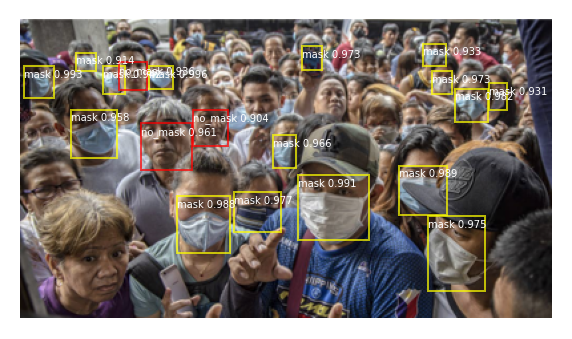

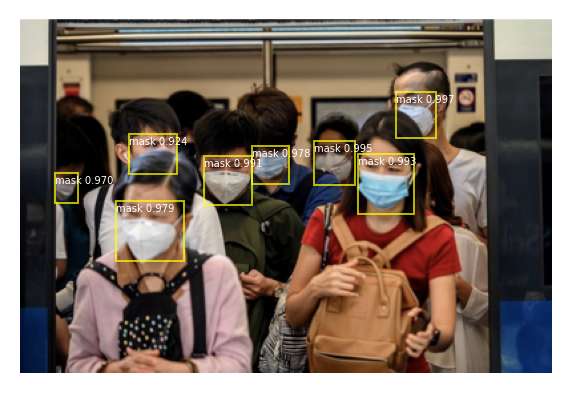

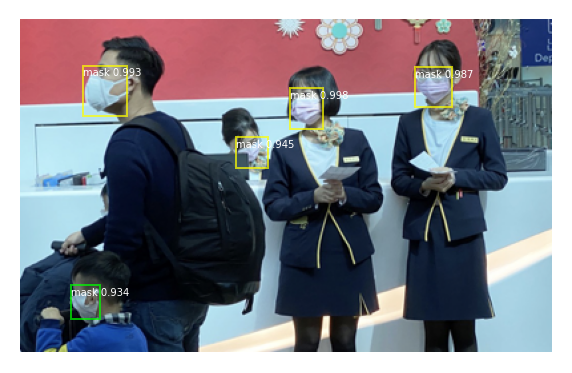

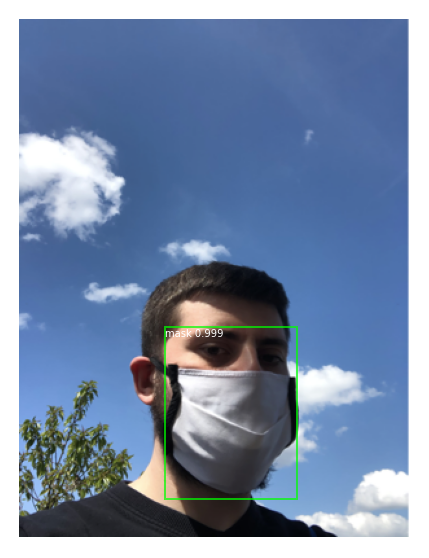

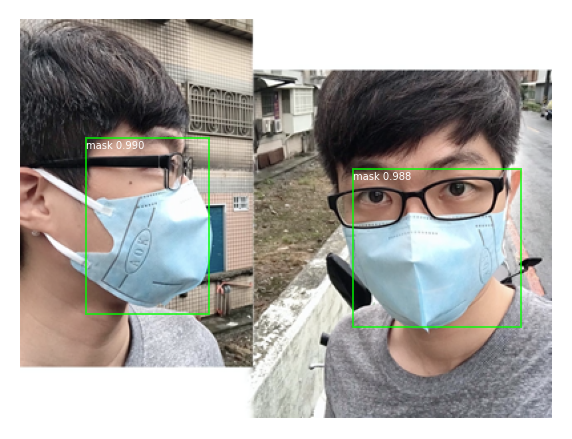

In [27]:
#plotting predictions for 5 random images in the test subset
for image_path in np.random.choice(test_set_paths, 5):
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    img_arr = img_arr[:, :, :3]
    results = model2.detect([img_arr], verbose=1)
    r = results[0]
    social_distance_detector(img, r['rois'], r['masks'], r['class_ids'], 
                                test_set.class_names, r['scores'], figsize=(10,10))

## **Take-aways**

- Using Mask CRNN it is possible to not only identify the location of a face in an image but also, classify it into one of three categories: with mask, without mask and mask worn incorrectly
- The implementation in Keras provides a relatively simple way to construct a model and adapt it for various applications
- Training on GPU is necessary to achieve timely results

- Applications of the model in this notebook are very practical, especially during the ongoing COVID-19 pandemic to determine who is following safety protocols and guidelines set by doctors and medical experts
- This model can be combined with OpenCV to achieve real-time detection of mask-wearing
- This can be useful in areas where there are huge congregations of people, moving frequently through the area, in a way that makes it difficult to do manual checks